# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6154952320994935 -2.6473015260792745
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = targetQs[1:]
    #Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [28]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model3.ckpt')

Episode:0 meanR:32.0000 rate:0.0640 gloss:0.0033 dloss:1.3883 dlossR:0.6951 dlossQ:0.6931
Episode:1 meanR:36.5000 rate:0.0820 gloss:-0.0156 dloss:1.3768 dlossR:0.6837 dlossQ:0.6931
Episode:2 meanR:44.6667 rate:0.1220 gloss:-0.0310 dloss:1.3692 dlossR:0.6763 dlossQ:0.6929
Episode:3 meanR:46.7500 rate:0.1060 gloss:-0.0445 dloss:1.3609 dlossR:0.6683 dlossQ:0.6926
Episode:4 meanR:42.0000 rate:0.0460 gloss:-0.0743 dloss:1.3380 dlossR:0.6465 dlossQ:0.6915
Episode:5 meanR:40.6667 rate:0.0680 gloss:-0.0983 dloss:1.3240 dlossR:0.6353 dlossQ:0.6888
Episode:6 meanR:41.0000 rate:0.0860 gloss:-0.0648 dloss:1.3465 dlossR:0.6545 dlossQ:0.6920
Episode:7 meanR:44.1250 rate:0.1320 gloss:-0.0835 dloss:1.3414 dlossR:0.6500 dlossQ:0.6914
Episode:8 meanR:41.6667 rate:0.0440 gloss:-0.0969 dloss:1.3208 dlossR:0.6302 dlossQ:0.6906
Episode:9 meanR:39.2000 rate:0.0340 gloss:-0.1227 dloss:1.3022 dlossR:0.6131 dlossQ:0.6891
Episode:10 meanR:36.9091 rate:0.0280 gloss:-0.1655 dloss:1.2735 dlossR:0.5877 dlossQ:0.6858

Episode:90 meanR:37.1978 rate:0.1960 gloss:-1.6024 dloss:0.8550 dlossR:0.5510 dlossQ:0.3040
Episode:91 meanR:37.4130 rate:0.1140 gloss:-1.6432 dloss:0.6540 dlossR:0.3621 dlossQ:0.2919
Episode:92 meanR:37.6774 rate:0.1240 gloss:-1.7109 dloss:0.6641 dlossR:0.3898 dlossQ:0.2743
Episode:93 meanR:37.4255 rate:0.0280 gloss:-1.7605 dloss:0.4155 dlossR:0.1508 dlossQ:0.2647
Episode:94 meanR:37.1368 rate:0.0200 gloss:-2.2652 dloss:0.2942 dlossR:0.1179 dlossQ:0.1763
Episode:95 meanR:36.8958 rate:0.0280 gloss:-1.7123 dloss:0.4275 dlossR:0.1526 dlossQ:0.2749
Episode:96 meanR:36.7010 rate:0.0360 gloss:-1.5803 dloss:0.4880 dlossR:0.1797 dlossQ:0.3083
Episode:97 meanR:36.5816 rate:0.0500 gloss:-1.5619 dloss:0.5251 dlossR:0.2125 dlossQ:0.3126
Episode:98 meanR:36.5556 rate:0.0680 gloss:-1.5620 dloss:0.5653 dlossR:0.2531 dlossQ:0.3122
Episode:99 meanR:36.4600 rate:0.0540 gloss:-1.5405 dloss:0.5404 dlossR:0.2226 dlossQ:0.3177
Episode:100 meanR:36.4600 rate:0.0640 gloss:-1.5534 dloss:0.5585 dlossR:0.2444 d

Episode:181 meanR:51.0000 rate:0.2320 gloss:-1.1760 dloss:0.9975 dlossR:0.5650 dlossQ:0.4325
Episode:182 meanR:52.5700 rate:0.3360 gloss:-1.1793 dloss:1.1741 dlossR:0.7427 dlossQ:0.4314
Episode:183 meanR:53.3700 rate:0.1840 gloss:-1.2013 dloss:0.9104 dlossR:0.4853 dlossQ:0.4251
Episode:184 meanR:58.2700 rate:1.0000 gloss:-1.2126 dloss:2.3377 dlossR:1.9169 dlossQ:0.4207
Episode:185 meanR:59.1300 rate:0.1900 gloss:-1.2350 dloss:0.9110 dlossR:0.4964 dlossQ:0.4146
Episode:186 meanR:59.4000 rate:0.0800 gloss:-1.0454 dloss:0.7932 dlossR:0.3206 dlossQ:0.4726
Episode:187 meanR:59.6800 rate:0.0820 gloss:-1.1089 dloss:0.7699 dlossR:0.3169 dlossQ:0.4531
Episode:188 meanR:59.8200 rate:0.0500 gloss:-1.1311 dloss:0.7089 dlossR:0.2625 dlossQ:0.4464
Episode:189 meanR:59.8400 rate:0.0620 gloss:-1.0824 dloss:0.7498 dlossR:0.2881 dlossQ:0.4617
Episode:190 meanR:59.0900 rate:0.0460 gloss:-1.0902 dloss:0.7211 dlossR:0.2619 dlossQ:0.4591
Episode:191 meanR:58.7800 rate:0.0520 gloss:-1.1605 dloss:0.6999 dloss

Episode:271 meanR:49.1300 rate:0.0360 gloss:-1.9644 dloss:0.3795 dlossR:0.1623 dlossQ:0.2173
Episode:272 meanR:49.1200 rate:0.0240 gloss:-1.9913 dloss:0.3399 dlossR:0.1284 dlossQ:0.2115
Episode:273 meanR:49.1200 rate:0.0280 gloss:-2.0165 dloss:0.3460 dlossR:0.1386 dlossQ:0.2073
Episode:274 meanR:49.1000 rate:0.0240 gloss:-2.1432 dloss:0.3074 dlossR:0.1238 dlossQ:0.1836
Episode:275 meanR:49.1100 rate:0.0220 gloss:-2.1324 dloss:0.3040 dlossR:0.1182 dlossQ:0.1858
Episode:276 meanR:49.1300 rate:0.0280 gloss:-2.2701 dloss:0.2959 dlossR:0.1337 dlossQ:0.1622
Episode:277 meanR:49.1800 rate:0.0320 gloss:-2.1339 dloss:0.3320 dlossR:0.1466 dlossQ:0.1854
Episode:278 meanR:49.0000 rate:0.0560 gloss:-1.9150 dloss:0.4495 dlossR:0.2193 dlossQ:0.2302
Episode:279 meanR:48.9900 rate:0.0760 gloss:-1.9048 dloss:0.5132 dlossR:0.2776 dlossQ:0.2356
Episode:280 meanR:48.8700 rate:0.0960 gloss:-1.7975 dloss:0.5939 dlossR:0.3301 dlossQ:0.2638
Episode:281 meanR:52.7100 rate:1.0000 gloss:-1.7400 dloss:2.8664 dloss

Episode:364 meanR:63.7200 rate:0.0440 gloss:-1.2078 dloss:0.6625 dlossR:0.2401 dlossQ:0.4224
Episode:365 meanR:63.7200 rate:0.0520 gloss:-1.2213 dloss:0.6692 dlossR:0.2518 dlossQ:0.4174
Episode:366 meanR:63.5900 rate:0.0320 gloss:-1.3009 dloss:0.6005 dlossR:0.2069 dlossQ:0.3936
Episode:367 meanR:63.6000 rate:0.0380 gloss:-1.3521 dloss:0.5883 dlossR:0.2110 dlossQ:0.3773
Episode:368 meanR:63.5700 rate:0.0320 gloss:-1.4009 dloss:0.5560 dlossR:0.1941 dlossQ:0.3619
Episode:369 meanR:63.6200 rate:0.0380 gloss:-1.4486 dloss:0.5496 dlossR:0.2009 dlossQ:0.3488
Episode:370 meanR:63.6500 rate:0.0320 gloss:-1.4899 dloss:0.5244 dlossR:0.1863 dlossQ:0.3381
Episode:371 meanR:63.5900 rate:0.0240 gloss:-1.6244 dloss:0.4598 dlossR:0.1583 dlossQ:0.3015
Episode:372 meanR:63.5700 rate:0.0200 gloss:-1.7715 dloss:0.4075 dlossR:0.1411 dlossQ:0.2664
Episode:373 meanR:63.5300 rate:0.0200 gloss:-1.8463 dloss:0.3886 dlossR:0.1379 dlossQ:0.2507
Episode:374 meanR:63.5000 rate:0.0180 gloss:-1.9831 dloss:0.3531 dloss

Episode:454 meanR:61.8900 rate:1.0000 gloss:-1.1247 dloss:2.2547 dlossR:1.8066 dlossQ:0.4480
Episode:455 meanR:66.4400 rate:1.0000 gloss:-1.0943 dloss:2.2287 dlossR:1.7709 dlossQ:0.4578
Episode:456 meanR:66.7700 rate:0.1420 gloss:-1.0952 dloss:0.8714 dlossR:0.4131 dlossQ:0.4583
Episode:457 meanR:68.7800 rate:0.4780 gloss:-1.0319 dloss:1.3947 dlossR:0.9164 dlossQ:0.4784
Episode:458 meanR:69.0500 rate:0.1380 gloss:-1.0046 dloss:0.8987 dlossR:0.4118 dlossQ:0.4869
Episode:459 meanR:69.1800 rate:0.1200 gloss:-0.9787 dloss:0.8838 dlossR:0.3886 dlossQ:0.4952
Episode:460 meanR:69.2200 rate:0.0960 gloss:-0.9657 dloss:0.8568 dlossR:0.3572 dlossQ:0.4996
Episode:461 meanR:69.1000 rate:0.0680 gloss:-0.9474 dloss:0.8272 dlossR:0.3214 dlossQ:0.5057
Episode:462 meanR:68.9900 rate:0.0700 gloss:-0.9530 dloss:0.8275 dlossR:0.3231 dlossQ:0.5044
Episode:463 meanR:68.7800 rate:0.0360 gloss:-1.0144 dloss:0.7505 dlossR:0.2647 dlossQ:0.4858
Episode:464 meanR:68.7700 rate:0.0420 gloss:-1.0080 dloss:0.7614 dloss

Episode:548 meanR:86.7300 rate:0.1300 gloss:-0.7057 dloss:1.0218 dlossR:0.4427 dlossQ:0.5791
Episode:549 meanR:86.3200 rate:0.1500 gloss:-0.6889 dloss:1.0489 dlossR:0.4652 dlossQ:0.5837
Episode:550 meanR:86.5700 rate:0.2560 gloss:-0.6087 dloss:1.1805 dlossR:0.5764 dlossQ:0.6041
Episode:551 meanR:86.9500 rate:0.2940 gloss:-0.6053 dloss:1.2148 dlossR:0.6090 dlossQ:0.6059
Episode:552 meanR:86.6500 rate:0.2120 gloss:-0.6745 dloss:1.1155 dlossR:0.5278 dlossQ:0.5877
Episode:553 meanR:88.0200 rate:0.6920 gloss:-0.5841 dloss:1.5556 dlossR:0.9436 dlossQ:0.6120
Episode:554 meanR:88.0200 rate:1.0000 gloss:-0.5630 dloss:1.7985 dlossR:1.1808 dlossQ:0.6177
Episode:555 meanR:88.0200 rate:1.0000 gloss:-0.5345 dloss:1.7781 dlossR:1.1531 dlossQ:0.6250
Episode:556 meanR:92.3100 rate:1.0000 gloss:-0.5145 dloss:1.7632 dlossR:1.1336 dlossQ:0.6296
Episode:557 meanR:94.9200 rate:1.0000 gloss:-0.4938 dloss:1.7476 dlossR:1.1133 dlossQ:0.6343
Episode:558 meanR:99.2300 rate:1.0000 gloss:-0.4925 dloss:1.7456 dloss

Episode:636 meanR:195.8100 rate:0.1860 gloss:-0.3490 dloss:1.2530 dlossR:0.6246 dlossQ:0.6285
Episode:637 meanR:196.0500 rate:0.0680 gloss:-0.3567 dloss:1.1696 dlossR:0.5258 dlossQ:0.6438
Episode:638 meanR:196.2400 rate:0.0580 gloss:-0.4090 dloss:1.1319 dlossR:0.4897 dlossQ:0.6422
Episode:639 meanR:196.3700 rate:0.0500 gloss:-0.4581 dloss:1.0963 dlossR:0.4651 dlossQ:0.6312
Episode:640 meanR:196.4500 rate:0.0360 gloss:-0.4399 dloss:1.0927 dlossR:0.4516 dlossQ:0.6410
Episode:641 meanR:195.5200 rate:0.0400 gloss:-0.5017 dloss:1.0585 dlossR:0.4346 dlossQ:0.6239
Episode:642 meanR:190.7300 rate:0.0420 gloss:-0.6521 dloss:0.9698 dlossR:0.3805 dlossQ:0.5893
Episode:643 meanR:190.3900 rate:0.0380 gloss:-0.7222 dloss:0.9217 dlossR:0.3504 dlossQ:0.5713
Episode:644 meanR:190.2200 rate:0.0340 gloss:-0.6480 dloss:0.9583 dlossR:0.3698 dlossQ:0.5885
Episode:645 meanR:189.9900 rate:0.0240 gloss:-0.7123 dloss:0.9000 dlossR:0.3261 dlossQ:0.5739
Episode:646 meanR:189.7400 rate:0.0320 gloss:-0.9979 dloss:0

Episode:727 meanR:52.0100 rate:0.0440 gloss:-1.0546 dloss:0.7345 dlossR:0.2639 dlossQ:0.4706
Episode:728 meanR:52.0900 rate:0.0460 gloss:-1.0633 dloss:0.7341 dlossR:0.2658 dlossQ:0.4682
Episode:729 meanR:52.4400 rate:0.0960 gloss:-1.1960 dloss:0.7707 dlossR:0.3403 dlossQ:0.4304
Episode:730 meanR:52.6800 rate:0.0660 gloss:-1.3204 dloss:0.6926 dlossR:0.2889 dlossQ:0.4037
Episode:731 meanR:52.8300 rate:0.0500 gloss:-1.4948 dloss:0.6123 dlossR:0.2494 dlossQ:0.3629
Episode:732 meanR:53.3000 rate:0.1160 gloss:-1.1659 dloss:0.8125 dlossR:0.3741 dlossQ:0.4383
Episode:733 meanR:51.0400 rate:0.0480 gloss:-1.2475 dloss:0.6499 dlossR:0.2400 dlossQ:0.4099
Episode:734 meanR:50.3500 rate:0.0460 gloss:-1.3390 dloss:0.6074 dlossR:0.2253 dlossQ:0.3821
Episode:735 meanR:49.7600 rate:0.0400 gloss:-1.4099 dloss:0.5668 dlossR:0.2059 dlossQ:0.3609
Episode:736 meanR:48.9900 rate:0.0320 gloss:-1.5665 dloss:0.4927 dlossR:0.1757 dlossQ:0.3170
Episode:737 meanR:48.7900 rate:0.0280 gloss:-1.5748 dloss:0.4835 dloss

Episode:820 meanR:40.1600 rate:0.0620 gloss:-1.7161 dloss:0.5157 dlossR:0.2375 dlossQ:0.2783
Episode:821 meanR:40.2100 rate:0.0340 gloss:-1.9526 dloss:0.3785 dlossR:0.1568 dlossQ:0.2217
Episode:822 meanR:40.2200 rate:0.0280 gloss:-1.9789 dloss:0.3561 dlossR:0.1399 dlossQ:0.2163
Episode:823 meanR:40.2400 rate:0.0260 gloss:-2.0822 dloss:0.3278 dlossR:0.1313 dlossQ:0.1965
Episode:824 meanR:40.2100 rate:0.0200 gloss:-2.1918 dloss:0.2882 dlossR:0.1108 dlossQ:0.1774
Episode:825 meanR:40.2200 rate:0.0380 gloss:-2.0449 dloss:0.4018 dlossR:0.1775 dlossQ:0.2243
Episode:826 meanR:40.4400 rate:0.0760 gloss:-1.8899 dloss:0.5119 dlossR:0.2745 dlossQ:0.2373
Episode:827 meanR:40.6200 rate:0.0800 gloss:-1.9310 dloss:0.5144 dlossR:0.2864 dlossQ:0.2280
Episode:828 meanR:41.0200 rate:0.1260 gloss:-1.9045 dloss:0.6454 dlossR:0.4118 dlossQ:0.2335
Episode:829 meanR:40.9000 rate:0.0720 gloss:-1.9967 dloss:0.4798 dlossR:0.2657 dlossQ:0.2141
Episode:830 meanR:41.0700 rate:0.1000 gloss:-1.9169 dloss:0.5768 dloss

Episode:910 meanR:32.2600 rate:0.1600 gloss:-1.6219 dloss:0.7714 dlossR:0.4697 dlossQ:0.3017
Episode:911 meanR:32.9100 rate:0.1880 gloss:-1.5556 dloss:0.8465 dlossR:0.5266 dlossQ:0.3199
Episode:912 meanR:33.4900 rate:0.1860 gloss:-1.7745 dloss:0.8139 dlossR:0.5527 dlossQ:0.2612
Episode:913 meanR:33.7400 rate:0.0960 gloss:-1.5639 dloss:0.6418 dlossR:0.3218 dlossQ:0.3200
Episode:914 meanR:34.3800 rate:0.1720 gloss:-1.4528 dloss:0.8284 dlossR:0.4798 dlossQ:0.3486
Episode:915 meanR:35.3100 rate:0.2540 gloss:-1.6479 dloss:0.9880 dlossR:0.6946 dlossQ:0.2934
Episode:916 meanR:36.5100 rate:0.3020 gloss:-1.4415 dloss:1.1001 dlossR:0.7487 dlossQ:0.3514
Episode:917 meanR:36.6400 rate:0.1120 gloss:-1.5105 dloss:0.6947 dlossR:0.3583 dlossQ:0.3363
Episode:918 meanR:36.9800 rate:0.1500 gloss:-1.4415 dloss:0.7928 dlossR:0.4370 dlossQ:0.3558
Episode:919 meanR:37.2900 rate:0.1420 gloss:-1.3377 dloss:0.7962 dlossR:0.4132 dlossQ:0.3830
Episode:920 meanR:37.5200 rate:0.1080 gloss:-1.4368 dloss:0.7013 dloss

Episode:1001 meanR:60.1000 rate:0.1000 gloss:-1.1626 dloss:0.7816 dlossR:0.3439 dlossQ:0.4377
Episode:1002 meanR:60.4100 rate:0.1200 gloss:-1.1683 dloss:0.8132 dlossR:0.3775 dlossQ:0.4357
Episode:1003 meanR:60.1700 rate:0.0320 gloss:-1.4980 dloss:0.5215 dlossR:0.1842 dlossQ:0.3374
Episode:1004 meanR:59.8500 rate:0.0320 gloss:-1.5864 dloss:0.4882 dlossR:0.1760 dlossQ:0.3122
Episode:1005 meanR:58.0000 rate:0.0340 gloss:-1.5506 dloss:0.5045 dlossR:0.1828 dlossQ:0.3217
Episode:1006 meanR:57.8100 rate:0.0360 gloss:-1.5206 dloss:0.5182 dlossR:0.1884 dlossQ:0.3298
Episode:1007 meanR:57.5200 rate:0.0360 gloss:-1.5326 dloss:0.5165 dlossR:0.1887 dlossQ:0.3278
Episode:1008 meanR:57.0000 rate:0.0320 gloss:-1.5315 dloss:0.5090 dlossR:0.1806 dlossQ:0.3284
Episode:1009 meanR:56.5700 rate:0.0680 gloss:-1.3977 dloss:0.6289 dlossR:0.2636 dlossQ:0.3654
Episode:1010 meanR:56.0800 rate:0.0620 gloss:-1.3975 dloss:0.6177 dlossR:0.2523 dlossQ:0.3655
Episode:1011 meanR:56.0400 rate:0.1800 gloss:-1.5592 dloss:0

Episode:1093 meanR:34.6700 rate:0.2620 gloss:-1.8000 dloss:1.0130 dlossR:0.7560 dlossQ:0.2570
Episode:1094 meanR:35.4200 rate:0.1720 gloss:-1.5751 dloss:0.8027 dlossR:0.4905 dlossQ:0.3122
Episode:1095 meanR:36.4100 rate:0.2140 gloss:-1.5876 dloss:0.9050 dlossR:0.5914 dlossQ:0.3136
Episode:1096 meanR:36.9400 rate:0.1300 gloss:-1.6024 dloss:0.7067 dlossR:0.3989 dlossQ:0.3078
Episode:1097 meanR:37.8200 rate:0.2220 gloss:-1.5383 dloss:0.9220 dlossR:0.5983 dlossQ:0.3237
Episode:1098 meanR:38.4400 rate:0.1920 gloss:-1.5639 dloss:0.8591 dlossR:0.5386 dlossQ:0.3205
Episode:1099 meanR:38.7900 rate:0.1800 gloss:-1.5059 dloss:0.8299 dlossR:0.4999 dlossQ:0.3300
Episode:1100 meanR:38.7500 rate:0.1220 gloss:-1.5454 dloss:0.6952 dlossR:0.3751 dlossQ:0.3202
Episode:1101 meanR:38.5500 rate:0.0600 gloss:-1.6388 dloss:0.5302 dlossR:0.2342 dlossQ:0.2960
Episode:1102 meanR:38.1300 rate:0.0360 gloss:-1.7474 dloss:0.4416 dlossR:0.1727 dlossQ:0.2690
Episode:1103 meanR:38.0600 rate:0.0180 gloss:-2.0948 dloss:0

Episode:1184 meanR:46.1600 rate:0.1720 gloss:-1.5111 dloss:0.8137 dlossR:0.4836 dlossQ:0.3300
Episode:1185 meanR:46.1700 rate:0.0940 gloss:-1.5092 dloss:0.6436 dlossR:0.3130 dlossQ:0.3306
Episode:1186 meanR:45.7800 rate:0.0900 gloss:-1.5496 dloss:0.6236 dlossR:0.3038 dlossQ:0.3198
Episode:1187 meanR:45.8400 rate:0.0760 gloss:-1.5838 dloss:0.5824 dlossR:0.2718 dlossQ:0.3106
Episode:1188 meanR:45.7700 rate:0.0460 gloss:-1.6778 dloss:0.4836 dlossR:0.1980 dlossQ:0.2856
Episode:1189 meanR:45.8500 rate:0.0440 gloss:-1.7035 dloss:0.4712 dlossR:0.1921 dlossQ:0.2791
Episode:1190 meanR:45.8400 rate:0.0520 gloss:-1.6921 dloss:0.4952 dlossR:0.2126 dlossQ:0.2825
Episode:1191 meanR:45.5800 rate:0.0300 gloss:-1.8536 dloss:0.3935 dlossR:0.1504 dlossQ:0.2431
Episode:1192 meanR:45.4500 rate:0.0400 gloss:-1.8339 dloss:0.4246 dlossR:0.1772 dlossQ:0.2474
Episode:1193 meanR:44.3500 rate:0.0420 gloss:-1.8183 dloss:0.4337 dlossR:0.1829 dlossQ:0.2508
Episode:1194 meanR:43.7000 rate:0.0420 gloss:-1.8260 dloss:0

Episode:1274 meanR:74.8300 rate:0.0340 gloss:-1.0063 dloss:0.7585 dlossR:0.2696 dlossQ:0.4889
Episode:1275 meanR:74.7000 rate:0.0540 gloss:-0.9797 dloss:0.7997 dlossR:0.3025 dlossQ:0.4972
Episode:1276 meanR:74.8300 rate:0.0460 gloss:-1.0326 dloss:0.7613 dlossR:0.2806 dlossQ:0.4807
Episode:1277 meanR:74.6400 rate:0.0420 gloss:-1.1061 dloss:0.7170 dlossR:0.2597 dlossQ:0.4573
Episode:1278 meanR:74.5900 rate:0.0400 gloss:-1.0950 dloss:0.7223 dlossR:0.2606 dlossQ:0.4617
Episode:1279 meanR:74.6800 rate:0.0480 gloss:-1.1290 dloss:0.7169 dlossR:0.2661 dlossQ:0.4508
Episode:1280 meanR:74.7800 rate:0.0480 gloss:-1.1587 dloss:0.7037 dlossR:0.2619 dlossQ:0.4418
Episode:1281 meanR:74.8900 rate:0.0420 gloss:-1.1393 dloss:0.7049 dlossR:0.2566 dlossQ:0.4483
Episode:1282 meanR:74.9000 rate:0.0480 gloss:-1.1994 dloss:0.6860 dlossR:0.2563 dlossQ:0.4297
Episode:1283 meanR:74.6800 rate:0.0360 gloss:-1.2766 dloss:0.6313 dlossR:0.2254 dlossQ:0.4059
Episode:1284 meanR:74.1400 rate:0.0640 gloss:-1.2063 dloss:0

Episode:1369 meanR:44.2400 rate:0.0600 gloss:-1.6815 dloss:0.5579 dlossR:0.2506 dlossQ:0.3073
Episode:1370 meanR:44.3400 rate:0.0600 gloss:-1.6618 dloss:0.5712 dlossR:0.2551 dlossQ:0.3161
Episode:1371 meanR:44.4100 rate:0.0680 gloss:-1.6078 dloss:0.6012 dlossR:0.2733 dlossQ:0.3279
Episode:1372 meanR:44.4600 rate:0.0540 gloss:-1.7835 dloss:0.5126 dlossR:0.2303 dlossQ:0.2823
Episode:1373 meanR:44.3800 rate:0.0260 gloss:-1.9366 dloss:0.3702 dlossR:0.1404 dlossQ:0.2299
Episode:1374 meanR:44.3500 rate:0.0280 gloss:-2.0869 dloss:0.3436 dlossR:0.1425 dlossQ:0.2012
Episode:1375 meanR:44.2500 rate:0.0340 gloss:-2.0592 dloss:0.3684 dlossR:0.1596 dlossQ:0.2088
Episode:1376 meanR:44.2000 rate:0.0360 gloss:-1.7703 dloss:0.4704 dlossR:0.1856 dlossQ:0.2847
Episode:1377 meanR:44.2700 rate:0.0560 gloss:-1.5313 dloss:0.5825 dlossR:0.2417 dlossQ:0.3408
Episode:1378 meanR:44.5000 rate:0.0860 gloss:-1.6413 dloss:0.6179 dlossR:0.3065 dlossQ:0.3114
Episode:1379 meanR:44.3700 rate:0.0220 gloss:-2.5452 dloss:0

Episode:1457 meanR:56.9500 rate:0.1740 gloss:-1.1783 dloss:0.9037 dlossR:0.4696 dlossQ:0.4342
Episode:1458 meanR:57.0300 rate:0.0620 gloss:-1.3318 dloss:0.6565 dlossR:0.2661 dlossQ:0.3904
Episode:1459 meanR:57.1700 rate:0.0500 gloss:-1.4513 dloss:0.5944 dlossR:0.2351 dlossQ:0.3593
Episode:1460 meanR:57.6000 rate:0.1100 gloss:-1.2956 dloss:0.7639 dlossR:0.3602 dlossQ:0.4037
Episode:1461 meanR:58.2000 rate:0.1640 gloss:-1.3816 dloss:0.8357 dlossR:0.4612 dlossQ:0.3745
Episode:1462 meanR:58.7000 rate:0.1720 gloss:-1.2948 dloss:0.8716 dlossR:0.4717 dlossQ:0.3999
Episode:1463 meanR:60.4500 rate:0.4520 gloss:-1.4239 dloss:1.4147 dlossR:1.0551 dlossQ:0.3596
Episode:1464 meanR:64.9400 rate:1.0000 gloss:-1.2625 dloss:2.3794 dlossR:1.9734 dlossQ:0.4060
Episode:1465 meanR:66.3200 rate:0.3080 gloss:-1.3390 dloss:1.1170 dlossR:0.7338 dlossQ:0.3832
Episode:1466 meanR:68.3200 rate:0.4320 gloss:-1.1519 dloss:1.3350 dlossR:0.8940 dlossQ:0.4410
Episode:1467 meanR:68.9000 rate:0.1420 gloss:-1.3363 dloss:0

Episode:1546 meanR:98.7300 rate:0.2020 gloss:-0.8120 dloss:1.0593 dlossR:0.5115 dlossQ:0.5478
Episode:1547 meanR:98.3000 rate:0.0720 gloss:-0.9250 dloss:0.8594 dlossR:0.3455 dlossQ:0.5138
Episode:1548 meanR:97.5200 rate:0.0580 gloss:-0.9734 dloss:0.8170 dlossR:0.3178 dlossQ:0.4992
Episode:1549 meanR:96.9400 rate:0.0680 gloss:-0.9261 dloss:0.8518 dlossR:0.3378 dlossQ:0.5140
Episode:1550 meanR:96.7200 rate:0.1480 gloss:-0.8592 dloss:0.9756 dlossR:0.4414 dlossQ:0.5342
Episode:1551 meanR:96.5700 rate:0.1560 gloss:-0.8401 dloss:0.9940 dlossR:0.4544 dlossQ:0.5396
Episode:1552 meanR:96.6200 rate:0.2460 gloss:-0.7896 dloss:1.1169 dlossR:0.5620 dlossQ:0.5549
Episode:1553 meanR:100.5600 rate:0.9560 gloss:-0.8260 dloss:1.9509 dlossR:1.4077 dlossQ:0.5432
Episode:1554 meanR:104.8600 rate:1.0000 gloss:-0.7743 dloss:1.9622 dlossR:1.4031 dlossQ:0.5591
Episode:1555 meanR:108.9400 rate:1.0000 gloss:-0.7836 dloss:1.9685 dlossR:1.4123 dlossQ:0.5562
Episode:1556 meanR:113.4500 rate:1.0000 gloss:-0.6835 dlo

Episode:1635 meanR:132.7700 rate:0.0920 gloss:-0.8994 dloss:0.9004 dlossR:0.3762 dlossQ:0.5241
Episode:1636 meanR:133.0300 rate:0.0800 gloss:-0.9858 dloss:0.8400 dlossR:0.3417 dlossQ:0.4983
Episode:1637 meanR:134.3500 rate:0.2840 gloss:-0.9001 dloss:1.1445 dlossR:0.6193 dlossQ:0.5252
Episode:1638 meanR:136.8000 rate:0.7400 gloss:-0.8443 dloss:1.7101 dlossR:1.1683 dlossQ:0.5419
Episode:1639 meanR:141.3400 rate:1.0000 gloss:-0.7879 dloss:1.9790 dlossR:1.4189 dlossQ:0.5601
Episode:1640 meanR:146.2500 rate:1.0000 gloss:-0.8187 dloss:2.0050 dlossR:1.4556 dlossQ:0.5493
Episode:1641 meanR:146.4500 rate:0.1460 gloss:-0.8703 dloss:0.9768 dlossR:0.4451 dlossQ:0.5317
Episode:1642 meanR:145.8200 rate:0.1580 gloss:-0.8377 dloss:1.0028 dlossR:0.4621 dlossQ:0.5407
Episode:1643 meanR:141.5300 rate:0.1420 gloss:-0.9780 dloss:0.9301 dlossR:0.4294 dlossQ:0.5006
Episode:1644 meanR:141.0600 rate:0.1200 gloss:-1.0251 dloss:0.8803 dlossR:0.3943 dlossQ:0.4861
Episode:1645 meanR:140.1700 rate:0.0200 gloss:-1.7

Episode:1724 meanR:97.8500 rate:1.0000 gloss:-0.8337 dloss:2.0164 dlossR:1.4683 dlossQ:0.5481
Episode:1725 meanR:101.1200 rate:0.7240 gloss:-0.9282 dloss:1.7333 dlossR:1.2113 dlossQ:0.5220
Episode:1726 meanR:101.2900 rate:0.1340 gloss:-1.0387 dloss:0.9023 dlossR:0.4170 dlossQ:0.4854
Episode:1727 meanR:101.9800 rate:0.1560 gloss:-1.0398 dloss:0.9379 dlossR:0.4512 dlossQ:0.4866
Episode:1728 meanR:106.1100 rate:0.8860 gloss:-0.8679 dloss:1.9106 dlossR:1.3739 dlossQ:0.5367
Episode:1729 meanR:105.9200 rate:0.0520 gloss:-1.2962 dloss:0.7073 dlossR:0.2842 dlossQ:0.4231
Episode:1730 meanR:102.4200 rate:0.0560 gloss:-1.4374 dloss:0.6277 dlossR:0.2585 dlossQ:0.3692
Episode:1731 meanR:101.5800 rate:0.0180 gloss:-1.9882 dloss:0.4105 dlossR:0.1589 dlossQ:0.2516
Episode:1732 meanR:101.3800 rate:0.0520 gloss:-1.5051 dloss:0.5876 dlossR:0.2413 dlossQ:0.3463
Episode:1733 meanR:101.7400 rate:0.1460 gloss:-0.9136 dloss:0.9679 dlossR:0.4462 dlossQ:0.5217
Episode:1734 meanR:103.2600 rate:0.3920 gloss:-0.85

Episode:1812 meanR:132.8800 rate:1.0000 gloss:-0.5179 dloss:1.7676 dlossR:1.1370 dlossQ:0.6306
Episode:1813 meanR:132.6800 rate:0.2120 gloss:-0.6434 dloss:1.1427 dlossR:0.5458 dlossQ:0.5970
Episode:1814 meanR:132.7000 rate:0.1260 gloss:-0.9224 dloss:0.9324 dlossR:0.4167 dlossQ:0.5157
Episode:1815 meanR:131.9500 rate:0.0200 gloss:-1.1484 dloss:0.6889 dlossR:0.2434 dlossQ:0.4455
Episode:1816 meanR:129.3100 rate:0.0180 gloss:-1.4354 dloss:0.5767 dlossR:0.2082 dlossQ:0.3685
Episode:1817 meanR:130.3000 rate:0.7500 gloss:-0.7523 dloss:1.6808 dlossR:1.1166 dlossQ:0.5642
Episode:1818 meanR:133.9800 rate:1.0000 gloss:-0.3028 dloss:1.6098 dlossR:0.9399 dlossQ:0.6699
Episode:1819 meanR:133.3000 rate:0.0840 gloss:-0.7807 dloss:0.9460 dlossR:0.3891 dlossQ:0.5569
Episode:1820 meanR:133.0100 rate:0.0300 gloss:-0.9244 dloss:0.8093 dlossR:0.2927 dlossQ:0.5165
Episode:1821 meanR:132.8900 rate:0.0220 gloss:-1.0543 dloss:0.7381 dlossR:0.2616 dlossQ:0.4766
Episode:1822 meanR:132.1800 rate:0.0520 gloss:-0.8

Episode:1903 meanR:114.2400 rate:0.1080 gloss:-1.2424 dloss:0.7932 dlossR:0.3678 dlossQ:0.4254
Episode:1904 meanR:109.9100 rate:0.1340 gloss:-1.0876 dloss:0.8986 dlossR:0.4240 dlossQ:0.4747
Episode:1905 meanR:105.5700 rate:0.1320 gloss:-1.0113 dloss:0.9202 dlossR:0.4235 dlossQ:0.4967
Episode:1906 meanR:105.9900 rate:0.1580 gloss:-1.0029 dloss:0.9609 dlossR:0.4619 dlossQ:0.4990
Episode:1907 meanR:106.3800 rate:0.1080 gloss:-1.2725 dloss:0.7926 dlossR:0.3731 dlossQ:0.4194
Episode:1908 meanR:106.7500 rate:0.0940 gloss:-1.5678 dloss:0.6761 dlossR:0.3363 dlossQ:0.3399
Episode:1909 meanR:101.8800 rate:0.0260 gloss:-2.0251 dloss:0.3935 dlossR:0.1616 dlossQ:0.2319
Episode:1910 meanR:101.9500 rate:0.0360 gloss:-1.7830 dloss:0.4735 dlossR:0.1913 dlossQ:0.2822
Episode:1911 meanR:101.5900 rate:0.1440 gloss:-1.4569 dloss:0.7929 dlossR:0.4338 dlossQ:0.3591
Episode:1912 meanR:101.5900 rate:1.0000 gloss:-0.9600 dloss:2.1215 dlossR:1.6136 dlossQ:0.5079
Episode:1913 meanR:101.4000 rate:0.1740 gloss:-1.0

Episode:1993 meanR:114.5900 rate:0.1600 gloss:-0.9730 dloss:0.9688 dlossR:0.4724 dlossQ:0.4964
Episode:1994 meanR:115.0400 rate:0.1560 gloss:-0.8429 dloss:1.0123 dlossR:0.4794 dlossQ:0.5328
Episode:1995 meanR:115.8400 rate:0.2040 gloss:-1.5056 dloss:0.9487 dlossR:0.5946 dlossQ:0.3542
Episode:1996 meanR:116.2900 rate:0.1460 gloss:-1.7145 dloss:0.7645 dlossR:0.4660 dlossQ:0.2985
Episode:1997 meanR:116.1400 rate:0.0280 gloss:-1.4596 dloss:0.5762 dlossR:0.2145 dlossQ:0.3618
Episode:1998 meanR:115.7500 rate:0.0180 gloss:-1.8626 dloss:0.4422 dlossR:0.1690 dlossQ:0.2732
Episode:1999 meanR:115.0000 rate:0.0260 gloss:-1.4942 dloss:0.5772 dlossR:0.2208 dlossQ:0.3564
Episode:2000 meanR:115.2500 rate:0.1360 gloss:-1.3160 dloss:0.8623 dlossR:0.4489 dlossQ:0.4134
Episode:2001 meanR:115.4500 rate:0.1100 gloss:-0.6675 dloss:1.0310 dlossR:0.4402 dlossQ:0.5907
Episode:2002 meanR:115.3300 rate:0.0340 gloss:-1.0026 dloss:0.7703 dlossR:0.2784 dlossQ:0.4919
Episode:2003 meanR:114.9100 rate:0.0240 gloss:-1.3

Episode:2084 meanR:84.8000 rate:1.0000 gloss:-0.1925 dloss:1.5326 dlossR:0.8580 dlossQ:0.6746
Episode:2085 meanR:84.6600 rate:0.1200 gloss:-1.0728 dloss:0.9006 dlossR:0.4170 dlossQ:0.4835
Episode:2086 meanR:84.6300 rate:0.0580 gloss:-1.6831 dloss:0.6069 dlossR:0.2726 dlossQ:0.3343
Episode:2087 meanR:84.2800 rate:0.0240 gloss:-1.5636 dloss:0.5094 dlossR:0.1806 dlossQ:0.3288
Episode:2088 meanR:83.9900 rate:0.0220 gloss:-1.8299 dloss:0.4294 dlossR:0.1615 dlossQ:0.2679
Episode:2089 meanR:83.7800 rate:0.0300 gloss:-1.3600 dloss:0.6040 dlossR:0.2170 dlossQ:0.3870
Episode:2090 meanR:83.6700 rate:0.0340 gloss:-1.5182 dloss:0.5402 dlossR:0.1999 dlossQ:0.3403
Episode:2091 meanR:83.5000 rate:0.0780 gloss:-1.3105 dloss:0.7185 dlossR:0.3114 dlossQ:0.4071
Episode:2092 meanR:83.2100 rate:0.1240 gloss:-0.8792 dloss:0.9747 dlossR:0.4396 dlossQ:0.5351
Episode:2093 meanR:87.4100 rate:1.0000 gloss:-0.4174 dloss:1.6973 dlossR:1.0446 dlossQ:0.6526
Episode:2094 meanR:87.0100 rate:0.0760 gloss:-1.0656 dloss:0

Episode:2173 meanR:67.8600 rate:0.0340 gloss:-1.8719 dloss:0.4430 dlossR:0.1802 dlossQ:0.2628
Episode:2174 meanR:67.8400 rate:0.0320 gloss:-2.2646 dloss:0.3344 dlossR:0.1557 dlossQ:0.1786
Episode:2175 meanR:68.1400 rate:0.0920 gloss:-1.9909 dloss:0.5443 dlossR:0.3242 dlossQ:0.2200
Episode:2176 meanR:69.0600 rate:0.2040 gloss:-1.1724 dloss:0.9935 dlossR:0.5644 dlossQ:0.4290
Episode:2177 meanR:73.9400 rate:1.0000 gloss:-0.0585 dloss:1.4370 dlossR:0.7703 dlossQ:0.6668
Episode:2178 meanR:75.0700 rate:0.5120 gloss:-1.0485 dloss:1.4843 dlossR:1.0235 dlossQ:0.4608
Episode:2179 meanR:75.5400 rate:1.0000 gloss:-0.8929 dloss:2.0671 dlossR:1.5349 dlossQ:0.5322
Episode:2180 meanR:77.0500 rate:0.3560 gloss:-1.5632 dloss:1.2866 dlossR:0.9354 dlossQ:0.3512
Episode:2181 meanR:77.4800 rate:0.1120 gloss:-1.4674 dloss:0.7187 dlossR:0.3624 dlossQ:0.3563
Episode:2182 meanR:77.6400 rate:0.0520 gloss:-1.6306 dloss:0.5369 dlossR:0.2245 dlossQ:0.3125
Episode:2183 meanR:77.2200 rate:0.0640 gloss:-1.5034 dloss:0

Episode:2260 meanR:196.8700 rate:1.0000 gloss:-0.2410 dloss:1.5637 dlossR:0.8881 dlossQ:0.6756
Episode:2261 meanR:201.6600 rate:1.0000 gloss:-0.0931 dloss:1.4556 dlossR:0.7688 dlossQ:0.6869
Episode:2262 meanR:206.4700 rate:1.0000 gloss:0.0491 dloss:1.3522 dlossR:0.6621 dlossQ:0.6901
Episode:2263 meanR:211.2800 rate:1.0000 gloss:0.1766 dloss:1.2597 dlossR:0.5744 dlossQ:0.6853
Episode:2264 meanR:216.0500 rate:1.0000 gloss:0.1692 dloss:1.2649 dlossR:0.5795 dlossQ:0.6854
Episode:2265 meanR:220.6900 rate:1.0000 gloss:0.2269 dloss:1.2234 dlossR:0.5438 dlossQ:0.6795
Episode:2266 meanR:225.0700 rate:1.0000 gloss:0.2646 dloss:1.1967 dlossR:0.5220 dlossQ:0.6747
Episode:2267 meanR:228.8200 rate:1.0000 gloss:0.3379 dloss:1.1439 dlossR:0.4798 dlossQ:0.6641
Episode:2268 meanR:228.8200 rate:1.0000 gloss:0.3456 dloss:1.1388 dlossR:0.4771 dlossQ:0.6617
Episode:2269 meanR:232.5100 rate:1.0000 gloss:0.3835 dloss:1.1126 dlossR:0.4607 dlossQ:0.6519
Episode:2270 meanR:236.8900 rate:1.0000 gloss:0.4549 dloss

Episode:2347 meanR:156.9700 rate:0.0520 gloss:-2.2686 dloss:0.3964 dlossR:0.2164 dlossQ:0.1800
Episode:2348 meanR:154.5800 rate:0.0760 gloss:-2.1230 dloss:0.4989 dlossR:0.2894 dlossQ:0.2095
Episode:2349 meanR:152.7800 rate:0.1000 gloss:-2.0703 dloss:0.5770 dlossR:0.3585 dlossQ:0.2185
Episode:2350 meanR:152.1200 rate:0.1740 gloss:-1.9916 dloss:0.8037 dlossR:0.5679 dlossQ:0.2358
Episode:2351 meanR:151.6500 rate:0.1080 gloss:-1.9602 dloss:0.6111 dlossR:0.3735 dlossQ:0.2376
Episode:2352 meanR:150.1400 rate:0.1160 gloss:-1.7808 dloss:0.6659 dlossR:0.3858 dlossQ:0.2801
Episode:2353 meanR:149.9200 rate:0.1240 gloss:-1.7862 dloss:0.6686 dlossR:0.4005 dlossQ:0.2681
Episode:2354 meanR:150.4000 rate:0.2240 gloss:-1.4533 dloss:0.9571 dlossR:0.5970 dlossQ:0.3600
Episode:2355 meanR:150.8700 rate:0.1160 gloss:-1.6750 dloss:0.6911 dlossR:0.3825 dlossQ:0.3086
Episode:2356 meanR:152.0900 rate:0.3300 gloss:-1.3579 dloss:1.1718 dlossR:0.7859 dlossQ:0.3859
Episode:2357 meanR:153.1400 rate:0.2300 gloss:-1.4

Episode:2434 meanR:50.5900 rate:0.0540 gloss:-1.5124 dloss:0.6092 dlossR:0.2536 dlossQ:0.3556
Episode:2435 meanR:50.3600 rate:0.0520 gloss:-1.5539 dloss:0.5779 dlossR:0.2391 dlossQ:0.3388
Episode:2436 meanR:51.0600 rate:0.1600 gloss:-1.5647 dloss:0.7899 dlossR:0.4686 dlossQ:0.3214
Episode:2437 meanR:51.6500 rate:0.1680 gloss:-1.2645 dloss:0.8771 dlossR:0.4662 dlossQ:0.4109
Episode:2438 meanR:50.2700 rate:0.0580 gloss:-1.4811 dloss:0.6225 dlossR:0.2609 dlossQ:0.3616
Episode:2439 meanR:50.5500 rate:0.1220 gloss:-1.4760 dloss:0.7276 dlossR:0.3804 dlossQ:0.3472
Episode:2440 meanR:50.6800 rate:0.0700 gloss:-1.5864 dloss:0.5928 dlossR:0.2696 dlossQ:0.3232
Episode:2441 meanR:50.6800 rate:0.0420 gloss:-1.6777 dloss:0.5061 dlossR:0.2041 dlossQ:0.3020
Episode:2442 meanR:50.9000 rate:0.0940 gloss:-1.3953 dloss:0.7095 dlossR:0.3304 dlossQ:0.3791
Episode:2443 meanR:50.8300 rate:0.0460 gloss:-1.6914 dloss:0.5216 dlossR:0.2166 dlossQ:0.3050
Episode:2444 meanR:50.8100 rate:0.0400 gloss:-1.6746 dloss:0

Episode:2522 meanR:55.0700 rate:0.3600 gloss:-1.2581 dloss:1.2143 dlossR:0.8066 dlossQ:0.4077
Episode:2523 meanR:58.4000 rate:0.7980 gloss:-0.8910 dloss:1.8063 dlossR:1.2851 dlossQ:0.5211
Episode:2524 meanR:58.0000 rate:0.0680 gloss:-1.5671 dloss:0.5793 dlossR:0.2587 dlossQ:0.3206
Episode:2525 meanR:57.6700 rate:0.0700 gloss:-1.5542 dloss:0.5862 dlossR:0.2628 dlossQ:0.3234
Episode:2526 meanR:57.5600 rate:0.0540 gloss:-1.6605 dloss:0.5161 dlossR:0.2215 dlossQ:0.2946
Episode:2527 meanR:57.6200 rate:0.0680 gloss:-1.5423 dloss:0.5866 dlossR:0.2594 dlossQ:0.3273
Episode:2528 meanR:57.5100 rate:0.1020 gloss:-1.4335 dloss:0.6923 dlossR:0.3345 dlossQ:0.3578
Episode:2529 meanR:57.5100 rate:0.0760 gloss:-1.4674 dloss:0.6284 dlossR:0.2802 dlossQ:0.3482
Episode:2530 meanR:57.2600 rate:0.0780 gloss:-1.3966 dloss:0.6571 dlossR:0.2884 dlossQ:0.3687
Episode:2531 meanR:61.6900 rate:1.0000 gloss:-0.8801 dloss:2.0505 dlossR:1.5221 dlossQ:0.5284
Episode:2532 meanR:63.7300 rate:0.5340 gloss:-0.5906 dloss:1

Episode:2613 meanR:114.3600 rate:0.2420 gloss:-0.2251 dloss:1.3080 dlossR:0.6446 dlossQ:0.6634
Episode:2614 meanR:114.6300 rate:0.1200 gloss:-0.6400 dloss:1.0519 dlossR:0.4551 dlossQ:0.5969
Episode:2615 meanR:114.3200 rate:0.0260 gloss:-1.0052 dloss:0.7778 dlossR:0.2887 dlossQ:0.4891
Episode:2616 meanR:113.8400 rate:0.0220 gloss:-1.0936 dloss:0.7453 dlossR:0.2819 dlossQ:0.4634
Episode:2617 meanR:112.9100 rate:0.0220 gloss:-1.2632 dloss:0.6637 dlossR:0.2505 dlossQ:0.4132
Episode:2618 meanR:112.8900 rate:0.0260 gloss:-1.3035 dloss:0.6419 dlossR:0.2402 dlossQ:0.4017
Episode:2619 meanR:114.7200 rate:0.3860 gloss:0.0118 dloss:1.3979 dlossR:0.7802 dlossQ:0.6177
Episode:2620 meanR:119.3100 rate:1.0000 gloss:0.2837 dloss:1.1860 dlossR:0.5344 dlossQ:0.6516
Episode:2621 meanR:123.7200 rate:1.0000 gloss:-0.2981 dloss:1.6109 dlossR:0.9339 dlossQ:0.6770
Episode:2622 meanR:122.0100 rate:0.0180 gloss:-1.1127 dloss:0.7088 dlossR:0.2528 dlossQ:0.4559
Episode:2623 meanR:118.8300 rate:0.1620 gloss:-0.874

Episode:2700 meanR:114.7900 rate:0.1620 gloss:-1.3618 dloss:0.8369 dlossR:0.4563 dlossQ:0.3806
Episode:2701 meanR:110.7000 rate:0.1820 gloss:-1.1649 dloss:0.9245 dlossR:0.4829 dlossQ:0.4416
Episode:2702 meanR:106.5200 rate:0.1640 gloss:-1.2259 dloss:0.8840 dlossR:0.4597 dlossQ:0.4243
Episode:2703 meanR:103.7600 rate:0.4480 gloss:-0.8751 dloss:1.3524 dlossR:0.8231 dlossQ:0.5293
Episode:2704 meanR:100.1200 rate:0.2720 gloss:-1.1540 dloss:1.0830 dlossR:0.6363 dlossQ:0.4466
Episode:2705 meanR:97.2300 rate:0.1300 gloss:-1.2932 dloss:0.8146 dlossR:0.4047 dlossQ:0.4099
Episode:2706 meanR:95.3700 rate:0.2340 gloss:-1.1444 dloss:1.0284 dlossR:0.5764 dlossQ:0.4520
Episode:2707 meanR:93.8700 rate:0.2940 gloss:-1.0884 dloss:1.1271 dlossR:0.6605 dlossQ:0.4666
Episode:2708 meanR:92.6300 rate:0.3860 gloss:-1.0732 dloss:1.2715 dlossR:0.8000 dlossQ:0.4715
Episode:2709 meanR:93.8200 rate:0.3600 gloss:-0.8105 dloss:1.2659 dlossR:0.7271 dlossQ:0.5388
Episode:2710 meanR:94.1000 rate:0.2280 gloss:-0.9018 dl

Episode:2790 meanR:72.5800 rate:0.2600 gloss:-0.7937 dloss:1.1448 dlossR:0.6023 dlossQ:0.5425
Episode:2791 meanR:73.9500 rate:0.3120 gloss:-0.6033 dloss:1.2388 dlossR:0.6444 dlossQ:0.5943
Episode:2792 meanR:74.8200 rate:0.2060 gloss:-1.0369 dloss:1.0156 dlossR:0.5283 dlossQ:0.4873
Episode:2793 meanR:77.0400 rate:0.4860 gloss:-0.8926 dloss:1.3980 dlossR:0.8740 dlossQ:0.5240
Episode:2794 meanR:77.5000 rate:0.1280 gloss:-1.1995 dloss:0.8137 dlossR:0.3875 dlossQ:0.4261
Episode:2795 meanR:77.7200 rate:0.1040 gloss:-1.3101 dloss:0.7362 dlossR:0.3423 dlossQ:0.3939
Episode:2796 meanR:77.8300 rate:0.0680 gloss:-1.4824 dloss:0.6089 dlossR:0.2641 dlossQ:0.3448
Episode:2797 meanR:77.6600 rate:0.0500 gloss:-1.6219 dloss:0.5309 dlossR:0.2214 dlossQ:0.3095
Episode:2798 meanR:77.3700 rate:0.0380 gloss:-1.8058 dloss:0.4381 dlossR:0.1792 dlossQ:0.2589
Episode:2799 meanR:77.0600 rate:0.0240 gloss:-2.0897 dloss:0.3599 dlossR:0.1458 dlossQ:0.2142
Episode:2800 meanR:76.3500 rate:0.0200 gloss:-2.1327 dloss:0

Episode:2879 meanR:91.9000 rate:0.1820 gloss:-0.8658 dloss:1.0166 dlossR:0.4834 dlossQ:0.5331
Episode:2880 meanR:92.1200 rate:0.1700 gloss:-1.0244 dloss:0.9422 dlossR:0.4591 dlossQ:0.4831
Episode:2881 meanR:92.4000 rate:0.1900 gloss:-1.1583 dloss:0.9378 dlossR:0.4961 dlossQ:0.4417
Episode:2882 meanR:92.4200 rate:0.1220 gloss:-1.2627 dloss:0.7844 dlossR:0.3757 dlossQ:0.4087
Episode:2883 meanR:92.4200 rate:0.1160 gloss:-1.3301 dloss:0.7609 dlossR:0.3698 dlossQ:0.3911
Episode:2884 meanR:92.6000 rate:0.0820 gloss:-1.4214 dloss:0.6649 dlossR:0.2993 dlossQ:0.3656
Episode:2885 meanR:92.7800 rate:0.0700 gloss:-1.3041 dloss:0.6914 dlossR:0.2879 dlossQ:0.4036
Episode:2886 meanR:92.9000 rate:0.0560 gloss:-1.4275 dloss:0.6119 dlossR:0.2465 dlossQ:0.3654
Episode:2887 meanR:93.0000 rate:0.0560 gloss:-1.3129 dloss:0.6652 dlossR:0.2631 dlossQ:0.4021
Episode:2888 meanR:92.5800 rate:0.0580 gloss:-1.3357 dloss:0.6578 dlossR:0.2632 dlossQ:0.3946
Episode:2889 meanR:91.7900 rate:0.0520 gloss:-1.4385 dloss:0

Episode:2970 meanR:55.1600 rate:0.0740 gloss:-1.8444 dloss:0.5329 dlossR:0.2747 dlossQ:0.2582
Episode:2971 meanR:55.4100 rate:0.0680 gloss:-1.8319 dloss:0.5253 dlossR:0.2611 dlossQ:0.2642
Episode:2972 meanR:55.7300 rate:0.0820 gloss:-1.6876 dloss:0.5858 dlossR:0.2925 dlossQ:0.2933
Episode:2973 meanR:57.4100 rate:0.5160 gloss:-0.3942 dloss:1.4334 dlossR:0.8557 dlossQ:0.5776
Episode:2974 meanR:57.7200 rate:0.7380 gloss:-0.5695 dloss:1.6133 dlossR:1.0262 dlossQ:0.5871
Episode:2975 meanR:55.6600 rate:0.0460 gloss:-1.7387 dloss:0.5170 dlossR:0.2180 dlossQ:0.2990
Episode:2976 meanR:54.0800 rate:0.0480 gloss:-1.7887 dloss:0.5059 dlossR:0.2200 dlossQ:0.2859
Episode:2977 meanR:52.8000 rate:0.0260 gloss:-2.0395 dloss:0.3601 dlossR:0.1434 dlossQ:0.2166
Episode:2978 meanR:51.8700 rate:0.0240 gloss:-1.8246 dloss:0.4172 dlossR:0.1543 dlossQ:0.2629
Episode:2979 meanR:51.0900 rate:0.0260 gloss:-1.9795 dloss:0.3756 dlossR:0.1471 dlossQ:0.2284
Episode:2980 meanR:50.3600 rate:0.0240 gloss:-1.7470 dloss:0

Episode:3058 meanR:126.6600 rate:0.3380 gloss:-0.0678 dloss:1.3730 dlossR:0.7107 dlossQ:0.6622
Episode:3059 meanR:128.0300 rate:0.3220 gloss:-0.1348 dloss:1.3544 dlossR:0.6920 dlossQ:0.6624
Episode:3060 meanR:129.4000 rate:0.3180 gloss:-0.2426 dloss:1.3269 dlossR:0.6742 dlossQ:0.6527
Episode:3061 meanR:130.1800 rate:0.2640 gloss:-0.1850 dloss:1.3258 dlossR:0.6559 dlossQ:0.6699
Episode:3062 meanR:130.2800 rate:0.2520 gloss:-0.2865 dloss:1.2877 dlossR:0.6339 dlossQ:0.6539
Episode:3063 meanR:127.6900 rate:0.2120 gloss:-0.3790 dloss:1.2337 dlossR:0.5870 dlossQ:0.6467
Episode:3064 meanR:126.5600 rate:0.1980 gloss:-0.3708 dloss:1.2311 dlossR:0.5927 dlossQ:0.6384
Episode:3065 meanR:125.5400 rate:0.0260 gloss:-0.8472 dloss:0.8632 dlossR:0.3308 dlossQ:0.5324
Episode:3066 meanR:125.6200 rate:0.2120 gloss:-0.4974 dloss:1.1922 dlossR:0.5784 dlossQ:0.6139
Episode:3067 meanR:125.3000 rate:0.0260 gloss:-0.9339 dloss:0.8169 dlossR:0.3093 dlossQ:0.5075
Episode:3068 meanR:126.0000 rate:0.2160 gloss:-0.5

Episode:3147 meanR:96.1200 rate:0.1140 gloss:-1.6116 dloss:0.7159 dlossR:0.3810 dlossQ:0.3349
Episode:3148 meanR:91.4300 rate:0.0620 gloss:-1.7927 dloss:0.5309 dlossR:0.2508 dlossQ:0.2802
Episode:3149 meanR:86.5300 rate:0.0200 gloss:-2.7910 dloss:0.2490 dlossR:0.1217 dlossQ:0.1273
Episode:3150 meanR:82.1200 rate:0.1180 gloss:-1.6853 dloss:0.7071 dlossR:0.3922 dlossQ:0.3149
Episode:3151 meanR:77.2400 rate:0.0240 gloss:-2.6991 dloss:0.2619 dlossR:0.1321 dlossQ:0.1299
Episode:3152 meanR:74.0700 rate:0.0580 gloss:-1.8442 dloss:0.5325 dlossR:0.2482 dlossQ:0.2843
Episode:3153 meanR:71.7900 rate:0.1200 gloss:-1.5183 dloss:0.7320 dlossR:0.3846 dlossQ:0.3474
Episode:3154 meanR:69.0800 rate:0.0200 gloss:-2.8276 dloss:0.2515 dlossR:0.1244 dlossQ:0.1271
Episode:3155 meanR:67.4400 rate:0.1400 gloss:-1.5030 dloss:0.7676 dlossR:0.4230 dlossQ:0.3446
Episode:3156 meanR:66.2800 rate:0.2200 gloss:-1.5375 dloss:0.9235 dlossR:0.5956 dlossQ:0.3279
Episode:3157 meanR:64.5600 rate:0.0720 gloss:-1.9155 dloss:0

Episode:3237 meanR:117.8600 rate:0.2340 gloss:-0.8035 dloss:1.1295 dlossR:0.5705 dlossQ:0.5590
Episode:3238 meanR:118.2100 rate:0.1580 gloss:-0.7708 dloss:1.0564 dlossR:0.4884 dlossQ:0.5680
Episode:3239 meanR:120.4800 rate:0.5120 gloss:-0.4119 dloss:1.4119 dlossR:0.7763 dlossQ:0.6356
Episode:3240 meanR:123.5600 rate:0.7180 gloss:-0.3541 dloss:1.5109 dlossR:0.8669 dlossQ:0.6441
Episode:3241 meanR:125.1800 rate:0.3800 gloss:-0.2966 dloss:1.3440 dlossR:0.6961 dlossQ:0.6479
Episode:3242 meanR:126.4400 rate:0.2800 gloss:-0.4690 dloss:1.2517 dlossR:0.6265 dlossQ:0.6252
Episode:3243 meanR:126.8600 rate:0.1100 gloss:-0.6742 dloss:1.0290 dlossR:0.4384 dlossQ:0.5906
Episode:3244 meanR:127.4000 rate:0.1280 gloss:-0.8640 dloss:0.9560 dlossR:0.4214 dlossQ:0.5346
Episode:3245 meanR:127.0900 rate:0.0240 gloss:-1.9814 dloss:0.4096 dlossR:0.1640 dlossQ:0.2456
Episode:3246 meanR:127.4100 rate:0.0820 gloss:-1.0269 dloss:0.8311 dlossR:0.3439 dlossQ:0.4872
Episode:3247 meanR:128.1400 rate:0.2600 gloss:-0.4

Episode:3326 meanR:133.4400 rate:0.1880 gloss:-0.9278 dloss:1.0017 dlossR:0.4891 dlossQ:0.5126
Episode:3327 meanR:133.1700 rate:0.3560 gloss:-0.7461 dloss:1.2505 dlossR:0.6853 dlossQ:0.5652
Episode:3328 meanR:133.2200 rate:0.4700 gloss:-0.4914 dloss:1.3718 dlossR:0.7452 dlossQ:0.6266
Episode:3329 meanR:133.9700 rate:0.7260 gloss:-0.9167 dloss:1.7174 dlossR:1.2000 dlossQ:0.5174
Episode:3330 meanR:131.4900 rate:0.3420 gloss:-0.9273 dloss:1.2080 dlossR:0.6960 dlossQ:0.5121
Episode:3331 meanR:130.1900 rate:0.2540 gloss:-1.0135 dloss:1.0728 dlossR:0.5872 dlossQ:0.4856
Episode:3332 meanR:127.3000 rate:0.1640 gloss:-1.0762 dloss:0.9172 dlossR:0.4512 dlossQ:0.4660
Episode:3333 meanR:123.2900 rate:0.1980 gloss:-1.1626 dloss:0.9500 dlossR:0.5116 dlossQ:0.4383
Episode:3334 meanR:119.2400 rate:0.1900 gloss:-1.4180 dloss:0.8754 dlossR:0.5157 dlossQ:0.3598
Episode:3335 meanR:118.7400 rate:0.0440 gloss:-1.2323 dloss:0.6734 dlossR:0.2520 dlossQ:0.4214
Episode:3336 meanR:117.7100 rate:0.0320 gloss:-1.5

Episode:3413 meanR:158.2100 rate:1.0000 gloss:0.0799 dloss:1.3315 dlossR:0.6657 dlossQ:0.6658
Episode:3414 meanR:161.4600 rate:0.8600 gloss:0.1905 dloss:1.2905 dlossR:0.6305 dlossQ:0.6601
Episode:3415 meanR:166.2700 rate:1.0000 gloss:0.2956 dloss:1.1774 dlossR:0.5329 dlossQ:0.6445
Episode:3416 meanR:170.6000 rate:0.8900 gloss:0.2503 dloss:1.2515 dlossR:0.6129 dlossQ:0.6386
Episode:3417 meanR:173.7600 rate:0.6620 gloss:0.3550 dloss:1.3087 dlossR:0.6711 dlossQ:0.6376
Episode:3418 meanR:176.8700 rate:0.6460 gloss:0.3219 dloss:1.3246 dlossR:0.6886 dlossQ:0.6360
Episode:3419 meanR:179.6900 rate:0.5900 gloss:0.3983 dloss:1.3412 dlossR:0.7121 dlossQ:0.6291
Episode:3420 meanR:183.0400 rate:0.6960 gloss:0.4084 dloss:1.2779 dlossR:0.6533 dlossQ:0.6245
Episode:3421 meanR:186.1200 rate:0.6520 gloss:0.3282 dloss:1.3220 dlossR:0.6954 dlossQ:0.6266
Episode:3422 meanR:189.8500 rate:0.7840 gloss:0.4362 dloss:1.2178 dlossR:0.6054 dlossQ:0.6124
Episode:3423 meanR:192.5500 rate:0.6040 gloss:0.3447 dloss:1

Episode:3503 meanR:232.2900 rate:0.1480 gloss:-0.7061 dloss:1.0538 dlossR:0.4738 dlossQ:0.5800
Episode:3504 meanR:232.0300 rate:0.2640 gloss:-0.6776 dloss:1.1776 dlossR:0.5932 dlossQ:0.5844
Episode:3505 meanR:231.8700 rate:0.1100 gloss:-1.0039 dloss:0.8838 dlossR:0.3956 dlossQ:0.4882
Episode:3506 meanR:231.9200 rate:0.0940 gloss:-1.0780 dloss:0.8340 dlossR:0.3671 dlossQ:0.4669
Episode:3507 meanR:231.7500 rate:0.0960 gloss:-1.0614 dloss:0.8561 dlossR:0.3848 dlossQ:0.4714
Episode:3508 meanR:230.9600 rate:0.0560 gloss:-1.3569 dloss:0.6543 dlossR:0.2686 dlossQ:0.3858
Episode:3509 meanR:228.9800 rate:0.0600 gloss:-1.2528 dloss:0.7143 dlossR:0.2975 dlossQ:0.4167
Episode:3510 meanR:227.8700 rate:0.0360 gloss:-1.4819 dloss:0.5693 dlossR:0.2197 dlossQ:0.3496
Episode:3511 meanR:223.0300 rate:0.0320 gloss:-1.5194 dloss:0.5524 dlossR:0.2114 dlossQ:0.3410
Episode:3512 meanR:218.1500 rate:0.0240 gloss:-1.6456 dloss:0.5061 dlossR:0.1918 dlossQ:0.3143
Episode:3513 meanR:213.2400 rate:0.0180 gloss:-1.9

Episode:3596 meanR:53.9100 rate:0.1900 gloss:-1.2213 dloss:0.9268 dlossR:0.5027 dlossQ:0.4241
Episode:3597 meanR:55.4700 rate:0.3540 gloss:-0.8002 dloss:1.2403 dlossR:0.6907 dlossQ:0.5497
Episode:3598 meanR:56.2800 rate:0.2240 gloss:-1.0319 dloss:1.0451 dlossR:0.5639 dlossQ:0.4812
Episode:3599 meanR:56.2500 rate:0.0660 gloss:-1.6979 dloss:0.6108 dlossR:0.2800 dlossQ:0.3309
Episode:3600 meanR:56.0300 rate:0.0240 gloss:-1.9662 dloss:0.3828 dlossR:0.1483 dlossQ:0.2344
Episode:3601 meanR:55.5700 rate:0.0200 gloss:-2.0715 dloss:0.3517 dlossR:0.1359 dlossQ:0.2158
Episode:3602 meanR:55.1900 rate:0.0220 gloss:-2.1174 dloss:0.3478 dlossR:0.1389 dlossQ:0.2089
Episode:3603 meanR:54.8000 rate:0.0700 gloss:-1.8881 dloss:0.5803 dlossR:0.2875 dlossQ:0.2928
Episode:3604 meanR:54.3100 rate:0.1660 gloss:-1.3701 dloss:0.8683 dlossR:0.4808 dlossQ:0.3875
Episode:3605 meanR:54.4700 rate:0.1420 gloss:-1.4920 dloss:0.7729 dlossR:0.4264 dlossQ:0.3465
Episode:3606 meanR:54.5200 rate:0.1040 gloss:-1.4974 dloss:0

Episode:3689 meanR:92.6200 rate:0.1640 gloss:-0.7512 dloss:1.0426 dlossR:0.4777 dlossQ:0.5648
Episode:3690 meanR:93.1200 rate:0.1400 gloss:-1.0513 dloss:0.9044 dlossR:0.4237 dlossQ:0.4807
Episode:3691 meanR:93.5500 rate:0.1180 gloss:-1.3052 dloss:0.7934 dlossR:0.3843 dlossQ:0.4091
Episode:3692 meanR:93.7100 rate:0.0580 gloss:-1.3951 dloss:0.6407 dlossR:0.2597 dlossQ:0.3810
Episode:3693 meanR:93.9000 rate:0.0660 gloss:-1.4468 dloss:0.6381 dlossR:0.2712 dlossQ:0.3670
Episode:3694 meanR:94.3800 rate:0.1380 gloss:-1.4508 dloss:0.7834 dlossR:0.4194 dlossQ:0.3640
Episode:3695 meanR:94.8600 rate:0.1860 gloss:-1.1747 dloss:0.9256 dlossR:0.4882 dlossQ:0.4375
Episode:3696 meanR:94.9500 rate:0.2080 gloss:-0.9020 dloss:1.0369 dlossR:0.5151 dlossQ:0.5218
Episode:3697 meanR:94.4800 rate:0.2600 gloss:-0.7286 dloss:1.1501 dlossR:0.5782 dlossQ:0.5718
Episode:3698 meanR:94.5700 rate:0.2420 gloss:-0.8342 dloss:1.0980 dlossR:0.5576 dlossQ:0.5404
Episode:3699 meanR:97.1400 rate:0.5800 gloss:-0.8717 dloss:1

Episode:3779 meanR:155.4900 rate:0.5140 gloss:0.0911 dloss:1.3860 dlossR:0.6982 dlossQ:0.6878
Episode:3780 meanR:158.3100 rate:0.5880 gloss:0.0181 dloss:1.3881 dlossR:0.7045 dlossQ:0.6836
Episode:3781 meanR:160.5900 rate:0.4800 gloss:0.0257 dloss:1.3906 dlossR:0.7053 dlossQ:0.6852
Episode:3782 meanR:163.4000 rate:0.5840 gloss:-0.0081 dloss:1.3916 dlossR:0.7143 dlossQ:0.6773
Episode:3783 meanR:164.8100 rate:0.4760 gloss:0.0174 dloss:1.3910 dlossR:0.7062 dlossQ:0.6847
Episode:3784 meanR:166.4100 rate:0.3760 gloss:0.0739 dloss:1.4016 dlossR:0.7148 dlossQ:0.6868
Episode:3785 meanR:168.2500 rate:0.3940 gloss:0.0702 dloss:1.3998 dlossR:0.7149 dlossQ:0.6849
Episode:3786 meanR:170.6100 rate:0.4920 gloss:0.0091 dloss:1.3900 dlossR:0.7039 dlossQ:0.6861
Episode:3787 meanR:173.2700 rate:0.5660 gloss:-0.0290 dloss:1.3935 dlossR:0.7122 dlossQ:0.6813
Episode:3788 meanR:175.6400 rate:0.5420 gloss:0.0078 dloss:1.3897 dlossR:0.7073 dlossQ:0.6824
Episode:3789 meanR:177.4200 rate:0.5200 gloss:0.0605 dloss

Episode:3866 meanR:209.8800 rate:0.3400 gloss:0.0641 dloss:1.4027 dlossR:0.7285 dlossQ:0.6742
Episode:3867 meanR:208.5500 rate:0.3500 gloss:0.0149 dloss:1.3932 dlossR:0.7353 dlossQ:0.6579
Episode:3868 meanR:206.6700 rate:0.2680 gloss:-0.0895 dloss:1.3597 dlossR:0.6925 dlossQ:0.6672
Episode:3869 meanR:204.9500 rate:0.0300 gloss:-1.0374 dloss:0.7609 dlossR:0.2755 dlossQ:0.4854
Episode:3870 meanR:202.8200 rate:0.0340 gloss:-1.1157 dloss:0.7227 dlossR:0.2618 dlossQ:0.4609
Episode:3871 meanR:202.3800 rate:0.0300 gloss:-1.2694 dloss:0.6447 dlossR:0.2307 dlossQ:0.4140
Episode:3872 meanR:199.5800 rate:0.0400 gloss:-1.0092 dloss:0.7809 dlossR:0.2872 dlossQ:0.4936
Episode:3873 meanR:199.9200 rate:0.3200 gloss:-0.0968 dloss:1.3657 dlossR:0.7054 dlossQ:0.6603
Episode:3874 meanR:200.8200 rate:0.3700 gloss:-0.0849 dloss:1.3786 dlossR:0.7346 dlossQ:0.6440
Episode:3875 meanR:198.9200 rate:0.3560 gloss:-0.1378 dloss:1.3671 dlossR:0.7241 dlossQ:0.6430
Episode:3876 meanR:199.5300 rate:0.3660 gloss:-0.124

Episode:3956 meanR:129.6000 rate:0.0320 gloss:-2.0686 dloss:0.3677 dlossR:0.1600 dlossQ:0.2077
Episode:3957 meanR:125.5900 rate:0.0280 gloss:-2.1087 dloss:0.3725 dlossR:0.1601 dlossQ:0.2124
Episode:3958 meanR:124.0400 rate:0.0240 gloss:-2.3175 dloss:0.3118 dlossR:0.1377 dlossQ:0.1740
Episode:3959 meanR:124.0200 rate:0.1120 gloss:-1.3384 dloss:0.7637 dlossR:0.3695 dlossQ:0.3943
Episode:3960 meanR:125.4200 rate:0.3500 gloss:-0.6856 dloss:1.2528 dlossR:0.6690 dlossQ:0.5837
Episode:3961 meanR:126.2200 rate:0.1820 gloss:-1.0140 dloss:0.9652 dlossR:0.4788 dlossQ:0.4864
Episode:3962 meanR:125.9200 rate:0.0220 gloss:-2.1212 dloss:0.3765 dlossR:0.1502 dlossQ:0.2264
Episode:3963 meanR:125.0500 rate:0.2060 gloss:-0.8881 dloss:1.0474 dlossR:0.5256 dlossQ:0.5217
Episode:3964 meanR:123.4200 rate:0.4020 gloss:-0.6947 dloss:1.3078 dlossR:0.7296 dlossQ:0.5782
Episode:3965 meanR:126.3400 rate:1.0000 gloss:-0.6895 dloss:1.9062 dlossR:1.3312 dlossQ:0.5750
Episode:3966 meanR:124.7300 rate:0.0180 gloss:-2.7

Episode:4044 meanR:79.9900 rate:0.0300 gloss:-2.4258 dloss:0.2886 dlossR:0.1439 dlossQ:0.1446
Episode:4045 meanR:80.0000 rate:0.0260 gloss:-2.5032 dloss:0.3021 dlossR:0.1455 dlossQ:0.1566
Episode:4046 meanR:79.9900 rate:0.0300 gloss:-2.4481 dloss:0.3048 dlossR:0.1524 dlossQ:0.1524
Episode:4047 meanR:80.1400 rate:0.0600 gloss:-2.0861 dloss:0.4448 dlossR:0.2388 dlossQ:0.2060
Episode:4048 meanR:80.3500 rate:0.0700 gloss:-1.8810 dloss:0.5211 dlossR:0.2668 dlossQ:0.2543
Episode:4049 meanR:80.9100 rate:0.1740 gloss:-1.4872 dloss:0.8350 dlossR:0.4911 dlossQ:0.3439
Episode:4050 meanR:81.0600 rate:0.0700 gloss:-1.4804 dloss:0.7121 dlossR:0.3114 dlossQ:0.4007
Episode:4051 meanR:81.3900 rate:0.1000 gloss:-1.4550 dloss:0.7697 dlossR:0.3688 dlossQ:0.4010
Episode:4052 meanR:82.3600 rate:0.2600 gloss:-1.3494 dloss:1.0359 dlossR:0.6494 dlossQ:0.3865
Episode:4053 meanR:81.7200 rate:0.0200 gloss:-2.6883 dloss:0.2670 dlossR:0.1268 dlossQ:0.1402
Episode:4054 meanR:83.8800 rate:0.5300 gloss:-0.7259 dloss:1

Episode:4131 meanR:173.4600 rate:0.0260 gloss:-0.4053 dloss:1.1890 dlossR:0.5924 dlossQ:0.5965
Episode:4132 meanR:173.3700 rate:0.0200 gloss:-0.8654 dloss:0.9270 dlossR:0.4071 dlossQ:0.5199
Episode:4133 meanR:174.2100 rate:0.2040 gloss:-0.4617 dloss:1.2034 dlossR:0.5799 dlossQ:0.6235
Episode:4134 meanR:175.4100 rate:0.2780 gloss:-0.3503 dloss:1.2826 dlossR:0.6207 dlossQ:0.6618
Episode:4135 meanR:177.1500 rate:0.3880 gloss:-0.1168 dloss:1.3725 dlossR:0.6866 dlossQ:0.6859
Episode:4136 meanR:180.4100 rate:0.6880 gloss:0.1756 dloss:1.3403 dlossR:0.6669 dlossQ:0.6734
Episode:4137 meanR:181.5200 rate:0.2660 gloss:0.6426 dloss:1.6224 dlossR:1.0387 dlossQ:0.5837
Episode:4138 meanR:182.6300 rate:0.2760 gloss:0.7023 dloss:1.6412 dlossR:1.0747 dlossQ:0.5665
Episode:4139 meanR:182.7600 rate:0.0840 gloss:0.2564 dloss:1.5408 dlossR:0.8644 dlossQ:0.6764
Episode:4140 meanR:183.1000 rate:0.1880 gloss:0.7498 dloss:1.7726 dlossR:1.2368 dlossQ:0.5358
Episode:4141 meanR:181.7400 rate:0.0560 gloss:-0.0169 d

Episode:4219 meanR:124.3200 rate:0.0520 gloss:-1.2922 dloss:0.6694 dlossR:0.2644 dlossQ:0.4050
Episode:4220 meanR:119.5500 rate:0.0460 gloss:-1.3324 dloss:0.6511 dlossR:0.2565 dlossQ:0.3945
Episode:4221 meanR:116.5600 rate:0.0380 gloss:-1.3463 dloss:0.6311 dlossR:0.2405 dlossQ:0.3906
Episode:4222 meanR:113.9600 rate:0.0320 gloss:-1.4231 dloss:0.5898 dlossR:0.2203 dlossQ:0.3695
Episode:4223 meanR:111.9600 rate:0.0460 gloss:-1.0402 dloss:0.7880 dlossR:0.3071 dlossQ:0.4810
Episode:4224 meanR:110.2600 rate:0.0280 gloss:-1.5809 dloss:0.5213 dlossR:0.1943 dlossQ:0.3270
Episode:4225 meanR:108.9300 rate:0.0340 gloss:-1.5027 dloss:0.5670 dlossR:0.2183 dlossQ:0.3488
Episode:4226 meanR:107.7400 rate:0.0300 gloss:-1.5833 dloss:0.5216 dlossR:0.1965 dlossQ:0.3250
Episode:4227 meanR:107.2500 rate:0.0360 gloss:-1.5355 dloss:0.5660 dlossR:0.2231 dlossQ:0.3429
Episode:4228 meanR:107.2700 rate:0.0280 gloss:-1.7998 dloss:0.4465 dlossR:0.1741 dlossQ:0.2724
Episode:4229 meanR:107.3400 rate:0.0400 gloss:-1.4

Episode:4306 meanR:112.8000 rate:0.6400 gloss:-0.5845 dloss:1.5418 dlossR:0.9217 dlossQ:0.6200
Episode:4307 meanR:113.0700 rate:1.0000 gloss:-0.0474 dloss:1.4298 dlossR:0.7372 dlossQ:0.6927
Episode:4308 meanR:113.8900 rate:0.2800 gloss:-0.6473 dloss:1.2371 dlossR:0.6380 dlossQ:0.5991
Episode:4309 meanR:114.3000 rate:0.1540 gloss:-0.8599 dloss:1.0549 dlossR:0.5084 dlossQ:0.5465
Episode:4310 meanR:114.8400 rate:0.1360 gloss:-0.9342 dloss:1.0034 dlossR:0.4892 dlossQ:0.5142
Episode:4311 meanR:115.4100 rate:0.1340 gloss:-0.7411 dloss:1.0654 dlossR:0.4957 dlossQ:0.5697
Episode:4312 meanR:115.6600 rate:0.0680 gloss:-0.8108 dloss:0.9743 dlossR:0.4153 dlossQ:0.5589
Episode:4313 meanR:115.7100 rate:0.0820 gloss:-1.2609 dloss:0.7627 dlossR:0.3352 dlossQ:0.4276
Episode:4314 meanR:113.5000 rate:0.1040 gloss:-1.1501 dloss:0.8435 dlossR:0.3864 dlossQ:0.4571
Episode:4315 meanR:112.8200 rate:0.1020 gloss:-1.2153 dloss:0.8176 dlossR:0.3766 dlossQ:0.4410
Episode:4316 meanR:112.8500 rate:0.0900 gloss:-1.2

Episode:4394 meanR:175.9900 rate:0.2820 gloss:-0.6063 dloss:1.2097 dlossR:0.6093 dlossQ:0.6003
Episode:4395 meanR:175.6400 rate:0.3420 gloss:-0.4497 dloss:1.2903 dlossR:0.6522 dlossQ:0.6381
Episode:4396 meanR:174.9400 rate:0.3920 gloss:-0.2773 dloss:1.3461 dlossR:0.6783 dlossQ:0.6678
Episode:4397 meanR:172.6200 rate:0.5360 gloss:-0.1278 dloss:1.3949 dlossR:0.7139 dlossQ:0.6811
Episode:4398 meanR:171.7800 rate:0.8320 gloss:-0.1028 dloss:1.4380 dlossR:0.7581 dlossQ:0.6798
Episode:4399 meanR:171.7800 rate:1.0000 gloss:-0.3972 dloss:1.6835 dlossR:1.0244 dlossQ:0.6591
Episode:4400 meanR:171.7800 rate:1.0000 gloss:-0.4365 dloss:1.7071 dlossR:1.0593 dlossQ:0.6478
Episode:4401 meanR:168.3300 rate:0.3100 gloss:-0.5273 dloss:1.2600 dlossR:0.6353 dlossQ:0.6247
Episode:4402 meanR:167.3600 rate:0.2480 gloss:-0.5585 dloss:1.2088 dlossR:0.5949 dlossQ:0.6138
Episode:4403 meanR:166.8000 rate:0.1860 gloss:-0.6242 dloss:1.1254 dlossR:0.5247 dlossQ:0.6007
Episode:4404 meanR:162.5100 rate:0.1420 gloss:-0.8

Episode:4481 meanR:207.9500 rate:1.0000 gloss:0.7210 dloss:0.8834 dlossR:0.3168 dlossQ:0.5666
Episode:4482 meanR:212.8400 rate:1.0000 gloss:0.5832 dloss:0.9753 dlossR:0.3716 dlossQ:0.6037
Episode:4483 meanR:215.6200 rate:1.0000 gloss:0.1634 dloss:1.2729 dlossR:0.6022 dlossQ:0.6707
Episode:4484 meanR:220.5000 rate:1.0000 gloss:0.5414 dloss:1.0024 dlossR:0.3857 dlossQ:0.6167
Episode:4485 meanR:224.2600 rate:1.0000 gloss:0.1946 dloss:1.2499 dlossR:0.5744 dlossQ:0.6755
Episode:4486 meanR:225.3600 rate:0.4860 gloss:-0.1856 dloss:1.3889 dlossR:0.7145 dlossQ:0.6744
Episode:4487 meanR:227.1100 rate:0.6120 gloss:0.5647 dloss:1.3183 dlossR:0.7599 dlossQ:0.5585
Episode:4488 meanR:230.6200 rate:0.9640 gloss:0.6832 dloss:0.9464 dlossR:0.3724 dlossQ:0.5740
Episode:4489 meanR:233.2500 rate:0.7960 gloss:0.7086 dloss:1.1034 dlossR:0.5349 dlossQ:0.5685
Episode:4490 meanR:236.9600 rate:1.0000 gloss:0.4807 dloss:1.0495 dlossR:0.4248 dlossQ:0.6247
Episode:4491 meanR:239.1800 rate:0.7180 gloss:0.7385 dloss:

Episode:4572 meanR:157.4300 rate:0.0440 gloss:-2.0509 dloss:0.4215 dlossR:0.1978 dlossQ:0.2237
Episode:4573 meanR:155.7500 rate:0.1020 gloss:-1.9218 dloss:0.6173 dlossR:0.3612 dlossQ:0.2561
Episode:4574 meanR:151.3000 rate:0.1100 gloss:-1.6282 dloss:0.6891 dlossR:0.3687 dlossQ:0.3205
Episode:4575 meanR:148.7100 rate:0.1320 gloss:-1.4544 dloss:0.7628 dlossR:0.4032 dlossQ:0.3596
Episode:4576 meanR:146.0800 rate:0.2100 gloss:-1.0466 dloss:1.0038 dlossR:0.5240 dlossQ:0.4798
Episode:4577 meanR:143.8700 rate:0.3340 gloss:-0.9425 dloss:1.2011 dlossR:0.6894 dlossQ:0.5117
Episode:4578 meanR:139.4600 rate:0.1180 gloss:-1.2673 dloss:0.7792 dlossR:0.3714 dlossQ:0.4079
Episode:4579 meanR:134.8400 rate:0.0760 gloss:-1.5404 dloss:0.6156 dlossR:0.2819 dlossQ:0.3337
Episode:4580 meanR:130.1500 rate:0.0620 gloss:-1.6704 dloss:0.5540 dlossR:0.2504 dlossQ:0.3036
Episode:4581 meanR:125.3800 rate:0.0460 gloss:-1.8958 dloss:0.4535 dlossR:0.2035 dlossQ:0.2499
Episode:4582 meanR:120.6500 rate:0.0540 gloss:-1.8

Episode:4659 meanR:134.0100 rate:0.2920 gloss:-0.1368 dloss:1.3464 dlossR:0.6627 dlossQ:0.6837
Episode:4660 meanR:134.4900 rate:0.3340 gloss:0.1207 dloss:1.4157 dlossR:0.7267 dlossQ:0.6890
Episode:4661 meanR:136.0500 rate:0.5200 gloss:-0.0468 dloss:1.3892 dlossR:0.7014 dlossQ:0.6878
Episode:4662 meanR:136.9700 rate:0.3960 gloss:-0.0879 dloss:1.3745 dlossR:0.6868 dlossQ:0.6877
Episode:4663 meanR:137.5100 rate:0.2780 gloss:-0.1123 dloss:1.3513 dlossR:0.6661 dlossQ:0.6852
Episode:4664 meanR:138.4800 rate:0.3200 gloss:-0.0868 dloss:1.3650 dlossR:0.6785 dlossQ:0.6865
Episode:4665 meanR:140.2900 rate:0.4300 gloss:-0.0385 dloss:1.3833 dlossR:0.6966 dlossQ:0.6867
Episode:4666 meanR:141.8200 rate:0.3500 gloss:-0.0746 dloss:1.3712 dlossR:0.6844 dlossQ:0.6869
Episode:4667 meanR:144.8500 rate:0.6480 gloss:-0.0207 dloss:1.3916 dlossR:0.7034 dlossQ:0.6882
Episode:4668 meanR:146.5600 rate:0.3840 gloss:0.0563 dloss:1.3966 dlossR:0.7048 dlossQ:0.6919
Episode:4669 meanR:149.7900 rate:0.7020 gloss:-0.004

Episode:4747 meanR:243.1900 rate:0.5460 gloss:-0.0519 dloss:1.3903 dlossR:0.7028 dlossQ:0.6876
Episode:4748 meanR:245.7500 rate:0.7660 gloss:-0.0170 dloss:1.3938 dlossR:0.7031 dlossQ:0.6907
Episode:4749 meanR:244.9500 rate:0.5360 gloss:-0.0496 dloss:1.3898 dlossR:0.7008 dlossQ:0.6890
Episode:4750 meanR:242.4000 rate:0.3420 gloss:-0.0859 dloss:1.3673 dlossR:0.6792 dlossQ:0.6881
Episode:4751 meanR:243.2100 rate:0.5160 gloss:-0.0197 dloss:1.3873 dlossR:0.6982 dlossQ:0.6891
Episode:4752 meanR:244.0800 rate:0.5500 gloss:-0.0331 dloss:1.3894 dlossR:0.7000 dlossQ:0.6894
Episode:4753 meanR:244.8600 rate:0.5320 gloss:-0.0310 dloss:1.3885 dlossR:0.6993 dlossQ:0.6892
Episode:4754 meanR:242.0300 rate:0.2920 gloss:-0.0989 dloss:1.3575 dlossR:0.6702 dlossQ:0.6873
Episode:4755 meanR:242.0800 rate:0.6920 gloss:0.0079 dloss:1.3846 dlossR:0.6949 dlossQ:0.6897
Episode:4756 meanR:244.2000 rate:0.7300 gloss:0.1055 dloss:1.3518 dlossR:0.6616 dlossQ:0.6901
Episode:4757 meanR:244.0700 rate:0.6360 gloss:0.0196

Episode:4835 meanR:248.6400 rate:0.4840 gloss:-0.0793 dloss:1.3851 dlossR:0.6978 dlossQ:0.6873
Episode:4836 meanR:246.1000 rate:0.2700 gloss:-0.1894 dloss:1.3247 dlossR:0.6439 dlossQ:0.6808
Episode:4837 meanR:243.3700 rate:0.2680 gloss:-0.1776 dloss:1.3280 dlossR:0.6458 dlossQ:0.6822
Episode:4838 meanR:241.6800 rate:0.2600 gloss:-0.2354 dloss:1.3064 dlossR:0.6317 dlossQ:0.6746
Episode:4839 meanR:240.2900 rate:0.2520 gloss:-0.2121 dloss:1.3115 dlossR:0.6319 dlossQ:0.6796
Episode:4840 meanR:239.3300 rate:0.3760 gloss:-0.1791 dloss:1.3557 dlossR:0.6782 dlossQ:0.6775
Episode:4841 meanR:240.3200 rate:0.6240 gloss:-0.0502 dloss:1.3958 dlossR:0.7082 dlossQ:0.6877
Episode:4842 meanR:240.7600 rate:0.4000 gloss:-0.1019 dloss:1.3724 dlossR:0.6858 dlossQ:0.6865
Episode:4843 meanR:237.7200 rate:0.2960 gloss:-0.2250 dloss:1.3212 dlossR:0.6437 dlossQ:0.6775
Episode:4844 meanR:238.9300 rate:0.5580 gloss:-0.0824 dloss:1.3939 dlossR:0.7067 dlossQ:0.6872
Episode:4845 meanR:239.2900 rate:0.5200 gloss:-0.0

Episode:4923 meanR:206.3100 rate:0.4380 gloss:-0.4795 dloss:1.3503 dlossR:0.7203 dlossQ:0.6300
Episode:4924 meanR:206.4500 rate:0.5560 gloss:-0.4024 dloss:1.4242 dlossR:0.7819 dlossQ:0.6424
Episode:4925 meanR:205.5600 rate:0.3700 gloss:-0.5057 dloss:1.2986 dlossR:0.6732 dlossQ:0.6255
Episode:4926 meanR:207.1100 rate:0.5660 gloss:-0.3647 dloss:1.4234 dlossR:0.7688 dlossQ:0.6546
Episode:4927 meanR:207.8000 rate:0.4820 gloss:-0.4318 dloss:1.3803 dlossR:0.7392 dlossQ:0.6411
Episode:4928 meanR:205.6900 rate:0.3020 gloss:-0.4787 dloss:1.2536 dlossR:0.6184 dlossQ:0.6352
Episode:4929 meanR:203.1700 rate:0.4960 gloss:-0.3643 dloss:1.3861 dlossR:0.7281 dlossQ:0.6580
Episode:4930 meanR:201.9300 rate:0.2740 gloss:-0.4720 dloss:1.2373 dlossR:0.6015 dlossQ:0.6357
Episode:4931 meanR:200.2600 rate:0.3540 gloss:-0.3798 dloss:1.3088 dlossR:0.6536 dlossQ:0.6552
Episode:4932 meanR:200.2000 rate:0.2620 gloss:-0.4684 dloss:1.2308 dlossR:0.5947 dlossQ:0.6362
Episode:4933 meanR:200.5200 rate:0.7380 gloss:-0.2

Episode:5010 meanR:293.1300 rate:1.0000 gloss:0.5397 dloss:1.0006 dlossR:0.3778 dlossQ:0.6228
Episode:5011 meanR:293.1800 rate:0.2720 gloss:0.6445 dloss:1.6069 dlossR:1.0142 dlossQ:0.5927
Episode:5012 meanR:293.5600 rate:0.3320 gloss:0.0769 dloss:1.4070 dlossR:0.7288 dlossQ:0.6782
Episode:5013 meanR:294.3500 rate:0.3780 gloss:0.0300 dloss:1.3945 dlossR:0.7288 dlossQ:0.6657
Episode:5014 meanR:294.9600 rate:0.4020 gloss:0.6436 dloss:1.4859 dlossR:0.8928 dlossQ:0.5931
Episode:5015 meanR:296.1500 rate:0.4660 gloss:0.7019 dloss:1.4321 dlossR:0.8550 dlossQ:0.5771
Episode:5016 meanR:297.1300 rate:0.4140 gloss:0.1911 dloss:1.4115 dlossR:0.7496 dlossQ:0.6618
Episode:5017 meanR:297.4000 rate:0.2660 gloss:-0.1184 dloss:1.3494 dlossR:0.6759 dlossQ:0.6735
Episode:5018 meanR:299.5700 rate:0.5720 gloss:0.6914 dloss:1.3254 dlossR:0.7453 dlossQ:0.5801
Episode:5019 meanR:300.0900 rate:0.2660 gloss:-0.1569 dloss:1.3367 dlossR:0.6691 dlossQ:0.6676
Episode:5020 meanR:301.6800 rate:0.4060 gloss:0.0792 dloss

Episode:5098 meanR:166.2700 rate:0.3620 gloss:-1.0019 dloss:1.2490 dlossR:0.7561 dlossQ:0.4929
Episode:5099 meanR:162.6700 rate:0.2800 gloss:-0.8836 dloss:1.1452 dlossR:0.6249 dlossQ:0.5203
Episode:5100 meanR:160.9200 rate:0.0460 gloss:-1.7527 dloss:0.4889 dlossR:0.2098 dlossQ:0.2792
Episode:5101 meanR:158.0700 rate:0.0260 gloss:-1.8059 dloss:0.4541 dlossR:0.1738 dlossQ:0.2803
Episode:5102 meanR:153.2100 rate:0.0280 gloss:-1.6873 dloss:0.4816 dlossR:0.1788 dlossQ:0.3028
Episode:5103 meanR:148.3200 rate:0.0220 gloss:-2.1031 dloss:0.3685 dlossR:0.1488 dlossQ:0.2196
Episode:5104 meanR:143.5200 rate:0.0260 gloss:-1.7610 dloss:0.4647 dlossR:0.1752 dlossQ:0.2896
Episode:5105 meanR:142.4100 rate:0.1000 gloss:-1.8772 dloss:0.6074 dlossR:0.3522 dlossQ:0.2553
Episode:5106 meanR:139.2500 rate:0.1220 gloss:-1.3560 dloss:0.7566 dlossR:0.3777 dlossQ:0.3789
Episode:5107 meanR:137.9200 rate:0.3600 gloss:-0.7832 dloss:1.2671 dlossR:0.7287 dlossQ:0.5384
Episode:5108 meanR:135.7000 rate:0.3720 gloss:-0.6

Episode:5188 meanR:99.2200 rate:0.6800 gloss:-0.5913 dloss:1.5499 dlossR:0.9472 dlossQ:0.6027
Episode:5189 meanR:100.4200 rate:0.2680 gloss:-0.9718 dloss:1.0987 dlossR:0.6011 dlossQ:0.4977
Episode:5190 meanR:100.8100 rate:0.1520 gloss:-1.6634 dloss:0.7434 dlossR:0.4538 dlossQ:0.2896
Episode:5191 meanR:99.3600 rate:0.0300 gloss:-1.8747 dloss:0.4318 dlossR:0.1731 dlossQ:0.2587
Episode:5192 meanR:99.2300 rate:0.0260 gloss:-1.8869 dloss:0.4365 dlossR:0.1722 dlossQ:0.2643
Episode:5193 meanR:99.1400 rate:0.0300 gloss:-1.8646 dloss:0.4545 dlossR:0.1826 dlossQ:0.2719
Episode:5194 meanR:94.4500 rate:0.0340 gloss:-1.7836 dloss:0.4685 dlossR:0.1889 dlossQ:0.2796
Episode:5195 meanR:93.7200 rate:0.0340 gloss:-1.9124 dloss:0.4127 dlossR:0.1727 dlossQ:0.2400
Episode:5196 meanR:93.5600 rate:0.0380 gloss:-1.8384 dloss:0.4443 dlossR:0.1860 dlossQ:0.2583
Episode:5197 meanR:93.7200 rate:0.0540 gloss:-1.8144 dloss:0.4806 dlossR:0.2222 dlossQ:0.2585
Episode:5198 meanR:92.2100 rate:0.0600 gloss:-1.7369 dloss

Episode:5276 meanR:97.2700 rate:0.2260 gloss:-0.3234 dloss:1.2635 dlossR:0.5983 dlossQ:0.6651
Episode:5277 meanR:97.9300 rate:0.1880 gloss:-0.3419 dloss:1.2381 dlossR:0.5859 dlossQ:0.6522
Episode:5278 meanR:99.3200 rate:0.8100 gloss:-0.1431 dloss:1.4533 dlossR:0.7700 dlossQ:0.6832
Episode:5279 meanR:98.8600 rate:0.1260 gloss:-0.4490 dloss:1.1564 dlossR:0.5234 dlossQ:0.6330
Episode:5280 meanR:99.0200 rate:0.1100 gloss:-0.5699 dloss:1.0806 dlossR:0.4706 dlossQ:0.6100
Episode:5281 meanR:100.0500 rate:0.2260 gloss:-0.3739 dloss:1.2464 dlossR:0.5988 dlossQ:0.6476
Episode:5282 meanR:100.3000 rate:0.2120 gloss:-0.4145 dloss:1.2224 dlossR:0.5805 dlossQ:0.6418
Episode:5283 meanR:100.8700 rate:0.1320 gloss:-0.5268 dloss:1.1171 dlossR:0.4966 dlossQ:0.6205
Episode:5284 meanR:100.1700 rate:0.1620 gloss:-0.5681 dloss:1.1266 dlossR:0.5232 dlossQ:0.6034
Episode:5285 meanR:100.7700 rate:0.1440 gloss:-0.5608 dloss:1.1091 dlossR:0.4955 dlossQ:0.6136
Episode:5286 meanR:101.6600 rate:0.1960 gloss:-0.5308 d

Episode:5364 meanR:103.5100 rate:1.0000 gloss:0.1069 dloss:1.3141 dlossR:0.6424 dlossQ:0.6717
Episode:5365 meanR:106.1900 rate:1.0000 gloss:-0.4104 dloss:1.6898 dlossR:1.0340 dlossQ:0.6558
Episode:5366 meanR:103.6000 rate:0.2960 gloss:-0.5047 dloss:1.2655 dlossR:0.6384 dlossQ:0.6270
Episode:5367 meanR:103.6400 rate:0.1180 gloss:-0.7849 dloss:1.0153 dlossR:0.4589 dlossQ:0.5564
Episode:5368 meanR:103.3400 rate:0.0180 gloss:-1.9887 dloss:0.4540 dlossR:0.1835 dlossQ:0.2706
Episode:5369 meanR:104.8900 rate:0.4040 gloss:-0.2247 dloss:1.3704 dlossR:0.7256 dlossQ:0.6448
Episode:5370 meanR:104.4200 rate:0.0180 gloss:-2.0214 dloss:0.4592 dlossR:0.1926 dlossQ:0.2667
Episode:5371 meanR:102.3500 rate:0.0240 gloss:-1.6939 dloss:0.5244 dlossR:0.2121 dlossQ:0.3124
Episode:5372 meanR:104.8700 rate:0.7900 gloss:0.1918 dloss:1.3082 dlossR:0.6386 dlossQ:0.6696
Episode:5373 meanR:104.8700 rate:1.0000 gloss:-0.3098 dloss:1.6214 dlossR:0.9580 dlossQ:0.6634
Episode:5374 meanR:104.8800 rate:0.1300 gloss:-0.810

Episode:5451 meanR:245.6300 rate:1.0000 gloss:0.8143 dloss:0.8172 dlossR:0.2717 dlossQ:0.5455
Episode:5452 meanR:250.0400 rate:1.0000 gloss:0.8719 dloss:0.7847 dlossR:0.2587 dlossQ:0.5260
Episode:5453 meanR:254.2600 rate:0.9000 gloss:1.0482 dloss:0.8373 dlossR:0.3652 dlossQ:0.4721
Episode:5454 meanR:257.7900 rate:0.7580 gloss:0.7612 dloss:1.1300 dlossR:0.5798 dlossQ:0.5502
Episode:5455 meanR:262.0500 rate:1.0000 gloss:0.9194 dloss:0.7556 dlossR:0.2438 dlossQ:0.5118
Episode:5456 meanR:262.0500 rate:1.0000 gloss:0.9690 dloss:0.7288 dlossR:0.2327 dlossQ:0.4961
Episode:5457 meanR:264.5100 rate:0.7520 gloss:0.9250 dloss:1.0907 dlossR:0.5846 dlossQ:0.5061
Episode:5458 meanR:268.1900 rate:0.8140 gloss:0.8747 dloss:1.0275 dlossR:0.5080 dlossQ:0.5195
Episode:5459 meanR:272.1900 rate:0.8920 gloss:0.2900 dloss:1.2457 dlossR:0.6576 dlossQ:0.5880
Episode:5460 meanR:269.6300 rate:0.4880 gloss:0.3769 dloss:1.4461 dlossR:0.9041 dlossQ:0.5420
Episode:5461 meanR:269.2500 rate:0.2420 gloss:-0.1855 dloss:

Episode:5538 meanR:152.4500 rate:0.8000 gloss:-0.5056 dloss:1.6220 dlossR:1.0074 dlossQ:0.6146
Episode:5539 meanR:151.6500 rate:0.5620 gloss:-0.2361 dloss:1.4134 dlossR:0.7427 dlossQ:0.6707
Episode:5540 meanR:151.6500 rate:1.0000 gloss:-0.0391 dloss:1.4245 dlossR:0.7378 dlossQ:0.6867
Episode:5541 meanR:151.6500 rate:1.0000 gloss:-0.0810 dloss:1.4534 dlossR:0.7709 dlossQ:0.6825
Episode:5542 meanR:152.7600 rate:0.8940 gloss:-0.0049 dloss:1.3964 dlossR:0.7175 dlossQ:0.6789
Episode:5543 meanR:152.8800 rate:0.6180 gloss:-0.0520 dloss:1.4024 dlossR:0.7326 dlossQ:0.6698
Episode:5544 meanR:152.8500 rate:0.4800 gloss:0.0037 dloss:1.3923 dlossR:0.7157 dlossQ:0.6765
Episode:5545 meanR:149.5700 rate:0.3440 gloss:0.0294 dloss:1.3964 dlossR:0.7336 dlossQ:0.6628
Episode:5546 meanR:147.8500 rate:0.3360 gloss:0.0093 dloss:1.3938 dlossR:0.7393 dlossQ:0.6545
Episode:5547 meanR:145.7000 rate:0.3400 gloss:-0.0124 dloss:1.3918 dlossR:0.7417 dlossQ:0.6501
Episode:5548 meanR:144.5500 rate:0.3480 gloss:0.0188 

Episode:5628 meanR:142.8100 rate:0.5660 gloss:-0.3876 dloss:1.4346 dlossR:0.7898 dlossQ:0.6448
Episode:5629 meanR:142.9200 rate:0.1280 gloss:-1.3386 dloss:0.7963 dlossR:0.4006 dlossQ:0.3957
Episode:5630 meanR:142.9200 rate:0.0860 gloss:-1.7023 dloss:0.6252 dlossR:0.3167 dlossQ:0.3085
Episode:5631 meanR:142.6800 rate:0.0460 gloss:-2.1889 dloss:0.3956 dlossR:0.2023 dlossQ:0.1932
Episode:5632 meanR:142.3600 rate:0.0480 gloss:-2.0830 dloss:0.4634 dlossR:0.2264 dlossQ:0.2370
Episode:5633 meanR:141.8400 rate:0.0280 gloss:-2.6715 dloss:0.2828 dlossR:0.1506 dlossQ:0.1322
Episode:5634 meanR:141.3500 rate:0.0340 gloss:-2.3961 dloss:0.3646 dlossR:0.1826 dlossQ:0.1820
Episode:5635 meanR:140.8400 rate:0.0420 gloss:-2.2576 dloss:0.4229 dlossR:0.2091 dlossQ:0.2137
Episode:5636 meanR:139.7400 rate:0.0320 gloss:-2.4577 dloss:0.3419 dlossR:0.1743 dlossQ:0.1676
Episode:5637 meanR:138.2600 rate:0.0400 gloss:-2.2726 dloss:0.3971 dlossR:0.1988 dlossQ:0.1983
Episode:5638 meanR:134.5500 rate:0.0580 gloss:-2.1

Episode:5716 meanR:97.9100 rate:0.5440 gloss:-0.4917 dloss:1.4370 dlossR:0.8081 dlossQ:0.6290
Episode:5717 meanR:102.6900 rate:1.0000 gloss:-0.4492 dloss:1.7320 dlossR:1.0744 dlossQ:0.6576
Episode:5718 meanR:105.4200 rate:0.5760 gloss:-0.2501 dloss:1.4222 dlossR:0.7660 dlossQ:0.6562
Episode:5719 meanR:107.0300 rate:0.3500 gloss:-0.4000 dloss:1.3076 dlossR:0.6674 dlossQ:0.6402
Episode:5720 meanR:108.1700 rate:0.2560 gloss:-0.6053 dloss:1.1863 dlossR:0.5847 dlossQ:0.6016
Episode:5721 meanR:109.6400 rate:0.3180 gloss:-0.5442 dloss:1.2719 dlossR:0.7025 dlossQ:0.5694
Episode:5722 meanR:109.9300 rate:0.0800 gloss:-1.5520 dloss:0.6458 dlossR:0.3041 dlossQ:0.3417
Episode:5723 meanR:110.1600 rate:0.0680 gloss:-1.6083 dloss:0.5955 dlossR:0.2741 dlossQ:0.3213
Episode:5724 meanR:110.3200 rate:0.0660 gloss:-1.6712 dloss:0.5671 dlossR:0.2630 dlossQ:0.3040
Episode:5725 meanR:110.4200 rate:0.0580 gloss:-1.5682 dloss:0.5812 dlossR:0.2508 dlossQ:0.3304
Episode:5726 meanR:110.4000 rate:0.0640 gloss:-1.56

Episode:5803 meanR:196.2300 rate:0.2420 gloss:-0.6557 dloss:1.1616 dlossR:0.5725 dlossQ:0.5890
Episode:5804 meanR:196.8600 rate:0.3860 gloss:-0.5709 dloss:1.3056 dlossR:0.6976 dlossQ:0.6081
Episode:5805 meanR:197.7500 rate:0.2780 gloss:-0.6890 dloss:1.1855 dlossR:0.6040 dlossQ:0.5815
Episode:5806 meanR:198.4500 rate:0.2020 gloss:-0.7037 dloss:1.1081 dlossR:0.5303 dlossQ:0.5778
Episode:5807 meanR:199.0600 rate:0.1680 gloss:-0.8337 dloss:1.0200 dlossR:0.4798 dlossQ:0.5402
Episode:5808 meanR:200.3500 rate:0.2840 gloss:-0.7533 dloss:1.1745 dlossR:0.6100 dlossQ:0.5645
Episode:5809 meanR:201.1800 rate:0.1960 gloss:-0.8994 dloss:1.0323 dlossR:0.5108 dlossQ:0.5215
Episode:5810 meanR:202.1600 rate:0.2220 gloss:-0.8720 dloss:1.0722 dlossR:0.5420 dlossQ:0.5302
Episode:5811 meanR:203.1500 rate:0.2260 gloss:-0.8767 dloss:1.0730 dlossR:0.5445 dlossQ:0.5284
Episode:5812 meanR:204.3600 rate:0.2700 gloss:-0.8325 dloss:1.1444 dlossR:0.6065 dlossQ:0.5379
Episode:5813 meanR:204.7600 rate:0.1100 gloss:-1.1

Episode:5892 meanR:198.6300 rate:0.1780 gloss:-0.5877 dloss:1.1239 dlossR:0.5158 dlossQ:0.6080
Episode:5893 meanR:198.6000 rate:0.1740 gloss:-0.7494 dloss:1.0541 dlossR:0.4893 dlossQ:0.5648
Episode:5894 meanR:198.3100 rate:0.1560 gloss:-0.9086 dloss:0.9703 dlossR:0.4528 dlossQ:0.5175
Episode:5895 meanR:197.3800 rate:0.0360 gloss:-1.3208 dloss:0.6253 dlossR:0.2285 dlossQ:0.3968
Episode:5896 meanR:196.4500 rate:0.0300 gloss:-1.4187 dloss:0.5798 dlossR:0.2091 dlossQ:0.3706
Episode:5897 meanR:195.5100 rate:0.0220 gloss:-1.6537 dloss:0.5010 dlossR:0.1898 dlossQ:0.3112
Episode:5898 meanR:194.5600 rate:0.0240 gloss:-1.6627 dloss:0.4911 dlossR:0.1804 dlossQ:0.3108
Episode:5899 meanR:193.3100 rate:0.0220 gloss:-1.4718 dloss:0.5793 dlossR:0.2197 dlossQ:0.3596
Episode:5900 meanR:192.5900 rate:0.0260 gloss:-1.8145 dloss:0.4562 dlossR:0.1742 dlossQ:0.2820
Episode:5901 meanR:191.6100 rate:0.0260 gloss:-1.5057 dloss:0.5591 dlossR:0.2106 dlossQ:0.3485
Episode:5902 meanR:190.7100 rate:0.0340 gloss:-1.4

Episode:5979 meanR:130.6300 rate:0.2660 gloss:-0.3411 dloss:1.2747 dlossR:0.6207 dlossQ:0.6540
Episode:5980 meanR:130.9500 rate:0.3480 gloss:-0.3041 dloss:1.3234 dlossR:0.6649 dlossQ:0.6585
Episode:5981 meanR:131.2100 rate:0.3380 gloss:-0.2877 dloss:1.3222 dlossR:0.6598 dlossQ:0.6623
Episode:5982 meanR:132.5500 rate:0.2920 gloss:-0.3419 dloss:1.2870 dlossR:0.6319 dlossQ:0.6552
Episode:5983 meanR:133.8600 rate:0.2860 gloss:-0.2750 dloss:1.3044 dlossR:0.6393 dlossQ:0.6650
Episode:5984 meanR:136.1300 rate:0.4720 gloss:-0.3847 dloss:1.3755 dlossR:0.7267 dlossQ:0.6489
Episode:5985 meanR:137.7800 rate:0.4760 gloss:-0.3544 dloss:1.3786 dlossR:0.7247 dlossQ:0.6539
Episode:5986 meanR:136.3100 rate:0.2520 gloss:-0.3274 dloss:1.2730 dlossR:0.6143 dlossQ:0.6586
Episode:5987 meanR:133.2700 rate:0.3280 gloss:-0.3619 dloss:1.3009 dlossR:0.6483 dlossQ:0.6527
Episode:5988 meanR:133.5300 rate:0.3820 gloss:-0.2796 dloss:1.3417 dlossR:0.6761 dlossQ:0.6656
Episode:5989 meanR:134.2000 rate:0.4380 gloss:-0.3

Episode:6066 meanR:177.4500 rate:0.4300 gloss:-0.3409 dloss:1.3560 dlossR:0.6999 dlossQ:0.6561
Episode:6067 meanR:180.7900 rate:1.0000 gloss:-0.1447 dloss:1.4951 dlossR:0.8176 dlossQ:0.6775
Episode:6068 meanR:181.1100 rate:0.4140 gloss:-0.4699 dloss:1.3409 dlossR:0.7066 dlossQ:0.6342
Episode:6069 meanR:179.9400 rate:0.1160 gloss:-0.8028 dloss:0.9935 dlossR:0.4469 dlossQ:0.5465
Episode:6070 meanR:178.7500 rate:0.1000 gloss:-0.8326 dloss:0.9610 dlossR:0.4217 dlossQ:0.5393
Episode:6071 meanR:177.8800 rate:0.1420 gloss:-0.6365 dloss:1.0864 dlossR:0.4971 dlossQ:0.5893
Episode:6072 meanR:180.1500 rate:0.6620 gloss:-0.2981 dloss:1.4616 dlossR:0.7953 dlossQ:0.6662
Episode:6073 meanR:180.2900 rate:0.2700 gloss:-0.8880 dloss:1.1298 dlossR:0.6043 dlossQ:0.5255
Episode:6074 meanR:180.1300 rate:0.1320 gloss:-1.1215 dloss:0.8850 dlossR:0.4214 dlossQ:0.4636
Episode:6075 meanR:179.6800 rate:0.0920 gloss:-1.3317 dloss:0.7871 dlossR:0.3628 dlossQ:0.4244
Episode:6076 meanR:181.1900 rate:0.4800 gloss:-0.2

Episode:6155 meanR:255.6400 rate:0.1420 gloss:-0.5447 dloss:1.1256 dlossR:0.5143 dlossQ:0.6113
Episode:6156 meanR:256.0400 rate:0.1780 gloss:-0.6133 dloss:1.1200 dlossR:0.5213 dlossQ:0.5987
Episode:6157 meanR:256.8500 rate:0.1820 gloss:-0.6810 dloss:1.0966 dlossR:0.5167 dlossQ:0.5799
Episode:6158 meanR:257.2700 rate:0.1800 gloss:-0.7786 dloss:1.0576 dlossR:0.5042 dlossQ:0.5534
Episode:6159 meanR:257.6000 rate:0.1480 gloss:-0.8596 dloss:0.9993 dlossR:0.4824 dlossQ:0.5170
Episode:6160 meanR:258.3000 rate:0.1680 gloss:-0.9973 dloss:0.9719 dlossR:0.4858 dlossQ:0.4861
Episode:6161 meanR:258.6700 rate:0.0940 gloss:-1.3176 dloss:0.7373 dlossR:0.3412 dlossQ:0.3961
Episode:6162 meanR:258.6900 rate:0.0380 gloss:-1.1284 dloss:0.7952 dlossR:0.3440 dlossQ:0.4512
Episode:6163 meanR:258.0500 rate:0.0340 gloss:-1.4221 dloss:0.6610 dlossR:0.2755 dlossQ:0.3855
Episode:6164 meanR:257.1700 rate:0.0320 gloss:-1.2782 dloss:0.7335 dlossR:0.3167 dlossQ:0.4168
Episode:6165 meanR:256.0600 rate:0.0320 gloss:-1.4

Episode:6242 meanR:149.5000 rate:1.0000 gloss:0.2006 dloss:1.2430 dlossR:0.5598 dlossQ:0.6831
Episode:6243 meanR:149.5000 rate:1.0000 gloss:0.2278 dloss:1.2232 dlossR:0.5428 dlossQ:0.6804
Episode:6244 meanR:149.5000 rate:1.0000 gloss:0.1882 dloss:1.2526 dlossR:0.5675 dlossQ:0.6851
Episode:6245 meanR:153.7600 rate:1.0000 gloss:0.3142 dloss:1.1621 dlossR:0.4933 dlossQ:0.6688
Episode:6246 meanR:158.1000 rate:1.0000 gloss:0.3252 dloss:1.1542 dlossR:0.4875 dlossQ:0.6667
Episode:6247 meanR:161.6100 rate:1.0000 gloss:0.2955 dloss:1.1742 dlossR:0.5029 dlossQ:0.6713
Episode:6248 meanR:164.7300 rate:1.0000 gloss:0.3459 dloss:1.1379 dlossR:0.4747 dlossQ:0.6632
Episode:6249 meanR:167.3300 rate:1.0000 gloss:0.3997 dloss:1.0998 dlossR:0.4463 dlossQ:0.6535
Episode:6250 meanR:171.2000 rate:1.0000 gloss:0.4869 dloss:1.0383 dlossR:0.4040 dlossQ:0.6343
Episode:6251 meanR:172.9500 rate:0.5480 gloss:0.3745 dloss:1.3642 dlossR:0.7234 dlossQ:0.6408
Episode:6252 meanR:176.3900 rate:0.9020 gloss:0.5689 dloss:1

Episode:6330 meanR:284.5700 rate:0.2840 gloss:-0.1676 dloss:1.3385 dlossR:0.6671 dlossQ:0.6715
Episode:6331 meanR:285.6700 rate:0.3040 gloss:-0.1023 dloss:1.3626 dlossR:0.7082 dlossQ:0.6544
Episode:6332 meanR:285.3700 rate:0.2420 gloss:-0.2914 dloss:1.2838 dlossR:0.6254 dlossQ:0.6585
Episode:6333 meanR:284.6300 rate:0.2540 gloss:-0.2729 dloss:1.2997 dlossR:0.6647 dlossQ:0.6350
Episode:6334 meanR:283.4800 rate:0.2320 gloss:-0.3637 dloss:1.2563 dlossR:0.6217 dlossQ:0.6346
Episode:6335 meanR:282.4700 rate:0.2400 gloss:-0.2291 dloss:1.3078 dlossR:0.6571 dlossQ:0.6506
Episode:6336 meanR:280.5800 rate:0.2800 gloss:-0.1271 dloss:1.3511 dlossR:0.6933 dlossQ:0.6578
Episode:6337 meanR:279.8800 rate:0.3980 gloss:0.0389 dloss:1.3967 dlossR:0.7455 dlossQ:0.6512
Episode:6338 meanR:281.7400 rate:1.0000 gloss:0.7376 dloss:0.8659 dlossR:0.2971 dlossQ:0.5689
Episode:6339 meanR:279.6300 rate:0.5780 gloss:0.3355 dloss:1.3520 dlossR:0.6993 dlossQ:0.6526
Episode:6340 meanR:278.2600 rate:0.7260 gloss:0.5726 

Episode:6419 meanR:200.2300 rate:0.2580 gloss:-0.1744 dloss:1.3459 dlossR:0.7009 dlossQ:0.6450
Episode:6420 meanR:199.7200 rate:0.8980 gloss:-0.1697 dloss:1.5397 dlossR:0.9378 dlossQ:0.6020
Episode:6421 meanR:198.5400 rate:0.2760 gloss:-0.7953 dloss:1.1497 dlossR:0.5976 dlossQ:0.5521
Episode:6422 meanR:194.0700 rate:0.0600 gloss:-1.5857 dloss:0.6327 dlossR:0.2846 dlossQ:0.3481
Episode:6423 meanR:192.0400 rate:0.0320 gloss:-2.0256 dloss:0.4705 dlossR:0.2234 dlossQ:0.2471
Episode:6424 meanR:189.5300 rate:0.0180 gloss:-2.6400 dloss:0.3749 dlossR:0.1753 dlossQ:0.1996
Episode:6425 meanR:187.7500 rate:0.0300 gloss:-2.0621 dloss:0.4566 dlossR:0.2140 dlossQ:0.2427
Episode:6426 meanR:185.7500 rate:0.0560 gloss:-1.8154 dloss:0.5497 dlossR:0.2576 dlossQ:0.2920
Episode:6427 meanR:184.5700 rate:0.1420 gloss:-1.7966 dloss:0.7435 dlossR:0.4645 dlossQ:0.2790
Episode:6428 meanR:183.7300 rate:0.2460 gloss:-1.1374 dloss:1.0839 dlossR:0.6370 dlossQ:0.4469
Episode:6429 meanR:184.0800 rate:0.3600 gloss:-0.4

Episode:6512 meanR:63.5700 rate:1.0000 gloss:-0.6854 dloss:1.9025 dlossR:1.3108 dlossQ:0.5917
Episode:6513 meanR:65.1300 rate:0.5600 gloss:-0.5581 dloss:1.4541 dlossR:0.8545 dlossQ:0.5996
Episode:6514 meanR:65.8600 rate:0.1740 gloss:-1.5703 dloss:0.8231 dlossR:0.5003 dlossQ:0.3228
Episode:6515 meanR:66.0600 rate:0.0620 gloss:-2.0096 dloss:0.4669 dlossR:0.2439 dlossQ:0.2230
Episode:6516 meanR:66.1400 rate:0.0340 gloss:-2.3669 dloss:0.3300 dlossR:0.1648 dlossQ:0.1652
Episode:6517 meanR:66.1900 rate:0.0300 gloss:-2.3884 dloss:0.3341 dlossR:0.1615 dlossQ:0.1726
Episode:6518 meanR:66.1700 rate:0.0260 gloss:-2.5781 dloss:0.3075 dlossR:0.1540 dlossQ:0.1534
Episode:6519 meanR:64.9800 rate:0.0200 gloss:-2.7660 dloss:0.2514 dlossR:0.1248 dlossQ:0.1266
Episode:6520 meanR:60.6500 rate:0.0320 gloss:-2.2783 dloss:0.3650 dlossR:0.1696 dlossQ:0.1954
Episode:6521 meanR:59.4700 rate:0.0400 gloss:-2.0893 dloss:0.4102 dlossR:0.1907 dlossQ:0.2196
Episode:6522 meanR:59.5600 rate:0.0780 gloss:-1.6737 dloss:0

Episode:6601 meanR:143.9100 rate:0.7140 gloss:0.1743 dloss:1.3375 dlossR:0.6622 dlossQ:0.6753
Episode:6602 meanR:145.4000 rate:0.3140 gloss:0.1027 dloss:1.4161 dlossR:0.7411 dlossQ:0.6750
Episode:6603 meanR:148.3800 rate:0.6160 gloss:0.2152 dloss:1.3526 dlossR:0.6770 dlossQ:0.6756
Episode:6604 meanR:146.2000 rate:0.1720 gloss:-0.0374 dloss:1.3727 dlossR:0.6892 dlossQ:0.6835
Episode:6605 meanR:148.8700 rate:0.5760 gloss:0.3244 dloss:1.3527 dlossR:0.6922 dlossQ:0.6605
Episode:6606 meanR:150.7200 rate:0.3900 gloss:0.0015 dloss:1.3891 dlossR:0.7013 dlossQ:0.6878
Episode:6607 meanR:152.4700 rate:0.3680 gloss:-0.0448 dloss:1.3808 dlossR:0.6922 dlossQ:0.6886
Episode:6608 meanR:153.3800 rate:0.2060 gloss:-0.0402 dloss:1.3722 dlossR:0.6896 dlossQ:0.6825
Episode:6609 meanR:158.2500 rate:1.0000 gloss:0.2301 dloss:1.2228 dlossR:0.5448 dlossQ:0.6780
Episode:6610 meanR:159.2400 rate:0.2540 gloss:0.0201 dloss:1.3953 dlossR:0.7082 dlossQ:0.6871
Episode:6611 meanR:160.3600 rate:0.3380 gloss:0.0209 dlos

Episode:6690 meanR:189.9600 rate:0.3920 gloss:-0.2869 dloss:1.3439 dlossR:0.6765 dlossQ:0.6673
Episode:6691 meanR:192.0800 rate:1.0000 gloss:-0.0500 dloss:1.4256 dlossR:0.7388 dlossQ:0.6868
Episode:6692 meanR:193.3400 rate:0.6800 gloss:-0.1580 dloss:1.4321 dlossR:0.7905 dlossQ:0.6417
Episode:6693 meanR:193.4700 rate:0.3400 gloss:-0.7119 dloss:1.2567 dlossR:0.7269 dlossQ:0.5299
Episode:6694 meanR:194.3900 rate:0.3760 gloss:0.0380 dloss:1.4696 dlossR:1.0054 dlossQ:0.4641
Episode:6695 meanR:193.7000 rate:0.0500 gloss:-2.0014 dloss:0.4547 dlossR:0.2235 dlossQ:0.2312
Episode:6696 meanR:192.7800 rate:0.0260 gloss:-1.9803 dloss:0.4294 dlossR:0.1804 dlossQ:0.2489
Episode:6697 meanR:191.9200 rate:0.0260 gloss:-1.8478 dloss:0.5239 dlossR:0.2257 dlossQ:0.2981
Episode:6698 meanR:191.3000 rate:0.0200 gloss:-2.3105 dloss:0.3584 dlossR:0.1526 dlossQ:0.2057
Episode:6699 meanR:190.4000 rate:0.0320 gloss:-1.8879 dloss:0.4751 dlossR:0.2072 dlossQ:0.2679
Episode:6700 meanR:189.0700 rate:0.0460 gloss:-1.99

Episode:6782 meanR:72.7000 rate:0.5120 gloss:-0.3016 dloss:1.4042 dlossR:0.7824 dlossQ:0.6218
Episode:6783 meanR:74.0400 rate:0.2960 gloss:-0.6634 dloss:1.2052 dlossR:0.6204 dlossQ:0.5848
Episode:6784 meanR:74.6200 rate:0.1320 gloss:-1.4081 dloss:0.7569 dlossR:0.3942 dlossQ:0.3627
Episode:6785 meanR:71.0200 rate:0.0820 gloss:-1.9952 dloss:0.5296 dlossR:0.3017 dlossQ:0.2279
Episode:6786 meanR:70.8600 rate:0.0440 gloss:-1.9946 dloss:0.4304 dlossR:0.1976 dlossQ:0.2328
Episode:6787 meanR:70.9200 rate:0.0320 gloss:-2.2018 dloss:0.3586 dlossR:0.1619 dlossQ:0.1967
Episode:6788 meanR:70.8100 rate:0.0280 gloss:-2.3283 dloss:0.3435 dlossR:0.1552 dlossQ:0.1882
Episode:6789 meanR:70.3100 rate:0.0240 gloss:-2.5547 dloss:0.3098 dlossR:0.1473 dlossQ:0.1625
Episode:6790 meanR:68.4600 rate:0.0220 gloss:-2.6040 dloss:0.3058 dlossR:0.1451 dlossQ:0.1607
Episode:6791 meanR:63.5600 rate:0.0200 gloss:-2.6221 dloss:0.2842 dlossR:0.1328 dlossQ:0.1514
Episode:6792 meanR:60.3000 rate:0.0280 gloss:-2.3125 dloss:0

Episode:6870 meanR:111.2400 rate:0.1760 gloss:-0.2487 dloss:1.2743 dlossR:0.6036 dlossQ:0.6707
Episode:6871 meanR:111.9200 rate:0.2660 gloss:-0.1389 dloss:1.3415 dlossR:0.6588 dlossQ:0.6827
Episode:6872 meanR:114.6600 rate:0.6440 gloss:-0.2416 dloss:1.4399 dlossR:0.7699 dlossQ:0.6700
Episode:6873 meanR:115.3900 rate:0.2120 gloss:-0.6284 dloss:1.1376 dlossR:0.5407 dlossQ:0.5969
Episode:6874 meanR:117.4400 rate:0.4620 gloss:-0.0140 dloss:1.3868 dlossR:0.6968 dlossQ:0.6900
Episode:6875 meanR:118.0100 rate:0.1320 gloss:-0.8016 dloss:0.9872 dlossR:0.4379 dlossQ:0.5493
Episode:6876 meanR:117.4500 rate:0.1980 gloss:-0.6846 dloss:1.1153 dlossR:0.5550 dlossQ:0.5603
Episode:6877 meanR:117.8300 rate:0.1680 gloss:-0.9855 dloss:0.9637 dlossR:0.4681 dlossQ:0.4956
Episode:6878 meanR:118.5600 rate:0.1680 gloss:-0.9901 dloss:0.9672 dlossR:0.4738 dlossQ:0.4934
Episode:6879 meanR:121.0400 rate:0.5160 gloss:-0.5128 dloss:1.4173 dlossR:0.8015 dlossQ:0.6158
Episode:6880 meanR:122.2800 rate:0.2740 gloss:-0.6

Episode:6961 meanR:134.5200 rate:0.2680 gloss:-0.4476 dloss:1.2644 dlossR:0.7077 dlossQ:0.5567
Episode:6962 meanR:135.1100 rate:0.3160 gloss:-0.3973 dloss:1.2974 dlossR:0.7187 dlossQ:0.5786
Episode:6963 meanR:136.2700 rate:0.3580 gloss:-0.3338 dloss:1.3333 dlossR:0.7544 dlossQ:0.5789
Episode:6964 meanR:136.9300 rate:0.2600 gloss:-0.7678 dloss:1.1427 dlossR:0.5906 dlossQ:0.5521
Episode:6965 meanR:136.4300 rate:0.0960 gloss:-1.1462 dloss:0.7800 dlossR:0.3380 dlossQ:0.4420
Episode:6966 meanR:134.0800 rate:0.0620 gloss:-1.3476 dloss:0.6382 dlossR:0.2588 dlossQ:0.3794
Episode:6967 meanR:132.2900 rate:0.0500 gloss:-1.6024 dloss:0.5364 dlossR:0.2234 dlossQ:0.3130
Episode:6968 meanR:131.6200 rate:0.0220 gloss:-2.0367 dloss:0.3806 dlossR:0.1523 dlossQ:0.2283
Episode:6969 meanR:129.9600 rate:0.0320 gloss:-1.8120 dloss:0.4638 dlossR:0.1900 dlossQ:0.2738
Episode:6970 meanR:129.1900 rate:0.0220 gloss:-2.1905 dloss:0.3880 dlossR:0.1668 dlossQ:0.2212
Episode:6971 meanR:128.1300 rate:0.0540 gloss:-1.6

Episode:7052 meanR:99.6500 rate:0.0960 gloss:-1.3217 dloss:0.7244 dlossR:0.3322 dlossQ:0.3922
Episode:7053 meanR:100.5600 rate:0.2340 gloss:-0.8024 dloss:1.1176 dlossR:0.5718 dlossQ:0.5458
Episode:7054 meanR:103.3000 rate:0.6900 gloss:-0.4715 dloss:1.5261 dlossR:0.8892 dlossQ:0.6368
Episode:7055 meanR:106.0000 rate:1.0000 gloss:-0.5327 dloss:1.7822 dlossR:1.1544 dlossQ:0.6279
Episode:7056 meanR:104.1300 rate:0.3120 gloss:-0.2475 dloss:1.3234 dlossR:0.6601 dlossQ:0.6633
Episode:7057 meanR:104.2600 rate:0.1480 gloss:-0.8250 dloss:1.0152 dlossR:0.4628 dlossQ:0.5524
Episode:7058 meanR:104.7100 rate:0.1120 gloss:-1.0154 dloss:0.9037 dlossR:0.4004 dlossQ:0.5033
Episode:7059 meanR:105.6100 rate:0.2060 gloss:-0.5887 dloss:1.1563 dlossR:0.5501 dlossQ:0.6062
Episode:7060 meanR:106.6900 rate:0.3580 gloss:-0.3242 dloss:1.3250 dlossR:0.6701 dlossQ:0.6550
Episode:7061 meanR:108.9500 rate:0.7200 gloss:-0.1364 dloss:1.4324 dlossR:0.7538 dlossQ:0.6786
Episode:7062 meanR:112.3700 rate:1.0000 gloss:-0.17

Episode:7141 meanR:269.8800 rate:0.1440 gloss:-0.5614 dloss:1.1159 dlossR:0.5129 dlossQ:0.6030
Episode:7142 meanR:270.1200 rate:0.1040 gloss:-0.7637 dloss:0.9780 dlossR:0.4229 dlossQ:0.5550
Episode:7143 meanR:270.2000 rate:0.0840 gloss:-0.8563 dloss:0.9124 dlossR:0.3844 dlossQ:0.5279
Episode:7144 meanR:270.4800 rate:0.1220 gloss:-0.5673 dloss:1.1214 dlossR:0.5576 dlossQ:0.5638
Episode:7145 meanR:270.4500 rate:0.0680 gloss:-0.8537 dloss:0.9116 dlossR:0.3933 dlossQ:0.5182
Episode:7146 meanR:270.4600 rate:0.0820 gloss:-0.8383 dloss:0.9753 dlossR:0.4641 dlossQ:0.5112
Episode:7147 meanR:270.3700 rate:0.0560 gloss:-1.1296 dloss:0.7928 dlossR:0.3386 dlossQ:0.4541
Episode:7148 meanR:270.3300 rate:0.0340 gloss:-1.3830 dloss:0.6204 dlossR:0.2359 dlossQ:0.3846
Episode:7149 meanR:270.4100 rate:0.0520 gloss:-1.0820 dloss:0.8185 dlossR:0.3367 dlossQ:0.4818
Episode:7150 meanR:270.4000 rate:0.0440 gloss:-1.2572 dloss:0.7693 dlossR:0.3409 dlossQ:0.4284
Episode:7151 meanR:270.2400 rate:0.0280 gloss:-1.9

Episode:7228 meanR:113.8100 rate:0.4100 gloss:-0.2331 dloss:1.3596 dlossR:0.6877 dlossQ:0.6719
Episode:7229 meanR:115.8300 rate:0.9320 gloss:-0.2155 dloss:1.5256 dlossR:0.8491 dlossQ:0.6765
Episode:7230 meanR:117.4600 rate:0.8780 gloss:-0.1819 dloss:1.4900 dlossR:0.8061 dlossQ:0.6839
Episode:7231 meanR:119.1900 rate:0.7540 gloss:-0.1640 dloss:1.4497 dlossR:0.7652 dlossQ:0.6845
Episode:7232 meanR:119.3400 rate:0.3740 gloss:-0.2437 dloss:1.3448 dlossR:0.6766 dlossQ:0.6682
Episode:7233 meanR:122.8600 rate:1.0000 gloss:-0.1517 dloss:1.5007 dlossR:0.8169 dlossQ:0.6838
Episode:7234 meanR:126.3200 rate:1.0000 gloss:-0.1428 dloss:1.4939 dlossR:0.8082 dlossQ:0.6857
Episode:7235 meanR:128.6200 rate:0.6700 gloss:-0.1141 dloss:1.4165 dlossR:0.7297 dlossQ:0.6868
Episode:7236 meanR:131.7800 rate:1.0000 gloss:-0.0651 dloss:1.4351 dlossR:0.7438 dlossQ:0.6914
Episode:7237 meanR:133.4000 rate:0.6060 gloss:0.1882 dloss:1.3589 dlossR:0.6879 dlossQ:0.6710
Episode:7238 meanR:135.7400 rate:0.6820 gloss:0.188

Episode:7318 meanR:181.4300 rate:0.2500 gloss:-0.9487 dloss:1.0811 dlossR:0.5768 dlossQ:0.5043
Episode:7319 meanR:183.0500 rate:0.4600 gloss:-0.6305 dloss:1.3652 dlossR:0.7734 dlossQ:0.5918
Episode:7320 meanR:184.2700 rate:0.3620 gloss:-0.5368 dloss:1.2911 dlossR:0.6799 dlossQ:0.6112
Episode:7321 meanR:185.2900 rate:0.4280 gloss:-0.5256 dloss:1.3416 dlossR:0.7275 dlossQ:0.6142
Episode:7322 meanR:186.1500 rate:0.3560 gloss:-0.5167 dloss:1.2886 dlossR:0.6727 dlossQ:0.6159
Episode:7323 meanR:186.2200 rate:0.3400 gloss:-0.5705 dloss:1.2662 dlossR:0.6618 dlossQ:0.6043
Episode:7324 meanR:186.3400 rate:0.4160 gloss:-0.6219 dloss:1.3245 dlossR:0.7294 dlossQ:0.5951
Episode:7325 meanR:186.1300 rate:0.3100 gloss:-0.7800 dloss:1.1923 dlossR:0.6372 dlossQ:0.5552
Episode:7326 meanR:185.3200 rate:0.2140 gloss:-1.0949 dloss:0.9894 dlossR:0.5295 dlossQ:0.4600
Episode:7327 meanR:184.2300 rate:0.1620 gloss:-1.4387 dloss:0.8172 dlossR:0.4618 dlossQ:0.3554
Episode:7328 meanR:182.7600 rate:0.1160 gloss:-1.9

Episode:7405 meanR:104.4600 rate:0.5540 gloss:-0.3105 dloss:1.4142 dlossR:0.7504 dlossQ:0.6638
Episode:7406 meanR:107.7500 rate:0.7700 gloss:-0.3210 dloss:1.5167 dlossR:0.8559 dlossQ:0.6608
Episode:7407 meanR:109.2200 rate:0.5340 gloss:-0.4766 dloss:1.4166 dlossR:0.7841 dlossQ:0.6325
Episode:7408 meanR:108.7400 rate:0.2020 gloss:-0.5696 dloss:1.1536 dlossR:0.5470 dlossQ:0.6066
Episode:7409 meanR:108.0400 rate:0.2100 gloss:-0.8694 dloss:1.0658 dlossR:0.5303 dlossQ:0.5356
Episode:7410 meanR:106.8500 rate:0.0960 gloss:-1.1087 dloss:0.8299 dlossR:0.3614 dlossQ:0.4686
Episode:7411 meanR:106.0700 rate:0.1420 gloss:-0.9721 dloss:0.9456 dlossR:0.4386 dlossQ:0.5069
Episode:7412 meanR:106.1500 rate:0.2300 gloss:-0.4434 dloss:1.2210 dlossR:0.5876 dlossQ:0.6333
Episode:7413 meanR:108.2100 rate:0.4280 gloss:-0.4050 dloss:1.3504 dlossR:0.7078 dlossQ:0.6425
Episode:7414 meanR:111.8400 rate:0.7720 gloss:-0.1428 dloss:1.4462 dlossR:0.7617 dlossQ:0.6845
Episode:7415 meanR:113.9100 rate:0.4340 gloss:-0.2

Episode:7492 meanR:203.5500 rate:0.6120 gloss:-0.0532 dloss:1.3956 dlossR:0.7086 dlossQ:0.6870
Episode:7493 meanR:204.4900 rate:0.3800 gloss:-0.2166 dloss:1.3507 dlossR:0.6730 dlossQ:0.6776
Episode:7494 meanR:206.2900 rate:0.4140 gloss:-0.1325 dloss:1.3709 dlossR:0.6879 dlossQ:0.6830
Episode:7495 meanR:207.6900 rate:0.3300 gloss:-0.2718 dloss:1.3225 dlossR:0.6517 dlossQ:0.6708
Episode:7496 meanR:210.5200 rate:0.5980 gloss:-0.0411 dloss:1.3941 dlossR:0.7211 dlossQ:0.6730
Episode:7497 meanR:211.2500 rate:0.1740 gloss:-0.5032 dloss:1.1586 dlossR:0.5313 dlossQ:0.6273
Episode:7498 meanR:212.1700 rate:0.2100 gloss:-0.4948 dloss:1.1959 dlossR:0.5705 dlossQ:0.6254
Episode:7499 meanR:212.7900 rate:0.1500 gloss:-0.9884 dloss:0.9639 dlossR:0.4671 dlossQ:0.4968
Episode:7500 meanR:212.8200 rate:0.0780 gloss:-1.0188 dloss:0.9181 dlossR:0.4121 dlossQ:0.5060
Episode:7501 meanR:213.4700 rate:0.1960 gloss:-0.4883 dloss:1.1835 dlossR:0.5554 dlossQ:0.6281
Episode:7502 meanR:214.6700 rate:0.3380 gloss:-0.2

Episode:7580 meanR:138.7600 rate:0.0380 gloss:-2.1493 dloss:0.4062 dlossR:0.1958 dlossQ:0.2104
Episode:7581 meanR:137.3400 rate:0.0300 gloss:-2.2577 dloss:0.3724 dlossR:0.1767 dlossQ:0.1957
Episode:7582 meanR:134.8900 rate:0.0320 gloss:-2.1611 dloss:0.4075 dlossR:0.1817 dlossQ:0.2258
Episode:7583 meanR:132.0500 rate:0.0220 gloss:-2.7672 dloss:0.2817 dlossR:0.1445 dlossQ:0.1373
Episode:7584 meanR:127.1800 rate:0.0260 gloss:-2.6893 dloss:0.3547 dlossR:0.1845 dlossQ:0.1702
Episode:7585 meanR:125.0200 rate:0.0520 gloss:-1.9568 dloss:0.4845 dlossR:0.2262 dlossQ:0.2582
Episode:7586 meanR:124.1000 rate:0.5880 gloss:-0.4522 dloss:1.4580 dlossR:0.8157 dlossQ:0.6423
Episode:7587 meanR:119.5400 rate:0.0580 gloss:-1.9834 dloss:0.5308 dlossR:0.2669 dlossQ:0.2639
Episode:7588 meanR:116.7800 rate:0.0200 gloss:-2.7224 dloss:0.3403 dlossR:0.1651 dlossQ:0.1751
Episode:7589 meanR:112.6000 rate:0.0300 gloss:-2.3698 dloss:0.3983 dlossR:0.1949 dlossQ:0.2034
Episode:7590 meanR:109.3100 rate:0.0380 gloss:-2.1

Episode:7669 meanR:90.5600 rate:0.8700 gloss:-0.3181 dloss:1.5601 dlossR:0.9025 dlossQ:0.6576
Episode:7670 meanR:91.3400 rate:0.1800 gloss:-0.9855 dloss:0.9729 dlossR:0.4799 dlossQ:0.4931
Episode:7671 meanR:91.3200 rate:0.0220 gloss:-2.3447 dloss:0.3329 dlossR:0.1458 dlossQ:0.1872
Episode:7672 meanR:91.2900 rate:0.0220 gloss:-2.1999 dloss:0.3503 dlossR:0.1491 dlossQ:0.2012
Episode:7673 meanR:91.6100 rate:0.0940 gloss:-1.9545 dloss:0.5589 dlossR:0.3321 dlossQ:0.2268
Episode:7674 meanR:92.1400 rate:0.1400 gloss:-1.3535 dloss:0.7897 dlossR:0.4108 dlossQ:0.3789
Episode:7675 meanR:92.7700 rate:0.1620 gloss:-1.1267 dloss:0.8978 dlossR:0.4487 dlossQ:0.4492
Episode:7676 meanR:93.2800 rate:0.1480 gloss:-1.1517 dloss:0.8666 dlossR:0.4252 dlossQ:0.4413
Episode:7677 meanR:93.2900 rate:0.1220 gloss:-1.4027 dloss:0.7385 dlossR:0.3750 dlossQ:0.3635
Episode:7678 meanR:93.1600 rate:0.0740 gloss:-1.8231 dloss:0.5182 dlossR:0.2680 dlossQ:0.2502
Episode:7679 meanR:93.0700 rate:0.0400 gloss:-2.0953 dloss:0

Episode:7757 meanR:123.1100 rate:0.1440 gloss:-1.3239 dloss:0.8074 dlossR:0.4178 dlossQ:0.3895
Episode:7758 meanR:126.8800 rate:0.9680 gloss:-0.0199 dloss:1.4037 dlossR:0.7239 dlossQ:0.6798
Episode:7759 meanR:126.9100 rate:0.0620 gloss:-1.7609 dloss:0.5136 dlossR:0.2429 dlossQ:0.2707
Episode:7760 meanR:126.6800 rate:0.0200 gloss:-2.7568 dloss:0.3051 dlossR:0.1502 dlossQ:0.1549
Episode:7761 meanR:124.8600 rate:0.0180 gloss:-2.6877 dloss:0.4035 dlossR:0.1930 dlossQ:0.2105
Episode:7762 meanR:124.9100 rate:0.0280 gloss:-2.2763 dloss:0.3899 dlossR:0.1829 dlossQ:0.2070
Episode:7763 meanR:126.3700 rate:0.3140 gloss:-0.5298 dloss:1.2684 dlossR:0.6662 dlossQ:0.6022
Episode:7764 meanR:128.4000 rate:0.4240 gloss:-0.4468 dloss:1.3455 dlossR:0.7090 dlossQ:0.6365
Episode:7765 meanR:128.2900 rate:0.1120 gloss:-1.6491 dloss:0.6558 dlossR:0.3594 dlossQ:0.2964
Episode:7766 meanR:125.8100 rate:0.0300 gloss:-2.2936 dloss:0.3742 dlossR:0.1754 dlossQ:0.1988
Episode:7767 meanR:124.9000 rate:0.0180 gloss:-2.9

Episode:7844 meanR:166.3100 rate:0.2500 gloss:-0.7484 dloss:1.1354 dlossR:0.5702 dlossQ:0.5652
Episode:7845 meanR:166.1500 rate:0.1820 gloss:-0.8882 dloss:1.0159 dlossR:0.4913 dlossQ:0.5246
Episode:7846 meanR:165.2400 rate:0.2880 gloss:-0.7190 dloss:1.1821 dlossR:0.6084 dlossQ:0.5736
Episode:7847 meanR:164.1700 rate:0.3360 gloss:-0.6659 dloss:1.2416 dlossR:0.6540 dlossQ:0.5876
Episode:7848 meanR:165.6300 rate:0.4200 gloss:-0.5859 dloss:1.3278 dlossR:0.7187 dlossQ:0.6091
Episode:7849 meanR:167.1800 rate:0.3480 gloss:-0.6091 dloss:1.2604 dlossR:0.6563 dlossQ:0.6042
Episode:7850 meanR:171.1100 rate:0.8060 gloss:-0.2969 dloss:1.5209 dlossR:0.8691 dlossQ:0.6518
Episode:7851 meanR:172.7100 rate:0.3740 gloss:-0.5933 dloss:1.2883 dlossR:0.6804 dlossQ:0.6080
Episode:7852 meanR:170.6900 rate:0.2180 gloss:-0.7042 dloss:1.1179 dlossR:0.5391 dlossQ:0.5788
Episode:7853 meanR:171.1700 rate:0.3460 gloss:-0.5806 dloss:1.2665 dlossR:0.6547 dlossQ:0.6118
Episode:7854 meanR:173.1200 rate:0.4560 gloss:-0.4

Episode:7936 meanR:81.9600 rate:0.0200 gloss:-2.6757 dloss:0.2771 dlossR:0.1314 dlossQ:0.1456
Episode:7937 meanR:81.0300 rate:0.0660 gloss:-1.6263 dloss:0.6228 dlossR:0.2786 dlossQ:0.3442
Episode:7938 meanR:83.0600 rate:0.6500 gloss:-0.0611 dloss:1.4090 dlossR:0.7655 dlossQ:0.6435
Episode:7939 meanR:82.7700 rate:0.2120 gloss:-0.9020 dloss:1.0925 dlossR:0.6037 dlossQ:0.4888
Episode:7940 meanR:81.5200 rate:0.0220 gloss:-2.4031 dloss:0.2918 dlossR:0.1294 dlossQ:0.1624
Episode:7941 meanR:80.4700 rate:0.0220 gloss:-2.6946 dloss:0.2622 dlossR:0.1317 dlossQ:0.1304
Episode:7942 meanR:79.5700 rate:0.0260 gloss:-2.6537 dloss:0.3274 dlossR:0.1683 dlossQ:0.1592
Episode:7943 meanR:78.7400 rate:0.0280 gloss:-2.6428 dloss:0.3218 dlossR:0.1641 dlossQ:0.1577
Episode:7944 meanR:77.6100 rate:0.0240 gloss:-2.6956 dloss:0.2755 dlossR:0.1417 dlossQ:0.1338
Episode:7945 meanR:77.4800 rate:0.1560 gloss:-1.8982 dloss:0.7263 dlossR:0.4919 dlossQ:0.2343
Episode:7946 meanR:77.4700 rate:0.2860 gloss:-0.6114 dloss:1

Episode:8027 meanR:140.0800 rate:0.9500 gloss:0.7073 dloss:0.9518 dlossR:0.3964 dlossQ:0.5554
Episode:8028 meanR:144.9600 rate:1.0000 gloss:0.3590 dloss:1.1338 dlossR:0.4799 dlossQ:0.6539
Episode:8029 meanR:148.9300 rate:0.8120 gloss:0.5413 dloss:1.1532 dlossR:0.5507 dlossQ:0.6024
Episode:8030 meanR:150.7600 rate:0.4480 gloss:0.0077 dloss:1.3938 dlossR:0.7403 dlossQ:0.6535
Episode:8031 meanR:152.0200 rate:0.2740 gloss:-0.3482 dloss:1.2783 dlossR:0.6286 dlossQ:0.6497
Episode:8032 meanR:152.5500 rate:0.1280 gloss:-1.1910 dloss:0.8335 dlossR:0.3991 dlossQ:0.4344
Episode:8033 meanR:152.2400 rate:0.0780 gloss:-1.6340 dloss:0.6019 dlossR:0.2935 dlossQ:0.3084
Episode:8034 meanR:152.2100 rate:0.0520 gloss:-1.9603 dloss:0.4592 dlossR:0.2252 dlossQ:0.2341
Episode:8035 meanR:152.2600 rate:0.0380 gloss:-1.4992 dloss:0.6300 dlossR:0.2662 dlossQ:0.3638
Episode:8036 meanR:152.2600 rate:0.0200 gloss:-2.3014 dloss:0.3968 dlossR:0.1814 dlossQ:0.2153
Episode:8037 meanR:152.0300 rate:0.0200 gloss:-2.5848 

Episode:8115 meanR:124.3300 rate:0.2960 gloss:-0.4266 dloss:1.2734 dlossR:0.6396 dlossQ:0.6338
Episode:8116 meanR:121.6400 rate:0.4620 gloss:-0.2251 dloss:1.3863 dlossR:0.7204 dlossQ:0.6660
Episode:8117 meanR:124.2900 rate:0.5480 gloss:-0.0675 dloss:1.3975 dlossR:0.7206 dlossQ:0.6769
Episode:8118 meanR:128.4200 rate:0.8480 gloss:0.2102 dloss:1.2853 dlossR:0.6238 dlossQ:0.6615
Episode:8119 meanR:133.1200 rate:1.0000 gloss:0.1318 dloss:1.2978 dlossR:0.6185 dlossQ:0.6793
Episode:8120 meanR:132.1900 rate:0.8140 gloss:0.2836 dloss:1.2640 dlossR:0.6171 dlossQ:0.6469
Episode:8121 meanR:131.5000 rate:0.7100 gloss:0.1022 dloss:1.3619 dlossR:0.6865 dlossQ:0.6754
Episode:8122 meanR:134.1700 rate:0.5740 gloss:0.0696 dloss:1.3849 dlossR:0.7094 dlossQ:0.6755
Episode:8123 meanR:136.9400 rate:0.5800 gloss:0.2248 dloss:1.3644 dlossR:0.7088 dlossQ:0.6556
Episode:8124 meanR:138.9700 rate:0.4300 gloss:0.0466 dloss:1.3948 dlossR:0.7192 dlossQ:0.6756
Episode:8125 meanR:140.6000 rate:0.3620 gloss:-0.0536 dlo

Episode:8202 meanR:150.1900 rate:0.1520 gloss:-0.9606 dloss:0.9709 dlossR:0.4684 dlossQ:0.5026
Episode:8203 meanR:151.1900 rate:0.2640 gloss:-0.4848 dloss:1.2312 dlossR:0.6040 dlossQ:0.6272
Episode:8204 meanR:152.6100 rate:0.3460 gloss:-0.3863 dloss:1.3081 dlossR:0.6672 dlossQ:0.6410
Episode:8205 meanR:154.1400 rate:0.4060 gloss:-0.3181 dloss:1.3500 dlossR:0.6989 dlossQ:0.6511
Episode:8206 meanR:154.7300 rate:0.4200 gloss:-0.0018 dloss:1.3895 dlossR:0.7158 dlossQ:0.6737
Episode:8207 meanR:151.8500 rate:0.3440 gloss:-0.2247 dloss:1.3404 dlossR:0.6739 dlossQ:0.6665
Episode:8208 meanR:150.0900 rate:0.6480 gloss:-0.0696 dloss:1.4042 dlossR:0.7256 dlossQ:0.6786
Episode:8209 meanR:147.9400 rate:0.3280 gloss:-0.1985 dloss:1.3411 dlossR:0.6694 dlossQ:0.6716
Episode:8210 meanR:148.9500 rate:0.5340 gloss:-0.2254 dloss:1.4023 dlossR:0.7321 dlossQ:0.6702
Episode:8211 meanR:153.4500 rate:1.0000 gloss:0.0173 dloss:1.3767 dlossR:0.6868 dlossQ:0.6898
Episode:8212 meanR:158.1700 rate:1.0000 gloss:0.079

Episode:8290 meanR:135.2200 rate:0.5900 gloss:-0.2563 dloss:1.4275 dlossR:0.7561 dlossQ:0.6715
Episode:8291 meanR:137.2400 rate:0.6740 gloss:-0.1636 dloss:1.4362 dlossR:0.7781 dlossQ:0.6581
Episode:8292 meanR:138.3600 rate:0.4500 gloss:-0.4826 dloss:1.3620 dlossR:0.7367 dlossQ:0.6253
Episode:8293 meanR:139.1100 rate:0.3060 gloss:-0.6574 dloss:1.2223 dlossR:0.6390 dlossQ:0.5833
Episode:8294 meanR:139.5400 rate:0.2860 gloss:-0.8056 dloss:1.1688 dlossR:0.6223 dlossQ:0.5465
Episode:8295 meanR:140.0000 rate:0.2220 gloss:-1.2837 dloss:0.9743 dlossR:0.5680 dlossQ:0.4062
Episode:8296 meanR:139.9600 rate:0.1500 gloss:-1.8152 dloss:0.7206 dlossR:0.4666 dlossQ:0.2540
Episode:8297 meanR:139.7700 rate:0.0860 gloss:-2.3911 dloss:0.5067 dlossR:0.3423 dlossQ:0.1644
Episode:8298 meanR:139.1900 rate:0.0220 gloss:-2.2355 dloss:0.4285 dlossR:0.2022 dlossQ:0.2263
Episode:8299 meanR:138.5500 rate:0.0220 gloss:-2.2609 dloss:0.3917 dlossR:0.1637 dlossQ:0.2279
Episode:8300 meanR:138.0700 rate:0.0200 gloss:-2.5

Episode:8378 meanR:120.4200 rate:0.2840 gloss:-0.5454 dloss:1.2308 dlossR:0.6143 dlossQ:0.6166
Episode:8379 meanR:122.2000 rate:0.3720 gloss:-0.3863 dloss:1.3238 dlossR:0.6772 dlossQ:0.6465
Episode:8380 meanR:124.5800 rate:0.4920 gloss:0.0156 dloss:1.3877 dlossR:0.7053 dlossQ:0.6825
Episode:8381 meanR:127.1300 rate:0.9080 gloss:0.0626 dloss:1.3516 dlossR:0.6692 dlossQ:0.6823
Episode:8382 meanR:127.3500 rate:1.0000 gloss:0.0608 dloss:1.3467 dlossR:0.6560 dlossQ:0.6908
Episode:8383 meanR:128.3700 rate:0.4160 gloss:-0.1728 dloss:1.3684 dlossR:0.6927 dlossQ:0.6757
Episode:8384 meanR:129.9600 rate:0.3540 gloss:-0.2831 dloss:1.3311 dlossR:0.6720 dlossQ:0.6591
Episode:8385 meanR:130.6600 rate:0.1620 gloss:-0.5932 dloss:1.1088 dlossR:0.5039 dlossQ:0.6049
Episode:8386 meanR:131.3500 rate:0.1640 gloss:-0.7374 dloss:1.0491 dlossR:0.4817 dlossQ:0.5674
Episode:8387 meanR:131.8500 rate:0.1520 gloss:-0.8821 dloss:0.9914 dlossR:0.4633 dlossQ:0.5281
Episode:8388 meanR:132.2200 rate:0.1740 gloss:-0.7178

Episode:8469 meanR:150.8000 rate:0.5280 gloss:-0.3928 dloss:1.4158 dlossR:0.7821 dlossQ:0.6337
Episode:8470 meanR:148.1300 rate:0.4660 gloss:-0.6516 dloss:1.3722 dlossR:0.7868 dlossQ:0.5855
Episode:8471 meanR:145.7700 rate:0.0500 gloss:-1.8781 dloss:0.4507 dlossR:0.2077 dlossQ:0.2430
Episode:8472 meanR:143.7400 rate:0.0340 gloss:-1.7210 dloss:0.5071 dlossR:0.2029 dlossQ:0.3041
Episode:8473 meanR:141.7800 rate:0.0260 gloss:-2.3753 dloss:0.3480 dlossR:0.1620 dlossQ:0.1860
Episode:8474 meanR:142.4200 rate:0.4060 gloss:-0.7286 dloss:1.3133 dlossR:0.7477 dlossQ:0.5656
Episode:8475 meanR:143.2000 rate:0.3060 gloss:-0.4781 dloss:1.2674 dlossR:0.6492 dlossQ:0.6182
Episode:8476 meanR:142.8500 rate:0.0260 gloss:-2.9787 dloss:0.2986 dlossR:0.1531 dlossQ:0.1455
Episode:8477 meanR:142.5800 rate:0.0260 gloss:-1.9751 dloss:0.4345 dlossR:0.1764 dlossQ:0.2581
Episode:8478 meanR:141.2500 rate:0.0180 gloss:-2.8064 dloss:0.2904 dlossR:0.1334 dlossQ:0.1570
Episode:8479 meanR:139.6900 rate:0.0600 gloss:-2.0

Episode:8556 meanR:124.7400 rate:0.6980 gloss:0.1502 dloss:1.3470 dlossR:0.6728 dlossQ:0.6742
Episode:8557 meanR:128.2200 rate:0.7160 gloss:0.1848 dloss:1.3317 dlossR:0.6612 dlossQ:0.6705
Episode:8558 meanR:133.0900 rate:1.0000 gloss:0.1260 dloss:1.3014 dlossR:0.6103 dlossQ:0.6911
Episode:8559 meanR:137.7200 rate:1.0000 gloss:0.3750 dloss:1.1186 dlossR:0.4666 dlossQ:0.6520
Episode:8560 meanR:142.3100 rate:1.0000 gloss:0.3200 dloss:1.1600 dlossR:0.4984 dlossQ:0.6616
Episode:8561 meanR:145.2200 rate:0.6200 gloss:0.1157 dloss:1.3700 dlossR:0.6894 dlossQ:0.6806
Episode:8562 meanR:147.2500 rate:0.4280 gloss:-0.0068 dloss:1.3877 dlossR:0.7008 dlossQ:0.6869
Episode:8563 meanR:148.7500 rate:0.3220 gloss:-0.0969 dloss:1.3651 dlossR:0.6828 dlossQ:0.6823
Episode:8564 meanR:150.4600 rate:0.3640 gloss:-0.2008 dloss:1.3550 dlossR:0.6825 dlossQ:0.6725
Episode:8565 meanR:151.5600 rate:0.2500 gloss:-0.5199 dloss:1.2177 dlossR:0.5944 dlossQ:0.6233
Episode:8566 meanR:151.8900 rate:0.1160 gloss:-0.9364 dl

Episode:8645 meanR:191.5900 rate:0.3860 gloss:-0.2853 dloss:1.3496 dlossR:0.6878 dlossQ:0.6618
Episode:8646 meanR:192.9900 rate:0.4560 gloss:-0.1762 dloss:1.3803 dlossR:0.7091 dlossQ:0.6712
Episode:8647 meanR:191.1600 rate:0.0300 gloss:-2.0115 dloss:0.4612 dlossR:0.2029 dlossQ:0.2583
Episode:8648 meanR:188.5500 rate:0.0220 gloss:-2.7594 dloss:0.3728 dlossR:0.1711 dlossQ:0.2017
Episode:8649 meanR:186.1300 rate:0.5160 gloss:0.0895 dloss:1.3863 dlossR:0.7075 dlossQ:0.6787
Episode:8650 meanR:181.6400 rate:0.0240 gloss:-2.5957 dloss:0.4292 dlossR:0.2268 dlossQ:0.2024
Episode:8651 meanR:178.5200 rate:0.0240 gloss:-2.3758 dloss:0.4610 dlossR:0.2297 dlossQ:0.2313
Episode:8652 meanR:176.4500 rate:0.0760 gloss:-1.6964 dloss:0.6152 dlossR:0.3093 dlossQ:0.3059
Episode:8653 meanR:178.4100 rate:1.0000 gloss:0.2517 dloss:1.2126 dlossR:0.5484 dlossQ:0.6642
Episode:8654 meanR:177.5900 rate:0.2400 gloss:-0.7584 dloss:1.1270 dlossR:0.5671 dlossQ:0.5599
Episode:8655 meanR:175.9500 rate:0.0420 gloss:-1.993

Episode:8734 meanR:189.1000 rate:0.0480 gloss:-1.1710 dloss:0.7290 dlossR:0.2921 dlossQ:0.4369
Episode:8735 meanR:189.0700 rate:0.0620 gloss:-1.3887 dloss:0.6559 dlossR:0.2797 dlossQ:0.3762
Episode:8736 meanR:189.2100 rate:0.0480 gloss:-1.2460 dloss:0.6954 dlossR:0.2796 dlossQ:0.4158
Episode:8737 meanR:190.3500 rate:0.2460 gloss:-0.0916 dloss:1.3592 dlossR:0.6885 dlossQ:0.6707
Episode:8738 meanR:193.4900 rate:0.6520 gloss:0.5607 dloss:1.2706 dlossR:0.6620 dlossQ:0.6086
Episode:8739 meanR:196.3100 rate:0.9660 gloss:0.6755 dloss:0.9432 dlossR:0.3614 dlossQ:0.5818
Episode:8740 meanR:195.7500 rate:0.8880 gloss:0.9169 dloss:0.9169 dlossR:0.4170 dlossQ:0.4999
Episode:8741 meanR:199.6000 rate:1.0000 gloss:0.7617 dloss:0.8521 dlossR:0.2906 dlossQ:0.5615
Episode:8742 meanR:204.3800 rate:1.0000 gloss:0.9816 dloss:0.7197 dlossR:0.2274 dlossQ:0.4923
Episode:8743 meanR:207.5500 rate:0.6560 gloss:0.6183 dloss:1.2601 dlossR:0.6673 dlossQ:0.5928
Episode:8744 meanR:210.3800 rate:0.5880 gloss:0.8206 dlo

Episode:8824 meanR:169.1900 rate:0.0180 gloss:-2.9417 dloss:0.3756 dlossR:0.1835 dlossQ:0.1921
Episode:8825 meanR:167.7000 rate:0.5440 gloss:-0.2559 dloss:1.4058 dlossR:0.7337 dlossQ:0.6721
Episode:8826 meanR:162.7900 rate:0.0180 gloss:-2.8203 dloss:0.2409 dlossR:0.1129 dlossQ:0.1281
Episode:8827 meanR:158.0900 rate:0.0560 gloss:-1.9508 dloss:0.4846 dlossR:0.2428 dlossQ:0.2418
Episode:8828 meanR:154.5000 rate:0.2820 gloss:-0.6734 dloss:1.2021 dlossR:0.6257 dlossQ:0.5765
Episode:8829 meanR:154.5000 rate:1.0000 gloss:-0.1361 dloss:1.4904 dlossR:0.8106 dlossQ:0.6798
Episode:8830 meanR:151.8700 rate:0.3900 gloss:-0.3340 dloss:1.3356 dlossR:0.6766 dlossQ:0.6590
Episode:8831 meanR:150.5800 rate:0.3840 gloss:-0.5922 dloss:1.3100 dlossR:0.7106 dlossQ:0.5993
Episode:8832 meanR:150.2900 rate:0.2020 gloss:-1.1512 dloss:0.9603 dlossR:0.5163 dlossQ:0.4440
Episode:8833 meanR:150.0700 rate:0.1180 gloss:-1.6899 dloss:0.6619 dlossR:0.3769 dlossQ:0.2850
Episode:8834 meanR:150.0600 rate:0.0460 gloss:-2.1

Episode:8911 meanR:123.3300 rate:0.6500 gloss:0.2202 dloss:1.3407 dlossR:0.6695 dlossQ:0.6713
Episode:8912 meanR:124.0100 rate:0.2680 gloss:-0.3061 dloss:1.2895 dlossR:0.6300 dlossQ:0.6595
Episode:8913 meanR:123.7300 rate:0.0540 gloss:-1.9487 dloss:0.4657 dlossR:0.2316 dlossQ:0.2341
Episode:8914 meanR:123.4600 rate:0.0500 gloss:-1.9731 dloss:0.4232 dlossR:0.2041 dlossQ:0.2191
Episode:8915 meanR:125.1000 rate:0.3880 gloss:-0.0317 dloss:1.3833 dlossR:0.6972 dlossQ:0.6861
Episode:8916 meanR:127.1700 rate:0.4600 gloss:0.1291 dloss:1.3957 dlossR:0.7183 dlossQ:0.6774
Episode:8917 meanR:128.1200 rate:0.2160 gloss:-0.4321 dloss:1.2158 dlossR:0.5758 dlossQ:0.6400
Episode:8918 meanR:128.2600 rate:0.0500 gloss:-1.4578 dloss:0.6238 dlossR:0.2563 dlossQ:0.3675
Episode:8919 meanR:128.0700 rate:0.0400 gloss:-1.4560 dloss:0.6031 dlossR:0.2343 dlossQ:0.3688
Episode:8920 meanR:127.9700 rate:0.3380 gloss:-0.3584 dloss:1.3077 dlossR:0.6573 dlossQ:0.6505
Episode:8921 meanR:130.5800 rate:0.5580 gloss:0.2696

Episode:9002 meanR:132.0100 rate:0.0280 gloss:-2.1536 dloss:0.4602 dlossR:0.2230 dlossQ:0.2371
Episode:9003 meanR:130.5400 rate:0.0380 gloss:-2.0939 dloss:0.4467 dlossR:0.2123 dlossQ:0.2344
Episode:9004 meanR:129.0600 rate:0.0500 gloss:-1.6237 dloss:0.5335 dlossR:0.2259 dlossQ:0.3076
Episode:9005 meanR:124.5600 rate:0.1000 gloss:-1.4631 dloss:0.7493 dlossR:0.3650 dlossQ:0.3843
Episode:9006 meanR:121.8300 rate:0.2520 gloss:-0.3634 dloss:1.2630 dlossR:0.6163 dlossQ:0.6467
Episode:9007 meanR:122.0400 rate:0.5040 gloss:-0.1633 dloss:1.4024 dlossR:0.7280 dlossQ:0.6744
Episode:9008 meanR:124.6200 rate:1.0000 gloss:0.5296 dloss:1.0365 dlossR:0.4112 dlossQ:0.6254
Episode:9009 meanR:126.3800 rate:0.7100 gloss:0.1889 dloss:1.3410 dlossR:0.6578 dlossQ:0.6832
Episode:9010 meanR:127.2800 rate:0.2720 gloss:-0.6238 dloss:1.2159 dlossR:0.6226 dlossQ:0.5933
Episode:9011 meanR:124.4700 rate:0.0880 gloss:-1.2449 dloss:0.7810 dlossR:0.3496 dlossQ:0.4313
Episode:9012 meanR:123.3700 rate:0.0480 gloss:-1.574

Episode:9090 meanR:140.8500 rate:0.5780 gloss:-0.1865 dloss:1.4139 dlossR:0.7389 dlossQ:0.6750
Episode:9091 meanR:138.8100 rate:0.2120 gloss:-1.0139 dloss:1.0325 dlossR:0.5489 dlossQ:0.4836
Episode:9092 meanR:136.4100 rate:0.0460 gloss:-2.0669 dloss:0.4010 dlossR:0.1970 dlossQ:0.2040
Episode:9093 meanR:134.5600 rate:0.0340 gloss:-2.2141 dloss:0.4280 dlossR:0.2107 dlossQ:0.2173
Episode:9094 meanR:133.3300 rate:0.0240 gloss:-2.5060 dloss:0.3152 dlossR:0.1534 dlossQ:0.1618
Episode:9095 meanR:132.7000 rate:0.0220 gloss:-2.6151 dloss:0.2647 dlossR:0.1290 dlossQ:0.1357
Episode:9096 meanR:132.4800 rate:0.0260 gloss:-2.4735 dloss:0.3066 dlossR:0.1495 dlossQ:0.1572
Episode:9097 meanR:132.4800 rate:0.0480 gloss:-2.0281 dloss:0.4347 dlossR:0.2109 dlossQ:0.2238
Episode:9098 meanR:132.6000 rate:0.0620 gloss:-1.9178 dloss:0.4911 dlossR:0.2453 dlossQ:0.2458
Episode:9099 meanR:133.0800 rate:0.1200 gloss:-1.5020 dloss:0.7199 dlossR:0.3794 dlossQ:0.3405
Episode:9100 meanR:133.6300 rate:0.1360 gloss:-1.5

Episode:9177 meanR:160.2900 rate:0.2380 gloss:-0.2305 dloss:1.3043 dlossR:0.6297 dlossQ:0.6746
Episode:9178 meanR:160.6500 rate:0.4080 gloss:-0.1564 dloss:1.3745 dlossR:0.6965 dlossQ:0.6781
Episode:9179 meanR:162.4400 rate:0.3820 gloss:-0.1761 dloss:1.3658 dlossR:0.6914 dlossQ:0.6744
Episode:9180 meanR:164.2600 rate:0.3860 gloss:0.2736 dloss:1.4331 dlossR:0.7715 dlossQ:0.6616
Episode:9181 meanR:162.2300 rate:0.0960 gloss:-0.8714 dloss:0.9015 dlossR:0.3728 dlossQ:0.5288
Episode:9182 meanR:163.3600 rate:0.2600 gloss:-0.4608 dloss:1.2384 dlossR:0.6153 dlossQ:0.6231
Episode:9183 meanR:165.7600 rate:0.5000 gloss:0.2012 dloss:1.3888 dlossR:0.7183 dlossQ:0.6705
Episode:9184 meanR:167.2100 rate:0.3780 gloss:-0.2780 dloss:1.3500 dlossR:0.6789 dlossQ:0.6710
Episode:9185 meanR:165.1600 rate:0.3100 gloss:-0.2331 dloss:1.3305 dlossR:0.6614 dlossQ:0.6691
Episode:9186 meanR:168.0500 rate:0.6000 gloss:0.2283 dloss:1.3559 dlossR:0.6851 dlossQ:0.6707
Episode:9187 meanR:169.5900 rate:0.3340 gloss:-0.3824

Episode:9265 meanR:217.3300 rate:0.3920 gloss:-0.0157 dloss:1.3862 dlossR:0.6994 dlossQ:0.6868
Episode:9266 meanR:217.0900 rate:0.3940 gloss:-0.0701 dloss:1.3860 dlossR:0.7106 dlossQ:0.6754
Episode:9267 meanR:213.5600 rate:0.2940 gloss:-0.1991 dloss:1.3335 dlossR:0.6631 dlossQ:0.6704
Episode:9268 meanR:209.9100 rate:0.2700 gloss:-0.3992 dloss:1.2669 dlossR:0.6303 dlossQ:0.6367
Episode:9269 meanR:206.0200 rate:0.2220 gloss:-0.4378 dloss:1.2281 dlossR:0.5904 dlossQ:0.6376
Episode:9270 meanR:201.8700 rate:0.1700 gloss:-0.8843 dloss:1.0300 dlossR:0.5120 dlossQ:0.5181
Episode:9271 meanR:200.2100 rate:0.1600 gloss:-1.3240 dloss:0.8819 dlossR:0.4816 dlossQ:0.4003
Episode:9272 meanR:196.4100 rate:0.0180 gloss:-2.4114 dloss:0.3458 dlossR:0.1551 dlossQ:0.1908
Episode:9273 meanR:194.8800 rate:0.0200 gloss:-2.3215 dloss:0.5702 dlossR:0.3040 dlossQ:0.2662
Episode:9274 meanR:193.6100 rate:0.0200 gloss:-2.0805 dloss:0.6447 dlossR:0.3490 dlossQ:0.2957
Episode:9275 meanR:194.4900 rate:0.2920 gloss:-0.4

Episode:9353 meanR:118.0000 rate:0.3120 gloss:-0.4450 dloss:1.2724 dlossR:0.6361 dlossQ:0.6364
Episode:9354 meanR:121.1600 rate:0.7080 gloss:-0.1105 dloss:1.4251 dlossR:0.7441 dlossQ:0.6810
Episode:9355 meanR:123.9600 rate:0.5860 gloss:-0.0910 dloss:1.4008 dlossR:0.7151 dlossQ:0.6857
Episode:9356 meanR:127.5900 rate:0.8200 gloss:-0.0253 dloss:1.4032 dlossR:0.7167 dlossQ:0.6865
Episode:9357 meanR:129.1300 rate:0.5000 gloss:0.0323 dloss:1.3895 dlossR:0.7199 dlossQ:0.6697
Episode:9358 meanR:128.7600 rate:0.3460 gloss:-0.3529 dloss:1.3136 dlossR:0.6622 dlossQ:0.6514
Episode:9359 meanR:128.3600 rate:0.3760 gloss:-0.4227 dloss:1.3199 dlossR:0.6841 dlossQ:0.6358
Episode:9360 meanR:126.9900 rate:0.5100 gloss:-0.3223 dloss:1.4002 dlossR:0.7427 dlossQ:0.6575
Episode:9361 meanR:125.4000 rate:0.6820 gloss:0.1187 dloss:1.3598 dlossR:0.6830 dlossQ:0.6768
Episode:9362 meanR:122.9200 rate:0.5040 gloss:0.1346 dloss:1.3885 dlossR:0.7104 dlossQ:0.6780
Episode:9363 meanR:123.2400 rate:0.6880 gloss:0.3261 

Episode:9442 meanR:248.4000 rate:0.3220 gloss:-0.2910 dloss:1.3180 dlossR:0.6797 dlossQ:0.6383
Episode:9443 meanR:246.4900 rate:0.3480 gloss:-0.2946 dloss:1.3274 dlossR:0.6835 dlossQ:0.6439
Episode:9444 meanR:246.0700 rate:0.5820 gloss:0.1767 dloss:1.3681 dlossR:0.7040 dlossQ:0.6641
Episode:9445 meanR:245.1600 rate:0.4220 gloss:-0.2654 dloss:1.3615 dlossR:0.7117 dlossQ:0.6498
Episode:9446 meanR:246.0100 rate:0.5440 gloss:0.0819 dloss:1.3834 dlossR:0.7100 dlossQ:0.6734
Episode:9447 meanR:247.5400 rate:0.6460 gloss:0.1197 dloss:1.3650 dlossR:0.6973 dlossQ:0.6677
Episode:9448 meanR:252.0500 rate:1.0000 gloss:0.6037 dloss:0.9651 dlossR:0.3604 dlossQ:0.6047
Episode:9449 meanR:256.5400 rate:1.0000 gloss:0.8903 dloss:0.7724 dlossR:0.2495 dlossQ:0.5229
Episode:9450 meanR:258.6300 rate:0.5020 gloss:-0.0506 dloss:1.3889 dlossR:0.7064 dlossQ:0.6825
Episode:9451 meanR:262.4800 rate:1.0000 gloss:0.9481 dloss:0.7342 dlossR:0.2297 dlossQ:0.5045
Episode:9452 meanR:263.2300 rate:0.4500 gloss:0.1103 dlo

Episode:9529 meanR:198.3300 rate:0.7920 gloss:-0.0753 dloss:1.4209 dlossR:0.7393 dlossQ:0.6816
Episode:9530 meanR:199.6400 rate:0.6840 gloss:-0.1935 dloss:1.4420 dlossR:0.7654 dlossQ:0.6766
Episode:9531 meanR:196.9900 rate:0.4700 gloss:-0.2188 dloss:1.3812 dlossR:0.7125 dlossQ:0.6687
Episode:9532 meanR:193.2600 rate:0.2540 gloss:-0.6458 dloss:1.1683 dlossR:0.5762 dlossQ:0.5921
Episode:9533 meanR:191.6400 rate:0.1060 gloss:-1.0509 dloss:0.8461 dlossR:0.3716 dlossQ:0.4746
Episode:9534 meanR:190.6400 rate:0.1460 gloss:-0.8062 dloss:1.0020 dlossR:0.4538 dlossQ:0.5483
Episode:9535 meanR:190.8300 rate:0.4000 gloss:-0.5409 dloss:1.3204 dlossR:0.7077 dlossQ:0.6127
Episode:9536 meanR:190.8200 rate:0.2600 gloss:-0.6019 dloss:1.1898 dlossR:0.5881 dlossQ:0.6017
Episode:9537 meanR:192.5200 rate:0.4820 gloss:-0.1051 dloss:1.3883 dlossR:0.7218 dlossQ:0.6665
Episode:9538 meanR:193.3000 rate:0.2580 gloss:-0.4178 dloss:1.2477 dlossR:0.6158 dlossQ:0.6318
Episode:9539 meanR:196.8900 rate:0.8240 gloss:0.01

Episode:9618 meanR:161.0900 rate:0.1760 gloss:-0.8374 dloss:1.0439 dlossR:0.5134 dlossQ:0.5305
Episode:9619 meanR:161.2900 rate:0.3380 gloss:-0.4111 dloss:1.2968 dlossR:0.6577 dlossQ:0.6392
Episode:9620 meanR:161.7500 rate:0.3120 gloss:-0.3744 dloss:1.2883 dlossR:0.6338 dlossQ:0.6545
Episode:9621 meanR:165.8100 rate:0.9560 gloss:0.6285 dloss:0.9921 dlossR:0.4326 dlossQ:0.5596
Episode:9622 meanR:168.0800 rate:0.6200 gloss:0.5305 dloss:1.3086 dlossR:0.7123 dlossQ:0.5963
Episode:9623 meanR:167.8400 rate:0.1240 gloss:-1.2583 dloss:0.8643 dlossR:0.4569 dlossQ:0.4075
Episode:9624 meanR:166.6000 rate:0.1020 gloss:-1.6592 dloss:0.7718 dlossR:0.4259 dlossQ:0.3460
Episode:9625 meanR:165.7500 rate:0.1340 gloss:-0.9164 dloss:0.9657 dlossR:0.4471 dlossQ:0.5186
Episode:9626 meanR:168.3200 rate:0.9260 gloss:0.4238 dloss:1.1369 dlossR:0.5177 dlossQ:0.6191
Episode:9627 meanR:170.7200 rate:1.0000 gloss:0.4116 dloss:1.0933 dlossR:0.4407 dlossQ:0.6526
Episode:9628 meanR:174.3100 rate:1.0000 gloss:0.4384 d

Episode:9705 meanR:156.7800 rate:0.4880 gloss:-0.2691 dloss:1.3924 dlossR:0.7222 dlossQ:0.6702
Episode:9706 meanR:160.0100 rate:0.6720 gloss:0.1315 dloss:1.3597 dlossR:0.6844 dlossQ:0.6753
Episode:9707 meanR:164.8900 rate:1.0000 gloss:0.9847 dloss:0.7217 dlossR:0.2287 dlossQ:0.4930
Episode:9708 meanR:164.8900 rate:1.0000 gloss:0.4479 dloss:1.0737 dlossR:0.4401 dlossQ:0.6336
Episode:9709 meanR:167.6600 rate:0.8800 gloss:0.4075 dloss:1.1718 dlossR:0.5402 dlossQ:0.6316
Episode:9710 meanR:170.7100 rate:0.7280 gloss:0.4484 dloss:1.2536 dlossR:0.6484 dlossQ:0.6052
Episode:9711 meanR:175.3900 rate:1.0000 gloss:0.6952 dloss:0.8974 dlossR:0.3155 dlossQ:0.5819
Episode:9712 meanR:176.9600 rate:0.3360 gloss:0.1719 dloss:1.4366 dlossR:0.7765 dlossQ:0.6601
Episode:9713 meanR:181.8400 rate:1.0000 gloss:0.9227 dloss:0.7539 dlossR:0.2414 dlossQ:0.5125
Episode:9714 meanR:186.7300 rate:1.0000 gloss:0.8579 dloss:0.7923 dlossR:0.2567 dlossQ:0.5357
Episode:9715 meanR:189.0700 rate:0.5040 gloss:0.5844 dloss:

Episode:9794 meanR:238.7000 rate:0.2780 gloss:-0.4176 dloss:1.2632 dlossR:0.6224 dlossQ:0.6408
Episode:9795 meanR:240.5000 rate:0.4440 gloss:0.2630 dloss:1.4160 dlossR:0.7808 dlossQ:0.6352
Episode:9796 meanR:244.1400 rate:0.7660 gloss:0.5560 dloss:1.1833 dlossR:0.5798 dlossQ:0.6036
Episode:9797 meanR:247.8300 rate:0.8720 gloss:0.3270 dloss:1.2220 dlossR:0.5863 dlossQ:0.6356
Episode:9798 meanR:249.4600 rate:0.5440 gloss:0.2073 dloss:1.3792 dlossR:0.7176 dlossQ:0.6616
Episode:9799 meanR:250.7100 rate:0.5080 gloss:0.1420 dloss:1.3892 dlossR:0.7152 dlossQ:0.6741
Episode:9800 meanR:249.2000 rate:0.1140 gloss:-1.0245 dloss:0.8792 dlossR:0.4016 dlossQ:0.4776
Episode:9801 meanR:246.7100 rate:0.2200 gloss:-0.7968 dloss:1.1017 dlossR:0.5611 dlossQ:0.5406
Episode:9802 meanR:242.6600 rate:0.1900 gloss:-0.7064 dloss:1.1006 dlossR:0.5523 dlossQ:0.5482
Episode:9803 meanR:239.1400 rate:0.2960 gloss:-0.5694 dloss:1.2345 dlossR:0.6420 dlossQ:0.5926
Episode:9804 meanR:235.1900 rate:0.2100 gloss:-0.7169 d

Episode:9885 meanR:180.1400 rate:0.5220 gloss:-0.2330 dloss:1.4041 dlossR:0.7567 dlossQ:0.6473
Episode:9886 meanR:178.7600 rate:0.7240 gloss:-0.7216 dloss:1.6548 dlossR:1.0930 dlossQ:0.5618
Episode:9887 meanR:177.2500 rate:0.2380 gloss:-1.5209 dloss:1.0093 dlossR:0.6547 dlossQ:0.3546
Episode:9888 meanR:172.4200 rate:0.0340 gloss:-2.8020 dloss:0.2546 dlossR:0.1581 dlossQ:0.0965
Episode:9889 meanR:168.8400 rate:0.0320 gloss:-2.3526 dloss:0.3905 dlossR:0.1972 dlossQ:0.1933
Episode:9890 meanR:166.4400 rate:0.0240 gloss:-2.4777 dloss:0.3488 dlossR:0.1716 dlossQ:0.1772
Episode:9891 meanR:166.1200 rate:0.0300 gloss:-2.4509 dloss:0.3556 dlossR:0.1783 dlossQ:0.1773
Episode:9892 meanR:166.0200 rate:0.0300 gloss:-2.5030 dloss:0.3024 dlossR:0.1560 dlossQ:0.1464
Episode:9893 meanR:165.8700 rate:0.0520 gloss:-2.1526 dloss:0.4434 dlossR:0.2293 dlossQ:0.2141
Episode:9894 meanR:165.0300 rate:0.1100 gloss:-1.8726 dloss:0.6745 dlossR:0.3988 dlossQ:0.2757
Episode:9895 meanR:164.4600 rate:0.3300 gloss:-0.4

Episode:9973 meanR:180.1600 rate:0.3560 gloss:-0.3140 dloss:1.3270 dlossR:0.6755 dlossQ:0.6515
Episode:9974 meanR:180.6600 rate:0.4420 gloss:-0.3246 dloss:1.3687 dlossR:0.7114 dlossQ:0.6573
Episode:9975 meanR:182.1100 rate:0.3080 gloss:-0.4426 dloss:1.2683 dlossR:0.6287 dlossQ:0.6396
Episode:9976 meanR:183.5000 rate:0.3240 gloss:-0.4080 dloss:1.2908 dlossR:0.6443 dlossQ:0.6464
Episode:9977 meanR:185.8200 rate:0.4820 gloss:-0.0635 dloss:1.3881 dlossR:0.7066 dlossQ:0.6815
Episode:9978 meanR:187.7500 rate:0.4020 gloss:-0.4089 dloss:1.3402 dlossR:0.7101 dlossQ:0.6301
Episode:9979 meanR:187.8800 rate:0.3640 gloss:-0.4405 dloss:1.3102 dlossR:0.6763 dlossQ:0.6339
Episode:9980 meanR:188.6400 rate:0.1760 gloss:-0.7535 dloss:1.0565 dlossR:0.4898 dlossQ:0.5667
Episode:9981 meanR:190.2200 rate:0.3380 gloss:-0.4932 dloss:1.2848 dlossR:0.6624 dlossQ:0.6225
Episode:9982 meanR:191.7500 rate:0.3240 gloss:-0.5324 dloss:1.2636 dlossR:0.6442 dlossQ:0.6194
Episode:9983 meanR:193.3000 rate:0.3420 gloss:-0.5

Episode:10060 meanR:167.9000 rate:0.0900 gloss:-1.8209 dloss:0.6110 dlossR:0.3285 dlossQ:0.2826
Episode:10061 meanR:166.2500 rate:0.0740 gloss:-1.8632 dloss:0.5348 dlossR:0.2770 dlossQ:0.2578
Episode:10062 meanR:165.1500 rate:0.0900 gloss:-1.7186 dloss:0.6232 dlossR:0.3257 dlossQ:0.2976
Episode:10063 meanR:164.3000 rate:0.1400 gloss:-1.3647 dloss:0.8051 dlossR:0.4214 dlossQ:0.3837
Episode:10064 meanR:163.7500 rate:0.2380 gloss:-1.0101 dloss:1.0661 dlossR:0.5790 dlossQ:0.4871
Episode:10065 meanR:166.8400 rate:0.7300 gloss:0.0534 dloss:1.3784 dlossR:0.6896 dlossQ:0.6888
Episode:10066 meanR:169.8400 rate:0.6980 gloss:-0.4095 dloss:1.5170 dlossR:0.8725 dlossQ:0.6446
Episode:10067 meanR:172.6900 rate:0.6720 gloss:-0.2846 dloss:1.4663 dlossR:0.7902 dlossQ:0.6762
Episode:10068 meanR:174.6300 rate:0.4900 gloss:-0.3183 dloss:1.3929 dlossR:0.7219 dlossQ:0.6711
Episode:10069 meanR:175.0500 rate:0.1940 gloss:-0.5099 dloss:1.1682 dlossR:0.5469 dlossQ:0.6213
Episode:10070 meanR:175.2800 rate:0.2180 

Episode:10146 meanR:209.8200 rate:1.0000 gloss:0.7866 dloss:0.8380 dlossR:0.2841 dlossQ:0.5540
Episode:10147 meanR:212.2700 rate:0.5240 gloss:0.3491 dloss:1.3844 dlossR:0.7669 dlossQ:0.6175
Episode:10148 meanR:213.8900 rate:0.3440 gloss:-0.0634 dloss:1.3755 dlossR:0.6964 dlossQ:0.6792
Episode:10149 meanR:217.5700 rate:0.7840 gloss:0.6860 dloss:1.1240 dlossR:0.5537 dlossQ:0.5703
Episode:10150 meanR:218.7700 rate:0.5960 gloss:0.3547 dloss:1.3426 dlossR:0.7066 dlossQ:0.6360
Episode:10151 meanR:219.9700 rate:0.4820 gloss:0.2571 dloss:1.3969 dlossR:0.7463 dlossQ:0.6506
Episode:10152 meanR:222.3900 rate:0.5720 gloss:0.5671 dloss:1.3374 dlossR:0.7262 dlossQ:0.6113
Episode:10153 meanR:223.6600 rate:0.2740 gloss:-0.3710 dloss:1.2683 dlossR:0.6134 dlossQ:0.6549
Episode:10154 meanR:225.4700 rate:0.4380 gloss:0.1399 dloss:1.4006 dlossR:0.7367 dlossQ:0.6640
Episode:10155 meanR:227.7400 rate:0.6360 gloss:0.1805 dloss:1.3543 dlossR:0.6891 dlossQ:0.6652
Episode:10156 meanR:226.2600 rate:0.2120 gloss:-

Episode:10233 meanR:148.6100 rate:0.3880 gloss:-0.4147 dloss:1.3271 dlossR:0.6923 dlossQ:0.6347
Episode:10234 meanR:148.3800 rate:0.3400 gloss:-0.5451 dloss:1.2676 dlossR:0.6520 dlossQ:0.6156
Episode:10235 meanR:146.7600 rate:0.1180 gloss:-1.2682 dloss:0.7854 dlossR:0.3774 dlossQ:0.4080
Episode:10236 meanR:144.5000 rate:0.0560 gloss:-1.4990 dloss:0.5687 dlossR:0.2335 dlossQ:0.3352
Episode:10237 meanR:141.0100 rate:0.0620 gloss:-1.9062 dloss:0.5010 dlossR:0.2475 dlossQ:0.2535
Episode:10238 meanR:137.9600 rate:0.0400 gloss:-2.1217 dloss:0.3711 dlossR:0.1758 dlossQ:0.1953
Episode:10239 meanR:134.2500 rate:0.0400 gloss:-2.1668 dloss:0.3702 dlossR:0.1786 dlossQ:0.1916
Episode:10240 meanR:130.6600 rate:0.0440 gloss:-1.9757 dloss:0.4299 dlossR:0.1971 dlossQ:0.2329
Episode:10241 meanR:127.1900 rate:0.0660 gloss:-1.8230 dloss:0.5307 dlossR:0.2637 dlossQ:0.2670
Episode:10242 meanR:124.5900 rate:0.0920 gloss:-1.7042 dloss:0.6117 dlossR:0.3166 dlossQ:0.2951
Episode:10243 meanR:121.4400 rate:0.1580

Episode:10320 meanR:98.3400 rate:0.0540 gloss:-1.6970 dloss:0.5009 dlossR:0.2195 dlossQ:0.2813
Episode:10321 meanR:94.0400 rate:0.1400 gloss:-1.1348 dloss:0.8781 dlossR:0.4188 dlossQ:0.4593
Episode:10322 meanR:93.0600 rate:0.3920 gloss:-0.4334 dloss:1.3253 dlossR:0.6897 dlossQ:0.6356
Episode:10323 meanR:96.0600 rate:1.0000 gloss:0.4427 dloss:1.0998 dlossR:0.5147 dlossQ:0.5851
Episode:10324 meanR:97.3100 rate:0.5800 gloss:0.3776 dloss:1.3867 dlossR:0.8183 dlossQ:0.5683
Episode:10325 meanR:98.0700 rate:0.4700 gloss:0.1695 dloss:1.4608 dlossR:0.9220 dlossQ:0.5387
Episode:10326 meanR:98.4300 rate:0.1480 gloss:-1.3434 dloss:0.8217 dlossR:0.4333 dlossQ:0.3885
Episode:10327 meanR:98.3700 rate:0.0340 gloss:-1.6883 dloss:0.5465 dlossR:0.2389 dlossQ:0.3076
Episode:10328 meanR:98.3600 rate:0.0280 gloss:-2.1715 dloss:0.3677 dlossR:0.1607 dlossQ:0.2070
Episode:10329 meanR:98.3400 rate:0.0220 gloss:-2.2463 dloss:0.4561 dlossR:0.2239 dlossQ:0.2321
Episode:10330 meanR:98.3900 rate:0.0320 gloss:-1.9820

Episode:10406 meanR:102.1800 rate:0.2400 gloss:-0.7957 dloss:1.1166 dlossR:0.5683 dlossQ:0.5482
Episode:10407 meanR:101.5300 rate:0.3040 gloss:-0.7005 dloss:1.2092 dlossR:0.6342 dlossQ:0.5750
Episode:10408 meanR:99.0300 rate:0.4180 gloss:-0.5897 dloss:1.3344 dlossR:0.7277 dlossQ:0.6067
Episode:10409 meanR:96.7200 rate:0.4580 gloss:-0.3167 dloss:1.3747 dlossR:0.7207 dlossQ:0.6540
Episode:10410 meanR:98.1900 rate:0.6720 gloss:-0.2456 dloss:1.4639 dlossR:0.7922 dlossQ:0.6718
Episode:10411 meanR:98.5300 rate:0.2760 gloss:-0.6043 dloss:1.2202 dlossR:0.6123 dlossQ:0.6079
Episode:10412 meanR:98.6500 rate:0.1360 gloss:-1.0486 dloss:0.9202 dlossR:0.4328 dlossQ:0.4874
Episode:10413 meanR:103.4000 rate:1.0000 gloss:-0.1312 dloss:1.4916 dlossR:0.8170 dlossQ:0.6746
Episode:10414 meanR:105.8300 rate:0.5220 gloss:-0.3718 dloss:1.4211 dlossR:0.7655 dlossQ:0.6556
Episode:10415 meanR:107.0300 rate:0.2680 gloss:-0.3926 dloss:1.2714 dlossR:0.6320 dlossQ:0.6394
Episode:10416 meanR:110.5500 rate:0.7320 glos

Episode:10492 meanR:204.6100 rate:1.0000 gloss:0.7944 dloss:0.8433 dlossR:0.3054 dlossQ:0.5379
Episode:10493 meanR:209.4200 rate:1.0000 gloss:1.0483 dloss:0.6778 dlossR:0.2053 dlossQ:0.4726
Episode:10494 meanR:214.2500 rate:1.0000 gloss:0.8061 dloss:0.8284 dlossR:0.2814 dlossQ:0.5470
Episode:10495 meanR:217.5200 rate:0.7020 gloss:0.4506 dloss:1.2663 dlossR:0.6402 dlossQ:0.6261
Episode:10496 meanR:222.0300 rate:1.0000 gloss:0.8798 dloss:0.7926 dlossR:0.2798 dlossQ:0.5128
Episode:10497 meanR:226.7500 rate:1.0000 gloss:0.8542 dloss:0.7981 dlossR:0.2701 dlossQ:0.5280
Episode:10498 meanR:231.1600 rate:0.9380 gloss:0.7637 dloss:0.9278 dlossR:0.3797 dlossQ:0.5480
Episode:10499 meanR:234.9400 rate:0.8140 gloss:0.7006 dloss:1.0914 dlossR:0.5282 dlossQ:0.5632
Episode:10500 meanR:237.1400 rate:0.4960 gloss:0.4667 dloss:1.4028 dlossR:0.8013 dlossQ:0.6015
Episode:10501 meanR:238.8700 rate:0.4240 gloss:0.2671 dloss:1.4209 dlossR:0.7707 dlossQ:0.6502
Episode:10502 meanR:240.6700 rate:0.4620 gloss:0.1

Episode:10578 meanR:264.7300 rate:0.7560 gloss:0.6442 dloss:1.1706 dlossR:0.6011 dlossQ:0.5696
Episode:10579 meanR:267.0100 rate:0.7860 gloss:0.6388 dloss:1.1413 dlossR:0.5661 dlossQ:0.5752
Episode:10580 meanR:267.7800 rate:0.5480 gloss:0.2056 dloss:1.3747 dlossR:0.6939 dlossQ:0.6808
Episode:10581 meanR:268.4600 rate:0.4580 gloss:0.0827 dloss:1.3933 dlossR:0.7049 dlossQ:0.6884
Episode:10582 meanR:268.3700 rate:0.4200 gloss:0.0308 dloss:1.3918 dlossR:0.7043 dlossQ:0.6875
Episode:10583 meanR:268.8000 rate:0.5100 gloss:0.0464 dloss:1.3893 dlossR:0.7112 dlossQ:0.6781
Episode:10584 meanR:268.2400 rate:0.3920 gloss:-0.1258 dloss:1.3677 dlossR:0.6842 dlossQ:0.6835
Episode:10585 meanR:268.3200 rate:0.5040 gloss:-0.0327 dloss:1.3916 dlossR:0.6997 dlossQ:0.6920
Episode:10586 meanR:266.9000 rate:0.2440 gloss:-0.3013 dloss:1.2794 dlossR:0.6106 dlossQ:0.6688
Episode:10587 meanR:264.4700 rate:0.0820 gloss:-0.4746 dloss:1.1381 dlossR:0.5288 dlossQ:0.6093
Episode:10588 meanR:262.9800 rate:0.3600 gloss

Episode:10664 meanR:265.7200 rate:0.4300 gloss:-0.2011 dloss:1.3789 dlossR:0.7353 dlossQ:0.6436
Episode:10665 meanR:264.7800 rate:0.1960 gloss:-0.6055 dloss:1.1491 dlossR:0.5604 dlossQ:0.5887
Episode:10666 meanR:263.0900 rate:0.2820 gloss:-0.4684 dloss:1.2624 dlossR:0.6405 dlossQ:0.6219
Episode:10667 meanR:261.6100 rate:0.1700 gloss:-0.7856 dloss:1.0735 dlossR:0.5714 dlossQ:0.5020
Episode:10668 meanR:260.9100 rate:0.2940 gloss:-0.3799 dloss:1.2931 dlossR:0.6621 dlossQ:0.6309
Episode:10669 meanR:257.6800 rate:0.0920 gloss:-1.0436 dloss:0.8978 dlossR:0.4451 dlossQ:0.4527
Episode:10670 meanR:256.7600 rate:0.3860 gloss:-0.2925 dloss:1.3436 dlossR:0.6865 dlossQ:0.6571
Episode:10671 meanR:256.5500 rate:0.5500 gloss:-0.0471 dloss:1.3972 dlossR:0.7260 dlossQ:0.6712
Episode:10672 meanR:256.9400 rate:0.5540 gloss:0.0007 dloss:1.3922 dlossR:0.7145 dlossQ:0.6777
Episode:10673 meanR:255.7300 rate:0.7580 gloss:0.5046 dloss:1.2147 dlossR:0.6187 dlossQ:0.5959
Episode:10674 meanR:254.3600 rate:0.7260 g

Episode:10752 meanR:190.9700 rate:0.2520 gloss:-1.6878 dloss:1.0196 dlossR:0.7189 dlossQ:0.3006
Episode:10753 meanR:190.3100 rate:0.6460 gloss:-0.3114 dloss:1.4652 dlossR:0.8344 dlossQ:0.6308
Episode:10754 meanR:189.4500 rate:0.5460 gloss:-0.2070 dloss:1.4067 dlossR:0.7607 dlossQ:0.6460
Episode:10755 meanR:190.0400 rate:1.0000 gloss:0.0426 dloss:1.3667 dlossR:0.7118 dlossQ:0.6549
Episode:10756 meanR:188.8300 rate:0.7580 gloss:0.0544 dloss:1.3756 dlossR:0.7333 dlossQ:0.6423
Episode:10757 meanR:190.1100 rate:1.0000 gloss:0.4335 dloss:1.0957 dlossR:0.4848 dlossQ:0.6109
Episode:10758 meanR:192.0800 rate:1.0000 gloss:0.4786 dloss:1.0627 dlossR:0.4697 dlossQ:0.5930
Episode:10759 meanR:192.7600 rate:0.6000 gloss:0.0574 dloss:1.3876 dlossR:0.7593 dlossQ:0.6283
Episode:10760 meanR:190.3900 rate:0.5260 gloss:-0.0639 dloss:1.4188 dlossR:0.8323 dlossQ:0.5865
Episode:10761 meanR:188.8700 rate:0.1100 gloss:-1.1926 dloss:0.8184 dlossR:0.3754 dlossQ:0.4430
Episode:10762 meanR:186.9900 rate:0.0640 glos

Episode:10838 meanR:213.3100 rate:0.4100 gloss:0.0648 dloss:1.4004 dlossR:0.7409 dlossQ:0.6595
Episode:10839 meanR:214.4700 rate:0.2580 gloss:-0.4241 dloss:1.2405 dlossR:0.5930 dlossQ:0.6476
Episode:10840 meanR:217.0700 rate:0.5560 gloss:0.2677 dloss:1.3711 dlossR:0.7352 dlossQ:0.6359
Episode:10841 meanR:219.0800 rate:0.4620 gloss:0.2703 dloss:1.4084 dlossR:0.7773 dlossQ:0.6311
Episode:10842 meanR:223.5500 rate:1.0000 gloss:0.4801 dloss:1.0478 dlossR:0.4262 dlossQ:0.6216
Episode:10843 meanR:222.4500 rate:0.2080 gloss:-0.7093 dloss:1.1112 dlossR:0.5338 dlossQ:0.5774
Episode:10844 meanR:221.4200 rate:0.3680 gloss:0.1532 dloss:1.4206 dlossR:0.7758 dlossQ:0.6448
Episode:10845 meanR:216.9800 rate:0.1120 gloss:-0.9446 dloss:0.9242 dlossR:0.4156 dlossQ:0.5086
Episode:10846 meanR:218.1000 rate:0.8240 gloss:0.5262 dloss:1.1546 dlossR:0.5618 dlossQ:0.5929
Episode:10847 meanR:220.6600 rate:0.6240 gloss:0.0204 dloss:1.3946 dlossR:0.7366 dlossQ:0.6580
Episode:10848 meanR:221.1000 rate:0.1260 gloss:

Episode:10924 meanR:130.8300 rate:0.4560 gloss:-0.5518 dloss:1.3714 dlossR:0.7637 dlossQ:0.6077
Episode:10925 meanR:130.4300 rate:0.3120 gloss:-0.8098 dloss:1.2105 dlossR:0.6697 dlossQ:0.5409
Episode:10926 meanR:128.8400 rate:0.0800 gloss:-1.7695 dloss:0.5768 dlossR:0.2974 dlossQ:0.2794
Episode:10927 meanR:124.8900 rate:0.0340 gloss:-2.2778 dloss:0.3348 dlossR:0.1615 dlossQ:0.1733
Episode:10928 meanR:120.4600 rate:0.0460 gloss:-2.1437 dloss:0.4176 dlossR:0.2044 dlossQ:0.2132
Episode:10929 meanR:120.1400 rate:0.0600 gloss:-1.9053 dloss:0.5252 dlossR:0.2571 dlossQ:0.2681
Episode:10930 meanR:120.9800 rate:0.3040 gloss:-0.8393 dloss:1.1880 dlossR:0.6546 dlossQ:0.5333
Episode:10931 meanR:121.9600 rate:0.4280 gloss:-0.5927 dloss:1.3426 dlossR:0.7438 dlossQ:0.5988
Episode:10932 meanR:123.5300 rate:1.0000 gloss:-0.2084 dloss:1.5528 dlossR:0.8873 dlossQ:0.6655
Episode:10933 meanR:127.3000 rate:1.0000 gloss:-0.4060 dloss:1.7036 dlossR:1.0401 dlossQ:0.6635
Episode:10934 meanR:128.7200 rate:0.8860

Episode:11010 meanR:236.2700 rate:0.1220 gloss:-0.5847 dloss:1.0972 dlossR:0.5145 dlossQ:0.5827
Episode:11011 meanR:236.7500 rate:0.1740 gloss:-0.2148 dloss:1.3160 dlossR:0.7720 dlossQ:0.5440
Episode:11012 meanR:236.9400 rate:0.1240 gloss:-0.4887 dloss:1.1844 dlossR:0.6792 dlossQ:0.5051
Episode:11013 meanR:238.0300 rate:0.3060 gloss:0.0965 dloss:1.4177 dlossR:0.7596 dlossQ:0.6580
Episode:11014 meanR:238.1200 rate:0.0960 gloss:-0.6244 dloss:1.0829 dlossR:0.5712 dlossQ:0.5117
Episode:11015 meanR:238.5000 rate:0.1240 gloss:-0.3409 dloss:1.2801 dlossR:0.8019 dlossQ:0.4782
Episode:11016 meanR:238.9300 rate:0.1220 gloss:-0.4869 dloss:1.1977 dlossR:0.7174 dlossQ:0.4803
Episode:11017 meanR:239.2600 rate:0.1040 gloss:-0.8547 dloss:0.9931 dlossR:0.5302 dlossQ:0.4628
Episode:11018 meanR:239.5200 rate:0.0880 gloss:-1.2046 dloss:0.7554 dlossR:0.3306 dlossQ:0.4248
Episode:11019 meanR:240.3100 rate:0.2080 gloss:-0.6077 dloss:1.1564 dlossR:0.6071 dlossQ:0.5493
Episode:11020 meanR:243.8400 rate:0.7480 

Episode:11096 meanR:221.5400 rate:0.4680 gloss:-0.2869 dloss:1.3772 dlossR:0.7209 dlossQ:0.6563
Episode:11097 meanR:219.2900 rate:0.5160 gloss:0.1510 dloss:1.3858 dlossR:0.7308 dlossQ:0.6551
Episode:11098 meanR:218.7200 rate:0.4160 gloss:-0.2465 dloss:1.3575 dlossR:0.6828 dlossQ:0.6747
Episode:11099 meanR:220.4800 rate:0.5400 gloss:0.0948 dloss:1.3832 dlossR:0.7052 dlossQ:0.6780
Episode:11100 meanR:218.1700 rate:0.5380 gloss:0.1705 dloss:1.3799 dlossR:0.7185 dlossQ:0.6614
Episode:11101 meanR:216.5000 rate:0.6660 gloss:0.2115 dloss:1.3390 dlossR:0.6781 dlossQ:0.6609
Episode:11102 meanR:215.6600 rate:0.4760 gloss:-0.2311 dloss:1.3810 dlossR:0.7151 dlossQ:0.6658
Episode:11103 meanR:216.6200 rate:0.5180 gloss:0.0467 dloss:1.3870 dlossR:0.7034 dlossQ:0.6836
Episode:11104 meanR:218.4300 rate:0.6200 gloss:0.1189 dloss:1.3682 dlossR:0.6921 dlossQ:0.6761
Episode:11105 meanR:218.7700 rate:0.5020 gloss:-0.0151 dloss:1.3879 dlossR:0.7104 dlossQ:0.6775
Episode:11106 meanR:216.2000 rate:0.3740 gloss

Episode:11182 meanR:242.0500 rate:1.0000 gloss:0.8343 dloss:0.8072 dlossR:0.2671 dlossQ:0.5401
Episode:11183 meanR:240.7900 rate:0.1060 gloss:-0.9163 dloss:0.8964 dlossR:0.3806 dlossQ:0.5158
Episode:11184 meanR:243.8400 rate:1.0000 gloss:0.4299 dloss:1.0837 dlossR:0.4409 dlossQ:0.6428
Episode:11185 meanR:245.0200 rate:0.5760 gloss:0.4456 dloss:1.3493 dlossR:0.7412 dlossQ:0.6081
Episode:11186 meanR:248.0200 rate:0.9320 gloss:0.6605 dloss:0.9900 dlossR:0.4089 dlossQ:0.5811
Episode:11187 meanR:247.6200 rate:0.2980 gloss:-0.2844 dloss:1.3097 dlossR:0.6743 dlossQ:0.6354
Episode:11188 meanR:250.6800 rate:1.0000 gloss:0.7312 dloss:0.8788 dlossR:0.3171 dlossQ:0.5618
Episode:11189 meanR:250.9000 rate:0.6900 gloss:0.5728 dloss:1.2421 dlossR:0.6435 dlossQ:0.5986
Episode:11190 meanR:253.9300 rate:1.0000 gloss:0.6968 dloss:0.8940 dlossR:0.3125 dlossQ:0.5815
Episode:11191 meanR:253.5100 rate:0.4340 gloss:-0.1275 dloss:1.3774 dlossR:0.7012 dlossQ:0.6761
Episode:11192 meanR:254.6700 rate:0.7060 gloss:

Episode:11268 meanR:230.6500 rate:0.2120 gloss:-0.6463 dloss:1.1412 dlossR:0.5687 dlossQ:0.5724
Episode:11269 meanR:230.2400 rate:0.1120 gloss:-0.8653 dloss:0.9290 dlossR:0.3979 dlossQ:0.5311
Episode:11270 meanR:228.3200 rate:0.1020 gloss:-0.8530 dloss:0.9234 dlossR:0.3890 dlossQ:0.5344
Episode:11271 meanR:230.5700 rate:0.6480 gloss:0.0738 dloss:1.3758 dlossR:0.7127 dlossQ:0.6631
Episode:11272 meanR:228.8000 rate:0.6460 gloss:0.1235 dloss:1.3643 dlossR:0.6879 dlossQ:0.6764
Episode:11273 meanR:230.3300 rate:0.7780 gloss:0.2197 dloss:1.3036 dlossR:0.6596 dlossQ:0.6440
Episode:11274 meanR:229.6600 rate:0.3360 gloss:-0.3789 dloss:1.3008 dlossR:0.6517 dlossQ:0.6490
Episode:11275 meanR:228.1800 rate:0.2780 gloss:-0.4161 dloss:1.2562 dlossR:0.6125 dlossQ:0.6437
Episode:11276 meanR:229.2800 rate:0.3700 gloss:-0.5080 dloss:1.3021 dlossR:0.6812 dlossQ:0.6209
Episode:11277 meanR:228.5200 rate:0.2540 gloss:-0.5760 dloss:1.1914 dlossR:0.5839 dlossQ:0.6076
Episode:11278 meanR:225.0800 rate:0.3120 gl

Episode:11356 meanR:120.1900 rate:0.1860 gloss:-0.8651 dloss:1.0268 dlossR:0.4997 dlossQ:0.5271
Episode:11357 meanR:123.4500 rate:1.0000 gloss:-0.0309 dloss:1.4445 dlossR:0.7386 dlossQ:0.7059
Episode:11358 meanR:120.2400 rate:0.0880 gloss:-1.5135 dloss:0.7149 dlossR:0.3448 dlossQ:0.3701
Episode:11359 meanR:118.4800 rate:0.0480 gloss:-1.9708 dloss:0.4861 dlossR:0.2245 dlossQ:0.2616
Episode:11360 meanR:117.5400 rate:0.8120 gloss:-0.1977 dloss:1.5002 dlossR:0.8168 dlossQ:0.6834
Episode:11361 meanR:118.9400 rate:0.3940 gloss:-0.5992 dloss:1.3162 dlossR:0.7229 dlossQ:0.5933
Episode:11362 meanR:118.5700 rate:0.0940 gloss:-1.5742 dloss:0.6706 dlossR:0.3363 dlossQ:0.3343
Episode:11363 meanR:116.2400 rate:0.0240 gloss:-2.8109 dloss:0.2353 dlossR:0.1283 dlossQ:0.1071
Episode:11364 meanR:111.5500 rate:0.0620 gloss:-1.9885 dloss:0.5374 dlossR:0.2694 dlossQ:0.2680
Episode:11365 meanR:111.7400 rate:0.1240 gloss:-1.1815 dloss:0.8208 dlossR:0.3864 dlossQ:0.4344
Episode:11366 meanR:113.2900 rate:0.4040

Episode:11442 meanR:242.2700 rate:1.0000 gloss:1.0519 dloss:0.6743 dlossR:0.2051 dlossQ:0.4693
Episode:11443 meanR:243.9400 rate:0.3920 gloss:0.1720 dloss:1.4156 dlossR:0.7333 dlossQ:0.6823
Episode:11444 meanR:248.1900 rate:0.8800 gloss:0.6406 dloss:1.0498 dlossR:0.4712 dlossQ:0.5786
Episode:11445 meanR:251.9800 rate:0.7820 gloss:0.7168 dloss:1.1300 dlossR:0.5951 dlossQ:0.5349
Episode:11446 meanR:254.7300 rate:0.5800 gloss:0.5305 dloss:1.3428 dlossR:0.7571 dlossQ:0.5857
Episode:11447 meanR:255.1200 rate:0.4440 gloss:-0.0636 dloss:1.3846 dlossR:0.7036 dlossQ:0.6810
Episode:11448 meanR:255.4700 rate:0.4180 gloss:-0.1780 dloss:1.3674 dlossR:0.6860 dlossQ:0.6814
Episode:11449 meanR:256.7500 rate:0.2860 gloss:-0.2398 dloss:1.3129 dlossR:0.6404 dlossQ:0.6725
Episode:11450 meanR:258.4400 rate:0.3640 gloss:-0.1786 dloss:1.3568 dlossR:0.6862 dlossQ:0.6705
Episode:11451 meanR:259.8600 rate:0.3740 gloss:-0.2718 dloss:1.3404 dlossR:0.6709 dlossQ:0.6695
Episode:11452 meanR:259.7500 rate:0.2780 glos

Episode:11531 meanR:243.6500 rate:0.1220 gloss:-0.8814 dloss:0.9814 dlossR:0.4847 dlossQ:0.4967
Episode:11532 meanR:242.0800 rate:0.0640 gloss:-1.1736 dloss:0.7423 dlossR:0.3058 dlossQ:0.4365
Episode:11533 meanR:240.6200 rate:0.0640 gloss:-1.1461 dloss:0.7758 dlossR:0.3333 dlossQ:0.4425
Episode:11534 meanR:239.4100 rate:0.1020 gloss:-0.8997 dloss:0.9606 dlossR:0.4622 dlossQ:0.4984
Episode:11535 meanR:237.9500 rate:0.0780 gloss:-1.5840 dloss:0.6188 dlossR:0.2965 dlossQ:0.3223
Episode:11536 meanR:236.2900 rate:0.1320 gloss:-0.9555 dloss:0.9997 dlossR:0.5616 dlossQ:0.4381
Episode:11537 meanR:231.8400 rate:0.1100 gloss:-0.8536 dloss:1.0072 dlossR:0.5354 dlossQ:0.4718
Episode:11538 meanR:227.4900 rate:0.1300 gloss:-0.9676 dloss:0.9589 dlossR:0.4772 dlossQ:0.4817
Episode:11539 meanR:225.5100 rate:0.1460 gloss:-0.8879 dloss:1.0047 dlossR:0.5148 dlossQ:0.4899
Episode:11540 meanR:224.8700 rate:0.2900 gloss:-0.6711 dloss:1.2149 dlossR:0.6422 dlossQ:0.5727
Episode:11541 meanR:225.9100 rate:0.5460

Episode:11621 meanR:85.9600 rate:0.0620 gloss:-1.8493 dloss:0.5172 dlossR:0.2531 dlossQ:0.2640
Episode:11622 meanR:84.0900 rate:0.0880 gloss:-1.4895 dloss:0.6971 dlossR:0.3427 dlossQ:0.3543
Episode:11623 meanR:82.6600 rate:0.1300 gloss:-1.6973 dloss:0.7048 dlossR:0.4114 dlossQ:0.2934
Episode:11624 meanR:81.1500 rate:0.0540 gloss:-1.5464 dloss:0.5463 dlossR:0.2253 dlossQ:0.3209
Episode:11625 meanR:79.5700 rate:0.1060 gloss:-1.3602 dloss:0.7454 dlossR:0.3649 dlossQ:0.3806
Episode:11626 meanR:77.0100 rate:0.1080 gloss:-1.5868 dloss:0.6725 dlossR:0.3529 dlossQ:0.3196
Episode:11627 meanR:76.7000 rate:0.0700 gloss:-1.6568 dloss:0.5466 dlossR:0.2563 dlossQ:0.2903
Episode:11628 meanR:76.7300 rate:0.0980 gloss:-1.5290 dloss:0.6509 dlossR:0.3243 dlossQ:0.3266
Episode:11629 meanR:76.7000 rate:0.1140 gloss:-1.4906 dloss:0.7121 dlossR:0.3689 dlossQ:0.3433
Episode:11630 meanR:77.2400 rate:0.1720 gloss:-1.2699 dloss:0.8982 dlossR:0.4887 dlossQ:0.4095
Episode:11631 meanR:77.3800 rate:0.1500 gloss:-1.4

Episode:11709 meanR:52.4200 rate:0.1760 gloss:-1.0095 dloss:0.9693 dlossR:0.4836 dlossQ:0.4858
Episode:11710 meanR:56.9100 rate:1.0000 gloss:-0.2205 dloss:1.5539 dlossR:0.8810 dlossQ:0.6728
Episode:11711 meanR:56.5800 rate:0.0180 gloss:-2.7441 dloss:0.2213 dlossR:0.1055 dlossQ:0.1159
Episode:11712 meanR:56.3700 rate:0.0460 gloss:-2.1597 dloss:0.3726 dlossR:0.1903 dlossQ:0.1823
Episode:11713 meanR:56.1500 rate:0.0180 gloss:-2.9698 dloss:0.3221 dlossR:0.1539 dlossQ:0.1682
Episode:11714 meanR:57.0700 rate:0.2560 gloss:-0.6884 dloss:1.1646 dlossR:0.5916 dlossQ:0.5731
Episode:11715 meanR:56.9500 rate:0.0200 gloss:-2.8341 dloss:0.2869 dlossR:0.1371 dlossQ:0.1498
Episode:11716 meanR:56.7700 rate:0.0180 gloss:-2.8356 dloss:0.2658 dlossR:0.1307 dlossQ:0.1351
Episode:11717 meanR:57.3300 rate:0.1600 gloss:-1.3880 dloss:0.8315 dlossR:0.4572 dlossQ:0.3743
Episode:11718 meanR:57.2300 rate:0.0360 gloss:-2.4527 dloss:0.3411 dlossR:0.1789 dlossQ:0.1622
Episode:11719 meanR:57.0200 rate:0.0180 gloss:-2.9

Episode:11797 meanR:180.7300 rate:0.4000 gloss:-0.3899 dloss:1.3348 dlossR:0.6888 dlossQ:0.6460
Episode:11798 meanR:182.2600 rate:0.3460 gloss:-0.4610 dloss:1.2885 dlossR:0.6542 dlossQ:0.6344
Episode:11799 meanR:184.6600 rate:0.5960 gloss:-0.0882 dloss:1.4010 dlossR:0.7168 dlossQ:0.6841
Episode:11800 meanR:188.0200 rate:1.0000 gloss:0.7726 dloss:0.8516 dlossR:0.2968 dlossQ:0.5547
Episode:11801 meanR:189.7600 rate:0.3700 gloss:-0.4330 dloss:1.3091 dlossR:0.6671 dlossQ:0.6420
Episode:11802 meanR:189.9900 rate:0.0900 gloss:-1.1242 dloss:0.7850 dlossR:0.3351 dlossQ:0.4499
Episode:11803 meanR:190.3900 rate:0.4160 gloss:-0.3200 dloss:1.3495 dlossR:0.6867 dlossQ:0.6628
Episode:11804 meanR:191.3900 rate:0.3420 gloss:-0.4345 dloss:1.2905 dlossR:0.6492 dlossQ:0.6412
Episode:11805 meanR:195.3400 rate:0.8800 gloss:0.1837 dloss:1.2884 dlossR:0.6219 dlossQ:0.6665
Episode:11806 meanR:196.9700 rate:0.3900 gloss:-0.3090 dloss:1.3388 dlossR:0.6755 dlossQ:0.6633
Episode:11807 meanR:199.5700 rate:0.5900 g

Episode:11883 meanR:243.7400 rate:0.6840 gloss:0.7317 dloss:1.2132 dlossR:0.6507 dlossQ:0.5625
Episode:11884 meanR:241.2000 rate:0.3660 gloss:-0.3988 dloss:1.3171 dlossR:0.6828 dlossQ:0.6343
Episode:11885 meanR:239.7200 rate:0.0500 gloss:-1.7281 dloss:0.4964 dlossR:0.2164 dlossQ:0.2799
Episode:11886 meanR:238.5800 rate:0.0260 gloss:-2.1105 dloss:0.3399 dlossR:0.1421 dlossQ:0.1978
Episode:11887 meanR:236.4000 rate:0.0320 gloss:-1.7077 dloss:0.6446 dlossR:0.3258 dlossQ:0.3188
Episode:11888 meanR:234.6200 rate:0.1020 gloss:-1.2039 dloss:0.7779 dlossR:0.3522 dlossQ:0.4257
Episode:11889 meanR:234.9600 rate:0.3600 gloss:-0.3907 dloss:1.3144 dlossR:0.6728 dlossQ:0.6415
Episode:11890 meanR:237.3400 rate:0.7120 gloss:0.1375 dloss:1.3510 dlossR:0.6960 dlossQ:0.6549
Episode:11891 meanR:237.6200 rate:0.2660 gloss:-0.6467 dloss:1.1796 dlossR:0.5888 dlossQ:0.5908
Episode:11892 meanR:236.6400 rate:0.2020 gloss:-0.7118 dloss:1.1041 dlossR:0.5306 dlossQ:0.5735
Episode:11893 meanR:235.3500 rate:0.1440 g

Episode:11969 meanR:211.8300 rate:0.1220 gloss:-0.9483 dloss:0.9228 dlossR:0.4182 dlossQ:0.5046
Episode:11970 meanR:211.6100 rate:0.2360 gloss:-0.6863 dloss:1.1633 dlossR:0.6239 dlossQ:0.5394
Episode:11971 meanR:211.9700 rate:0.4980 gloss:0.0194 dloss:1.3902 dlossR:0.7128 dlossQ:0.6774
Episode:11972 meanR:215.1500 rate:1.0000 gloss:0.2986 dloss:1.1773 dlossR:0.5169 dlossQ:0.6604
Episode:11973 meanR:216.6900 rate:1.0000 gloss:0.9464 dloss:0.7642 dlossR:0.2820 dlossQ:0.4822
Episode:11974 meanR:219.2500 rate:0.8440 gloss:0.8424 dloss:0.9991 dlossR:0.4706 dlossQ:0.5284
Episode:11975 meanR:218.0700 rate:0.3360 gloss:-0.2000 dloss:1.3401 dlossR:0.6713 dlossQ:0.6688
Episode:11976 meanR:217.7400 rate:0.3060 gloss:-0.4164 dloss:1.2764 dlossR:0.6353 dlossQ:0.6411
Episode:11977 meanR:216.4000 rate:0.0700 gloss:-1.4545 dloss:0.6110 dlossR:0.2646 dlossQ:0.3464
Episode:11978 meanR:216.1900 rate:0.0560 gloss:-1.8600 dloss:0.5071 dlossR:0.2377 dlossQ:0.2695
Episode:11979 meanR:215.8800 rate:0.0240 glo

Episode:12055 meanR:212.5000 rate:0.4240 gloss:0.3088 dloss:1.4303 dlossR:0.8143 dlossQ:0.6160
Episode:12056 meanR:213.4600 rate:0.2620 gloss:-0.2511 dloss:1.3039 dlossR:0.6385 dlossQ:0.6654
Episode:12057 meanR:213.7700 rate:0.2120 gloss:-0.2267 dloss:1.2982 dlossR:0.6430 dlossQ:0.6552
Episode:12058 meanR:213.1300 rate:0.0480 gloss:-1.2386 dloss:0.7738 dlossR:0.3674 dlossQ:0.4064
Episode:12059 meanR:209.2600 rate:0.0200 gloss:-1.3690 dloss:0.8484 dlossR:0.4634 dlossQ:0.3850
Episode:12060 meanR:207.7800 rate:0.0460 gloss:-1.5353 dloss:0.5681 dlossR:0.2347 dlossQ:0.3334
Episode:12061 meanR:205.6700 rate:0.0880 gloss:-1.0408 dloss:0.8650 dlossR:0.3950 dlossQ:0.4700
Episode:12062 meanR:203.4200 rate:0.1560 gloss:-0.7375 dloss:1.0674 dlossR:0.5680 dlossQ:0.4994
Episode:12063 meanR:201.8700 rate:0.3820 gloss:-0.1352 dloss:1.3674 dlossR:0.6882 dlossQ:0.6792
Episode:12064 meanR:202.5200 rate:0.7380 gloss:0.2139 dloss:1.3208 dlossR:0.6596 dlossQ:0.6612
Episode:12065 meanR:201.3300 rate:0.2640 g

Episode:12141 meanR:137.1800 rate:0.4600 gloss:-0.2687 dloss:1.3804 dlossR:0.7420 dlossQ:0.6384
Episode:12142 meanR:132.7200 rate:0.1080 gloss:-1.2911 dloss:0.7646 dlossR:0.3601 dlossQ:0.4045
Episode:12143 meanR:129.3400 rate:0.0260 gloss:-2.3520 dloss:0.3164 dlossR:0.1422 dlossQ:0.1741
Episode:12144 meanR:124.5800 rate:0.0480 gloss:-1.7289 dloss:0.5506 dlossR:0.2459 dlossQ:0.3046
Episode:12145 meanR:123.8800 rate:0.2740 gloss:-0.6287 dloss:1.2069 dlossR:0.6251 dlossQ:0.5817
Episode:12146 meanR:121.0000 rate:0.4240 gloss:-0.4106 dloss:1.3602 dlossR:0.7299 dlossQ:0.6304
Episode:12147 meanR:123.4800 rate:1.0000 gloss:0.2786 dloss:1.2029 dlossR:0.5328 dlossQ:0.6702
Episode:12148 meanR:120.0800 rate:0.3200 gloss:-0.3991 dloss:1.2884 dlossR:0.6453 dlossQ:0.6430
Episode:12149 meanR:118.8700 rate:0.1000 gloss:-0.9942 dloss:0.9824 dlossR:0.4987 dlossQ:0.4836
Episode:12150 meanR:122.1700 rate:0.9320 gloss:-0.0868 dloss:1.4582 dlossR:0.7642 dlossQ:0.6941
Episode:12151 meanR:126.4500 rate:1.0000 

Episode:12227 meanR:247.4900 rate:1.0000 gloss:1.5156 dloss:0.4634 dlossR:0.1363 dlossQ:0.3271
Episode:12228 meanR:251.4000 rate:0.8480 gloss:1.3865 dloss:0.8451 dlossR:0.4847 dlossQ:0.3604
Episode:12229 meanR:253.5300 rate:0.7980 gloss:1.3477 dloss:0.9540 dlossR:0.5872 dlossQ:0.3668
Episode:12230 meanR:250.7500 rate:0.4440 gloss:0.3458 dloss:1.4235 dlossR:0.7798 dlossQ:0.6437
Episode:12231 meanR:250.5100 rate:0.6060 gloss:1.0080 dloss:1.3152 dlossR:0.8570 dlossQ:0.4582
Episode:12232 meanR:251.8000 rate:0.3940 gloss:0.1373 dloss:1.4154 dlossR:0.7448 dlossQ:0.6706
Episode:12233 meanR:254.8300 rate:0.6440 gloss:0.9816 dloss:1.2618 dlossR:0.8019 dlossQ:0.4599
Episode:12234 meanR:256.7100 rate:0.4080 gloss:0.1822 dloss:1.4210 dlossR:0.7640 dlossQ:0.6570
Episode:12235 meanR:255.9200 rate:0.2400 gloss:-0.1913 dloss:1.3174 dlossR:0.6482 dlossQ:0.6692
Episode:12236 meanR:254.3500 rate:0.2080 gloss:-0.2547 dloss:1.2847 dlossR:0.6184 dlossQ:0.6663
Episode:12237 meanR:251.4900 rate:0.1780 gloss:-

Episode:12313 meanR:209.4100 rate:0.0320 gloss:-2.8840 dloss:0.3368 dlossR:0.1978 dlossQ:0.1390
Episode:12314 meanR:204.5600 rate:0.0300 gloss:-3.1770 dloss:0.3331 dlossR:0.2078 dlossQ:0.1253
Episode:12315 meanR:199.7000 rate:0.0280 gloss:-3.2528 dloss:0.2657 dlossR:0.1687 dlossQ:0.0970
Episode:12316 meanR:194.9000 rate:0.0400 gloss:-2.3125 dloss:0.4240 dlossR:0.2117 dlossQ:0.2122
Episode:12317 meanR:194.9000 rate:1.0000 gloss:0.1930 dloss:1.2550 dlossR:0.5955 dlossQ:0.6596
Episode:12318 meanR:193.6200 rate:0.7440 gloss:-0.3592 dloss:1.5244 dlossR:0.9007 dlossQ:0.6237
Episode:12319 meanR:188.7800 rate:0.0320 gloss:-2.1999 dloss:0.3454 dlossR:0.1557 dlossQ:0.1896
Episode:12320 meanR:183.9900 rate:0.0200 gloss:-2.7128 dloss:0.3104 dlossR:0.1507 dlossQ:0.1597
Episode:12321 meanR:179.1200 rate:0.0260 gloss:-2.3465 dloss:0.4330 dlossR:0.2169 dlossQ:0.2161
Episode:12322 meanR:174.5700 rate:0.0900 gloss:-1.3990 dloss:0.6711 dlossR:0.3076 dlossQ:0.3634
Episode:12323 meanR:172.0500 rate:0.4960 

Episode:12401 meanR:211.2200 rate:0.7020 gloss:0.7463 dloss:1.2505 dlossR:0.7324 dlossQ:0.5181
Episode:12402 meanR:212.0400 rate:0.9640 gloss:1.4730 dloss:0.6244 dlossR:0.2762 dlossQ:0.3482
Episode:12403 meanR:213.6800 rate:1.0000 gloss:1.7351 dloss:0.3467 dlossR:0.0790 dlossQ:0.2677
Episode:12404 meanR:213.4600 rate:0.5080 gloss:0.4386 dloss:1.3910 dlossR:0.7576 dlossQ:0.6334
Episode:12405 meanR:213.8400 rate:0.4240 gloss:0.0360 dloss:1.4057 dlossR:0.7586 dlossQ:0.6471
Episode:12406 meanR:214.5200 rate:0.2800 gloss:-0.4958 dloss:1.2580 dlossR:0.6849 dlossQ:0.5731
Episode:12407 meanR:215.1000 rate:0.2200 gloss:-0.7528 dloss:1.1540 dlossR:0.6914 dlossQ:0.4626
Episode:12408 meanR:215.5000 rate:0.1520 gloss:-1.0203 dloss:0.9615 dlossR:0.5272 dlossQ:0.4343
Episode:12409 meanR:215.6700 rate:0.0860 gloss:-1.3397 dloss:0.6909 dlossR:0.3099 dlossQ:0.3810
Episode:12410 meanR:215.8200 rate:0.0700 gloss:-1.4903 dloss:0.7339 dlossR:0.3769 dlossQ:0.3570
Episode:12411 meanR:215.8600 rate:0.0520 glos

Episode:12487 meanR:167.8500 rate:0.1000 gloss:-1.3977 dloss:0.7136 dlossR:0.3422 dlossQ:0.3713
Episode:12488 meanR:163.5600 rate:0.1420 gloss:-1.2281 dloss:0.8300 dlossR:0.4126 dlossQ:0.4173
Episode:12489 meanR:159.9000 rate:0.2680 gloss:-0.5651 dloss:1.2059 dlossR:0.5939 dlossQ:0.6120
Episode:12490 meanR:159.9000 rate:1.0000 gloss:0.2291 dloss:1.2324 dlossR:0.5573 dlossQ:0.6751
Episode:12491 meanR:156.4900 rate:0.3180 gloss:-0.0951 dloss:1.3632 dlossR:0.6983 dlossQ:0.6650
Episode:12492 meanR:153.1700 rate:0.3360 gloss:-0.4247 dloss:1.3033 dlossR:0.6825 dlossQ:0.6208
Episode:12493 meanR:148.7500 rate:0.1160 gloss:-1.0941 dloss:0.8671 dlossR:0.4196 dlossQ:0.4475
Episode:12494 meanR:144.0900 rate:0.0680 gloss:-1.9285 dloss:0.4986 dlossR:0.2621 dlossQ:0.2365
Episode:12495 meanR:139.2900 rate:0.0400 gloss:-2.2375 dloss:0.3516 dlossR:0.1765 dlossQ:0.1751
Episode:12496 meanR:134.5500 rate:0.0520 gloss:-1.6761 dloss:0.6751 dlossR:0.3049 dlossQ:0.3702
Episode:12497 meanR:133.7300 rate:0.0420 

Episode:12573 meanR:173.7100 rate:0.7340 gloss:0.7227 dloss:1.1654 dlossR:0.6077 dlossQ:0.5577
Episode:12574 meanR:174.7300 rate:0.3660 gloss:0.0835 dloss:1.4089 dlossR:0.7697 dlossQ:0.6392
Episode:12575 meanR:175.8300 rate:0.3400 gloss:0.0646 dloss:1.4057 dlossR:0.7589 dlossQ:0.6469
Episode:12576 meanR:178.9300 rate:0.7340 gloss:0.8607 dloss:1.1347 dlossR:0.6223 dlossQ:0.5124
Episode:12577 meanR:183.6300 rate:1.0000 gloss:1.1717 dloss:0.6087 dlossR:0.1749 dlossQ:0.4338
Episode:12578 meanR:188.4500 rate:1.0000 gloss:1.1422 dloss:0.6244 dlossR:0.1811 dlossQ:0.4433
Episode:12579 meanR:192.5100 rate:0.8460 gloss:0.8303 dloss:1.0057 dlossR:0.4811 dlossQ:0.5246
Episode:12580 meanR:197.2600 rate:0.9800 gloss:0.8342 dloss:0.8422 dlossR:0.3157 dlossQ:0.5265
Episode:12581 meanR:200.7900 rate:0.7340 gloss:0.7802 dloss:1.1564 dlossR:0.6207 dlossQ:0.5357
Episode:12582 meanR:204.2100 rate:0.7040 gloss:0.6812 dloss:1.2107 dlossR:0.6475 dlossQ:0.5632
Episode:12583 meanR:206.4700 rate:0.4860 gloss:-0.

Episode:12660 meanR:231.5300 rate:0.5080 gloss:0.0284 dloss:1.3892 dlossR:0.7196 dlossQ:0.6697
Episode:12661 meanR:229.6500 rate:0.4320 gloss:-0.3147 dloss:1.3587 dlossR:0.7028 dlossQ:0.6560
Episode:12662 meanR:226.6900 rate:0.2820 gloss:-0.3897 dloss:1.2674 dlossR:0.6183 dlossQ:0.6491
Episode:12663 meanR:227.5000 rate:0.5240 gloss:0.0761 dloss:1.3862 dlossR:0.7138 dlossQ:0.6725
Episode:12664 meanR:228.1200 rate:0.3700 gloss:-0.3851 dloss:1.3171 dlossR:0.6651 dlossQ:0.6520
Episode:12665 meanR:224.7900 rate:0.3340 gloss:-0.4263 dloss:1.2900 dlossR:0.6468 dlossQ:0.6432
Episode:12666 meanR:223.7900 rate:0.3660 gloss:-0.4113 dloss:1.3133 dlossR:0.6838 dlossQ:0.6295
Episode:12667 meanR:221.9600 rate:0.6340 gloss:0.1214 dloss:1.3682 dlossR:0.7067 dlossQ:0.6615
Episode:12668 meanR:219.1700 rate:0.3540 gloss:-0.3378 dloss:1.3209 dlossR:0.6903 dlossQ:0.6306
Episode:12669 meanR:218.6000 rate:0.4420 gloss:-0.3232 dloss:1.3626 dlossR:0.7075 dlossQ:0.6551
Episode:12670 meanR:217.3400 rate:0.4120 gl

Episode:12746 meanR:233.2600 rate:0.5440 gloss:0.4790 dloss:1.3626 dlossR:0.7373 dlossQ:0.6253
Episode:12747 meanR:232.4500 rate:0.5640 gloss:0.5147 dloss:1.3485 dlossR:0.7404 dlossQ:0.6082
Episode:12748 meanR:233.7600 rate:0.5960 gloss:0.3893 dloss:1.3401 dlossR:0.7045 dlossQ:0.6356
Episode:12749 meanR:232.7700 rate:0.1800 gloss:-0.4672 dloss:1.1850 dlossR:0.5539 dlossQ:0.6311
Episode:12750 meanR:231.0800 rate:0.1340 gloss:-0.4047 dloss:1.2035 dlossR:0.6414 dlossQ:0.5621
Episode:12751 meanR:229.7300 rate:0.0880 gloss:-0.9746 dloss:0.8450 dlossR:0.3479 dlossQ:0.4971
Episode:12752 meanR:228.4200 rate:0.0800 gloss:-1.1039 dloss:0.8378 dlossR:0.3749 dlossQ:0.4628
Episode:12753 meanR:227.1000 rate:0.0880 gloss:-0.9206 dloss:0.9337 dlossR:0.4564 dlossQ:0.4774
Episode:12754 meanR:225.9100 rate:0.0560 gloss:-1.0341 dloss:0.7757 dlossR:0.2962 dlossQ:0.4795
Episode:12755 meanR:224.6600 rate:0.0820 gloss:-1.0560 dloss:0.7990 dlossR:0.3278 dlossQ:0.4712
Episode:12756 meanR:224.5100 rate:0.2960 gl

Episode:12832 meanR:267.8000 rate:0.6680 gloss:0.7230 dloss:1.2377 dlossR:0.6855 dlossQ:0.5523
Episode:12833 meanR:268.1200 rate:0.4000 gloss:-0.0728 dloss:1.3811 dlossR:0.7187 dlossQ:0.6624
Episode:12834 meanR:265.3300 rate:0.4420 gloss:-0.0542 dloss:1.3867 dlossR:0.7132 dlossQ:0.6735
Episode:12835 meanR:263.4100 rate:0.4500 gloss:-0.1123 dloss:1.3855 dlossR:0.7258 dlossQ:0.6597
Episode:12836 meanR:260.6600 rate:0.4500 gloss:-0.1015 dloss:1.3857 dlossR:0.7223 dlossQ:0.6635
Episode:12837 meanR:257.9200 rate:0.3540 gloss:-0.0699 dloss:1.3784 dlossR:0.7026 dlossQ:0.6759
Episode:12838 meanR:257.7200 rate:0.3080 gloss:-0.2200 dloss:1.3265 dlossR:0.6544 dlossQ:0.6720
Episode:12839 meanR:256.0100 rate:0.3860 gloss:-0.1441 dloss:1.3669 dlossR:0.7022 dlossQ:0.6647
Episode:12840 meanR:255.3500 rate:0.3040 gloss:-0.2565 dloss:1.3149 dlossR:0.6469 dlossQ:0.6680
Episode:12841 meanR:252.4200 rate:0.4140 gloss:-0.1089 dloss:1.3768 dlossR:0.7005 dlossQ:0.6763
Episode:12842 meanR:251.5800 rate:0.3620 

Episode:12918 meanR:272.8100 rate:1.0000 gloss:1.1661 dloss:0.6076 dlossR:0.1718 dlossQ:0.4358
Episode:12919 meanR:272.8100 rate:1.0000 gloss:1.1361 dloss:0.6288 dlossR:0.1840 dlossQ:0.4448
Episode:12920 meanR:272.4600 rate:0.6320 gloss:0.1135 dloss:1.3752 dlossR:0.7333 dlossQ:0.6419
Episode:12921 meanR:269.4400 rate:0.3960 gloss:-0.4085 dloss:1.3363 dlossR:0.7120 dlossQ:0.6243
Episode:12922 meanR:268.3500 rate:0.1980 gloss:-1.2204 dloss:0.9634 dlossR:0.5608 dlossQ:0.4026
Episode:12923 meanR:263.6800 rate:0.0660 gloss:-2.2110 dloss:0.4327 dlossR:0.2579 dlossQ:0.1749
Episode:12924 meanR:259.9800 rate:0.0180 gloss:-1.7161 dloss:0.6974 dlossR:0.3442 dlossQ:0.3533
Episode:12925 meanR:256.2800 rate:0.2320 gloss:-0.9815 dloss:1.0625 dlossR:0.5773 dlossQ:0.4852
Episode:12926 meanR:255.8300 rate:0.9100 gloss:0.9380 dloss:0.8694 dlossR:0.3679 dlossQ:0.5015
Episode:12927 meanR:251.9300 rate:0.0260 gloss:-1.5874 dloss:0.7741 dlossR:0.4531 dlossQ:0.3210
Episode:12928 meanR:249.0800 rate:0.0240 glo

Episode:13004 meanR:220.1800 rate:0.5420 gloss:0.1868 dloss:1.3865 dlossR:0.7697 dlossQ:0.6168
Episode:13005 meanR:219.9600 rate:0.3480 gloss:-0.1723 dloss:1.3608 dlossR:0.7449 dlossQ:0.6159
Episode:13006 meanR:219.0100 rate:0.0500 gloss:-1.4569 dloss:0.8210 dlossR:0.3621 dlossQ:0.4589
Episode:13007 meanR:219.2500 rate:0.2940 gloss:-0.2550 dloss:1.3205 dlossR:0.6972 dlossQ:0.6233
Episode:13008 meanR:219.8100 rate:0.4380 gloss:-0.0011 dloss:1.3930 dlossR:0.7518 dlossQ:0.6412
Episode:13009 meanR:222.2300 rate:0.6720 gloss:0.8730 dloss:1.2078 dlossR:0.6908 dlossQ:0.5170
Episode:13010 meanR:225.9800 rate:1.0000 gloss:1.0428 dloss:0.6768 dlossR:0.2015 dlossQ:0.4753
Episode:13011 meanR:229.6000 rate:1.0000 gloss:0.5945 dloss:0.9834 dlossR:0.3917 dlossQ:0.5916
Episode:13012 meanR:233.0700 rate:1.0000 gloss:1.1688 dloss:0.6138 dlossR:0.1757 dlossQ:0.4381
Episode:13013 meanR:236.3200 rate:1.0000 gloss:1.5400 dloss:0.4424 dlossR:0.1168 dlossQ:0.3257
Episode:13014 meanR:238.9300 rate:1.0000 gloss

Episode:13094 meanR:236.7800 rate:0.0740 gloss:-1.5696 dloss:0.5903 dlossR:0.2755 dlossQ:0.3148
Episode:13095 meanR:234.2500 rate:0.2260 gloss:-0.6416 dloss:1.1924 dlossR:0.6776 dlossQ:0.5148
Episode:13096 meanR:234.6400 rate:0.2660 gloss:-0.3605 dloss:1.2658 dlossR:0.6081 dlossQ:0.6577
Episode:13097 meanR:236.7700 rate:0.6460 gloss:0.6392 dloss:1.2998 dlossR:0.7479 dlossQ:0.5519
Episode:13098 meanR:238.9400 rate:0.4860 gloss:0.3346 dloss:1.4165 dlossR:0.8326 dlossQ:0.5839
Episode:13099 meanR:240.9300 rate:0.4360 gloss:0.2470 dloss:1.4301 dlossR:0.8415 dlossQ:0.5886
Episode:13100 meanR:242.2200 rate:0.2980 gloss:0.1086 dloss:1.4526 dlossR:0.8923 dlossQ:0.5602
Episode:13101 meanR:243.2100 rate:0.2440 gloss:-0.0398 dloss:1.4147 dlossR:0.8237 dlossQ:0.5910
Episode:13102 meanR:242.3400 rate:0.0720 gloss:-0.6657 dloss:1.0551 dlossR:0.5496 dlossQ:0.5055
Episode:13103 meanR:237.5800 rate:0.0480 gloss:-1.1707 dloss:0.7748 dlossR:0.3305 dlossQ:0.4444
Episode:13104 meanR:235.1000 rate:0.0460 glo

Episode:13181 meanR:167.9400 rate:1.0000 gloss:1.3137 dloss:0.5878 dlossR:0.1740 dlossQ:0.4138
Episode:13182 meanR:165.8900 rate:0.0980 gloss:-0.6826 dloss:1.3437 dlossR:0.7374 dlossQ:0.6063
Episode:13183 meanR:163.7100 rate:0.0200 gloss:-4.0045 dloss:0.2953 dlossR:0.1645 dlossQ:0.1308
Episode:13184 meanR:165.3700 rate:0.6180 gloss:0.2188 dloss:1.3667 dlossR:0.7250 dlossQ:0.6416
Episode:13185 meanR:166.6200 rate:0.4220 gloss:-0.7434 dloss:1.3289 dlossR:0.7628 dlossQ:0.5661
Episode:13186 meanR:167.1200 rate:0.2320 gloss:-1.1538 dloss:1.0230 dlossR:0.5731 dlossQ:0.4499
Episode:13187 meanR:167.4000 rate:0.1220 gloss:-1.6018 dloss:0.6990 dlossR:0.3835 dlossQ:0.3155
Episode:13188 meanR:167.4600 rate:0.0520 gloss:-1.8571 dloss:0.4977 dlossR:0.2346 dlossQ:0.2631
Episode:13189 meanR:167.4800 rate:0.0320 gloss:-2.5091 dloss:0.3135 dlossR:0.1605 dlossQ:0.1530
Episode:13190 meanR:167.4900 rate:0.0260 gloss:-2.6860 dloss:0.3800 dlossR:0.1982 dlossQ:0.1817
Episode:13191 meanR:167.5100 rate:0.0280 g

Episode:13268 meanR:143.3300 rate:0.1980 gloss:-0.6677 dloss:1.1060 dlossR:0.5178 dlossQ:0.5882
Episode:13269 meanR:143.9300 rate:0.1540 gloss:-0.8376 dloss:1.0106 dlossR:0.4661 dlossQ:0.5444
Episode:13270 meanR:144.3000 rate:0.0980 gloss:-0.9942 dloss:0.8892 dlossR:0.4001 dlossQ:0.4890
Episode:13271 meanR:141.4600 rate:0.0260 gloss:-1.5728 dloss:0.6925 dlossR:0.3493 dlossQ:0.3431
Episode:13272 meanR:140.9500 rate:0.0200 gloss:-2.0207 dloss:0.5048 dlossR:0.2369 dlossQ:0.2678
Episode:13273 meanR:141.0300 rate:0.0700 gloss:-1.3632 dloss:0.6580 dlossR:0.2792 dlossQ:0.3788
Episode:13274 meanR:141.2500 rate:0.0720 gloss:-1.3269 dloss:0.6712 dlossR:0.2821 dlossQ:0.3892
Episode:13275 meanR:141.6500 rate:0.1000 gloss:-1.1131 dloss:0.8394 dlossR:0.3776 dlossQ:0.4618
Episode:13276 meanR:142.0300 rate:0.0940 gloss:-0.9912 dloss:0.8541 dlossR:0.3614 dlossQ:0.4927
Episode:13277 meanR:142.4400 rate:0.1060 gloss:-1.2505 dloss:0.7621 dlossR:0.3502 dlossQ:0.4119
Episode:13278 meanR:142.8100 rate:0.1300

Episode:13354 meanR:179.6700 rate:0.3840 gloss:-0.0630 dloss:1.3790 dlossR:0.7068 dlossQ:0.6722
Episode:13355 meanR:180.5500 rate:0.5640 gloss:-0.0543 dloss:1.3989 dlossR:0.7449 dlossQ:0.6540
Episode:13356 meanR:179.5800 rate:0.5220 gloss:-0.0638 dloss:1.3941 dlossR:0.7351 dlossQ:0.6590
Episode:13357 meanR:179.8800 rate:0.5380 gloss:-0.0614 dloss:1.3946 dlossR:0.7276 dlossQ:0.6670
Episode:13358 meanR:180.1400 rate:0.5080 gloss:-0.0490 dloss:1.3909 dlossR:0.7173 dlossQ:0.6736
Episode:13359 meanR:181.7200 rate:0.7340 gloss:0.4433 dloss:1.2499 dlossR:0.6364 dlossQ:0.6135
Episode:13360 meanR:181.9900 rate:0.5200 gloss:-0.0338 dloss:1.3926 dlossR:0.7282 dlossQ:0.6644
Episode:13361 meanR:183.0500 rate:0.5120 gloss:-0.0919 dloss:1.3905 dlossR:0.7167 dlossQ:0.6738
Episode:13362 meanR:185.5300 rate:0.5140 gloss:-0.1258 dloss:1.3924 dlossR:0.7222 dlossQ:0.6702
Episode:13363 meanR:185.4100 rate:0.4480 gloss:-0.0646 dloss:1.3830 dlossR:0.7032 dlossQ:0.6798
Episode:13364 meanR:187.6900 rate:0.4720 

Episode:13444 meanR:298.1800 rate:0.0560 gloss:-0.9160 dloss:0.9371 dlossR:0.4192 dlossQ:0.5179
Episode:13445 meanR:296.5600 rate:0.0660 gloss:-0.4088 dloss:1.2913 dlossR:0.6784 dlossQ:0.6128
Episode:13446 meanR:294.8400 rate:0.0640 gloss:-1.1193 dloss:0.7552 dlossR:0.3049 dlossQ:0.4503
Episode:13447 meanR:294.2200 rate:0.2760 gloss:-0.8861 dloss:1.2026 dlossR:0.7927 dlossQ:0.4099
Episode:13448 meanR:295.2700 rate:0.2580 gloss:-1.0951 dloss:1.1414 dlossR:0.7693 dlossQ:0.3722
Episode:13449 meanR:294.1100 rate:0.0680 gloss:-0.8454 dloss:1.0907 dlossR:0.5574 dlossQ:0.5333
Episode:13450 meanR:293.8200 rate:0.3100 gloss:-0.6195 dloss:1.2782 dlossR:0.7522 dlossQ:0.5259
Episode:13451 meanR:292.1500 rate:0.0680 gloss:-1.0506 dloss:0.8752 dlossR:0.4007 dlossQ:0.4745
Episode:13452 meanR:290.3500 rate:0.0720 gloss:-0.7645 dloss:1.1456 dlossR:0.5527 dlossQ:0.5929
Episode:13453 meanR:289.1700 rate:0.1500 gloss:-0.9223 dloss:0.9592 dlossR:0.4488 dlossQ:0.5104
Episode:13454 meanR:287.8100 rate:0.1120

Episode:13530 meanR:252.2400 rate:1.0000 gloss:1.2226 dloss:0.6234 dlossR:0.2147 dlossQ:0.4087
Episode:13531 meanR:254.5700 rate:1.0000 gloss:0.8658 dloss:0.8111 dlossR:0.2895 dlossQ:0.5216
Episode:13532 meanR:257.8000 rate:1.0000 gloss:0.6644 dloss:0.9442 dlossR:0.3834 dlossQ:0.5608
Episode:13533 meanR:261.0900 rate:1.0000 gloss:0.5962 dloss:0.9809 dlossR:0.3897 dlossQ:0.5913
Episode:13534 meanR:264.8000 rate:1.0000 gloss:0.8644 dloss:0.8084 dlossR:0.2915 dlossQ:0.5169
Episode:13535 meanR:268.3600 rate:1.0000 gloss:1.2705 dloss:0.5473 dlossR:0.1485 dlossQ:0.3989
Episode:13536 meanR:272.9700 rate:1.0000 gloss:1.2574 dloss:0.5748 dlossR:0.1736 dlossQ:0.4012
Episode:13537 meanR:276.8800 rate:1.0000 gloss:0.7380 dloss:0.8961 dlossR:0.3447 dlossQ:0.5514
Episode:13538 meanR:281.5200 rate:1.0000 gloss:1.0344 dloss:0.7281 dlossR:0.2602 dlossQ:0.4679
Episode:13539 meanR:283.5400 rate:0.5980 gloss:0.9616 dloss:1.3427 dlossR:0.8539 dlossQ:0.4888
Episode:13540 meanR:285.4400 rate:0.4560 gloss:0.9

Episode:13616 meanR:189.9000 rate:0.5440 gloss:-0.2777 dloss:1.4125 dlossR:0.7532 dlossQ:0.6593
Episode:13617 meanR:188.6900 rate:0.4060 gloss:-0.5750 dloss:1.3356 dlossR:0.7402 dlossQ:0.5954
Episode:13618 meanR:185.6600 rate:0.0540 gloss:-1.8937 dloss:0.4875 dlossR:0.2314 dlossQ:0.2561
Episode:13619 meanR:180.7900 rate:0.0260 gloss:-2.5767 dloss:0.2790 dlossR:0.1402 dlossQ:0.1388
Episode:13620 meanR:176.1200 rate:0.0360 gloss:-2.2489 dloss:0.4219 dlossR:0.1952 dlossQ:0.2266
Episode:13621 meanR:171.3000 rate:0.0360 gloss:-2.2641 dloss:0.4249 dlossR:0.2051 dlossQ:0.2199
Episode:13622 meanR:166.4600 rate:0.0320 gloss:-2.3852 dloss:0.4091 dlossR:0.2001 dlossQ:0.2090
Episode:13623 meanR:161.6600 rate:0.0400 gloss:-2.2393 dloss:0.4298 dlossR:0.2032 dlossQ:0.2266
Episode:13624 meanR:156.8300 rate:0.0340 gloss:-2.2164 dloss:0.3624 dlossR:0.1672 dlossQ:0.1952
Episode:13625 meanR:152.0900 rate:0.0520 gloss:-1.8759 dloss:0.5147 dlossR:0.2433 dlossQ:0.2714
Episode:13626 meanR:147.4900 rate:0.0800

Episode:13705 meanR:255.0100 rate:0.0280 gloss:-1.8511 dloss:0.5641 dlossR:0.2722 dlossQ:0.2919
Episode:13706 meanR:255.0800 rate:0.0420 gloss:-1.6386 dloss:0.6591 dlossR:0.3113 dlossQ:0.3478
Episode:13707 meanR:255.2100 rate:0.0520 gloss:-1.5617 dloss:0.5780 dlossR:0.2474 dlossQ:0.3306
Episode:13708 meanR:255.6200 rate:0.1260 gloss:-0.9041 dloss:0.9849 dlossR:0.5300 dlossQ:0.4549
Episode:13709 meanR:258.8700 rate:0.8060 gloss:0.6832 dloss:1.1102 dlossR:0.5666 dlossQ:0.5436
Episode:13710 meanR:263.2300 rate:1.0000 gloss:0.3840 dloss:1.1326 dlossR:0.5246 dlossQ:0.6080
Episode:13711 meanR:266.8800 rate:0.8540 gloss:0.4306 dloss:1.1994 dlossR:0.6116 dlossQ:0.5878
Episode:13712 meanR:269.5800 rate:0.6000 gloss:0.3167 dloss:1.3726 dlossR:0.7859 dlossQ:0.5867
Episode:13713 meanR:271.1000 rate:0.3300 gloss:-0.0315 dloss:1.4146 dlossR:0.8359 dlossQ:0.5787
Episode:13714 meanR:271.8500 rate:0.1700 gloss:-0.7842 dloss:1.0538 dlossR:0.5029 dlossQ:0.5509
Episode:13715 meanR:268.9600 rate:0.0740 glo

Episode:13791 meanR:221.9700 rate:0.4780 gloss:0.0373 dloss:1.3916 dlossR:0.7295 dlossQ:0.6621
Episode:13792 meanR:225.8900 rate:1.0000 gloss:0.5782 dloss:1.0048 dlossR:0.4829 dlossQ:0.5219
Episode:13793 meanR:227.7700 rate:0.5340 gloss:-0.0153 dloss:1.3895 dlossR:0.7071 dlossQ:0.6824
Episode:13794 meanR:230.1200 rate:0.6420 gloss:0.0099 dloss:1.3870 dlossR:0.7047 dlossQ:0.6823
Episode:13795 meanR:234.0400 rate:0.9400 gloss:0.4294 dloss:1.1148 dlossR:0.4797 dlossQ:0.6351
Episode:13796 meanR:237.5100 rate:0.7620 gloss:0.1670 dloss:1.3256 dlossR:0.6716 dlossQ:0.6540
Episode:13797 meanR:241.7100 rate:0.8980 gloss:0.3245 dloss:1.2001 dlossR:0.5570 dlossQ:0.6431
Episode:13798 meanR:246.4500 rate:1.0000 gloss:0.5135 dloss:1.0205 dlossR:0.4251 dlossQ:0.5954
Episode:13799 meanR:251.2000 rate:1.0000 gloss:0.6468 dloss:0.9258 dlossR:0.3677 dlossQ:0.5581
Episode:13800 meanR:255.9800 rate:1.0000 gloss:0.6969 dloss:0.8921 dlossR:0.3494 dlossQ:0.5427
Episode:13801 meanR:258.0600 rate:0.4400 gloss:0.

Episode:13877 meanR:248.9400 rate:1.0000 gloss:0.8955 dloss:0.7561 dlossR:0.2434 dlossQ:0.5127
Episode:13878 meanR:248.0600 rate:0.7920 gloss:0.5588 dloss:1.1664 dlossR:0.5951 dlossQ:0.5713
Episode:13879 meanR:249.6000 rate:0.7240 gloss:0.3950 dloss:1.2680 dlossR:0.6556 dlossQ:0.6124
Episode:13880 meanR:250.3600 rate:1.0000 gloss:1.3015 dloss:0.5478 dlossR:0.1703 dlossQ:0.3775
Episode:13881 meanR:253.4400 rate:1.0000 gloss:1.3741 dloss:0.4976 dlossR:0.1388 dlossQ:0.3587
Episode:13882 meanR:255.3100 rate:1.0000 gloss:1.3893 dloss:0.4880 dlossR:0.1327 dlossQ:0.3553
Episode:13883 meanR:255.0000 rate:0.4440 gloss:-0.2065 dloss:1.3733 dlossR:0.7191 dlossQ:0.6542
Episode:13884 meanR:255.0600 rate:0.3980 gloss:-0.2557 dloss:1.3523 dlossR:0.7081 dlossQ:0.6442
Episode:13885 meanR:254.3100 rate:0.2160 gloss:-0.5564 dloss:1.1682 dlossR:0.5655 dlossQ:0.6028
Episode:13886 meanR:252.5700 rate:0.2100 gloss:-0.5210 dloss:1.1844 dlossR:0.5981 dlossQ:0.5863
Episode:13887 meanR:251.3000 rate:0.1680 gloss

Episode:13967 meanR:227.6000 rate:0.2160 gloss:-0.8870 dloss:1.0605 dlossR:0.5434 dlossQ:0.5171
Episode:13968 meanR:224.5600 rate:0.3920 gloss:0.2624 dloss:1.5829 dlossR:1.1331 dlossQ:0.4498
Episode:13969 meanR:221.3200 rate:0.3520 gloss:0.3844 dloss:1.6262 dlossR:1.1638 dlossQ:0.4624
Episode:13970 meanR:219.9200 rate:0.4680 gloss:0.4519 dloss:1.6228 dlossR:1.1719 dlossQ:0.4509
Episode:13971 meanR:217.6000 rate:0.5360 gloss:0.5970 dloss:1.5507 dlossR:1.0914 dlossQ:0.4594
Episode:13972 meanR:216.8900 rate:0.8580 gloss:0.5776 dloss:1.1318 dlossR:0.6420 dlossQ:0.4898
Episode:13973 meanR:216.2800 rate:0.6240 gloss:0.1750 dloss:1.3707 dlossR:0.7615 dlossQ:0.6092
Episode:13974 meanR:216.9300 rate:0.8480 gloss:-0.0507 dloss:1.4234 dlossR:0.7811 dlossQ:0.6423
Episode:13975 meanR:216.9300 rate:1.0000 gloss:-0.0373 dloss:1.4297 dlossR:0.7981 dlossQ:0.6316
Episode:13976 meanR:216.9300 rate:1.0000 gloss:0.1916 dloss:1.2865 dlossR:0.5797 dlossQ:0.7068
Episode:13977 meanR:216.9300 rate:1.0000 gloss:

Episode:14053 meanR:234.3900 rate:0.3480 gloss:-0.4531 dloss:1.3067 dlossR:0.6989 dlossQ:0.6079
Episode:14054 meanR:235.7200 rate:0.3300 gloss:-0.4690 dloss:1.2799 dlossR:0.6603 dlossQ:0.6195
Episode:14055 meanR:237.2900 rate:0.3820 gloss:-0.3390 dloss:1.3401 dlossR:0.7115 dlossQ:0.6286
Episode:14056 meanR:238.8100 rate:0.3500 gloss:-0.3890 dloss:1.3067 dlossR:0.6888 dlossQ:0.6178
Episode:14057 meanR:240.4900 rate:0.3760 gloss:-0.3994 dloss:1.3240 dlossR:0.7045 dlossQ:0.6196
Episode:14058 meanR:242.3300 rate:0.4100 gloss:-0.2227 dloss:1.3743 dlossR:0.7707 dlossQ:0.6036
Episode:14059 meanR:243.9200 rate:0.3540 gloss:-0.3247 dloss:1.3284 dlossR:0.7262 dlossQ:0.6022
Episode:14060 meanR:245.4000 rate:0.3360 gloss:-0.4859 dloss:1.2818 dlossR:0.6733 dlossQ:0.6085
Episode:14061 meanR:246.7800 rate:0.3020 gloss:-0.6141 dloss:1.2158 dlossR:0.6259 dlossQ:0.5899
Episode:14062 meanR:248.0600 rate:0.2820 gloss:-0.5909 dloss:1.2065 dlossR:0.6180 dlossQ:0.5885
Episode:14063 meanR:249.4200 rate:0.3120

Episode:14139 meanR:229.9000 rate:0.5100 gloss:-0.0402 dloss:1.3954 dlossR:0.7255 dlossQ:0.6699
Episode:14140 meanR:230.2600 rate:0.4740 gloss:0.0977 dloss:1.4049 dlossR:0.7716 dlossQ:0.6332
Episode:14141 meanR:230.4500 rate:0.3880 gloss:-0.1393 dloss:1.3750 dlossR:0.7108 dlossQ:0.6642
Episode:14142 meanR:230.3000 rate:0.3360 gloss:-0.1376 dloss:1.3580 dlossR:0.7020 dlossQ:0.6560
Episode:14143 meanR:230.5400 rate:0.3400 gloss:-0.2092 dloss:1.3488 dlossR:0.6904 dlossQ:0.6584
Episode:14144 meanR:230.2600 rate:0.2040 gloss:-0.3973 dloss:1.2347 dlossR:0.5823 dlossQ:0.6524
Episode:14145 meanR:230.0300 rate:0.2180 gloss:-0.2850 dloss:1.2702 dlossR:0.6119 dlossQ:0.6583
Episode:14146 meanR:230.2600 rate:0.3160 gloss:-0.1857 dloss:1.3407 dlossR:0.6802 dlossQ:0.6605
Episode:14147 meanR:230.6800 rate:0.3520 gloss:-0.1528 dloss:1.3589 dlossR:0.7145 dlossQ:0.6443
Episode:14148 meanR:230.9000 rate:0.3100 gloss:-0.2412 dloss:1.3359 dlossR:0.6740 dlossQ:0.6619
Episode:14149 meanR:231.2900 rate:0.3740 

Episode:14226 meanR:254.0500 rate:0.1540 gloss:-0.3588 dloss:1.2002 dlossR:0.5519 dlossQ:0.6483
Episode:14227 meanR:252.6900 rate:0.1420 gloss:-0.4444 dloss:1.1478 dlossR:0.5185 dlossQ:0.6293
Episode:14228 meanR:250.8400 rate:0.0640 gloss:-0.9141 dloss:0.8996 dlossR:0.3936 dlossQ:0.5060
Episode:14229 meanR:246.0700 rate:0.0460 gloss:-1.0013 dloss:0.8610 dlossR:0.3819 dlossQ:0.4791
Episode:14230 meanR:241.1700 rate:0.0200 gloss:-1.8871 dloss:0.5961 dlossR:0.3048 dlossQ:0.2913
Episode:14231 meanR:238.0800 rate:0.0240 gloss:-1.6672 dloss:0.4899 dlossR:0.1911 dlossQ:0.2988
Episode:14232 meanR:235.4800 rate:0.0380 gloss:-1.3290 dloss:0.6025 dlossR:0.2225 dlossQ:0.3801
Episode:14233 meanR:230.6000 rate:0.0240 gloss:-1.8972 dloss:0.4168 dlossR:0.1677 dlossQ:0.2491
Episode:14234 meanR:225.7200 rate:0.0240 gloss:-1.9569 dloss:0.4445 dlossR:0.1922 dlossQ:0.2524
Episode:14235 meanR:220.8100 rate:0.0180 gloss:-2.6715 dloss:0.4000 dlossR:0.1942 dlossQ:0.2059
Episode:14236 meanR:218.5400 rate:0.1580

Episode:14314 meanR:173.8100 rate:0.2060 gloss:-0.8991 dloss:1.0571 dlossR:0.5351 dlossQ:0.5221
Episode:14315 meanR:173.0800 rate:0.2400 gloss:-0.5615 dloss:1.2068 dlossR:0.6104 dlossQ:0.5964
Episode:14316 meanR:171.9000 rate:0.2200 gloss:-0.5196 dloss:1.1901 dlossR:0.5862 dlossQ:0.6039
Episode:14317 meanR:170.8700 rate:0.2920 gloss:-0.1494 dloss:1.3828 dlossR:0.7552 dlossQ:0.6276
Episode:14318 meanR:169.5900 rate:0.4960 gloss:0.5226 dloss:1.4872 dlossR:0.9572 dlossQ:0.5300
Episode:14319 meanR:169.8700 rate:1.0000 gloss:1.2792 dloss:0.5559 dlossR:0.1751 dlossQ:0.3808
Episode:14320 meanR:169.8700 rate:1.0000 gloss:1.3215 dloss:0.5278 dlossR:0.1507 dlossQ:0.3772
Episode:14321 meanR:169.8700 rate:1.0000 gloss:1.2234 dloss:0.5694 dlossR:0.1622 dlossQ:0.4072
Episode:14322 meanR:172.5000 rate:1.0000 gloss:1.0078 dloss:0.6819 dlossR:0.2029 dlossQ:0.4790
Episode:14323 meanR:176.7600 rate:1.0000 gloss:1.3818 dloss:0.4992 dlossR:0.1309 dlossQ:0.3683
Episode:14324 meanR:181.0100 rate:1.0000 gloss

Episode:14400 meanR:188.1600 rate:0.1960 gloss:-0.7811 dloss:1.0822 dlossR:0.5527 dlossQ:0.5295
Episode:14401 meanR:188.4400 rate:0.2340 gloss:-0.6959 dloss:1.1484 dlossR:0.5963 dlossQ:0.5520
Episode:14402 meanR:188.3700 rate:0.1740 gloss:-0.8906 dloss:0.9915 dlossR:0.4749 dlossQ:0.5166
Episode:14403 meanR:188.4900 rate:0.2160 gloss:-0.7469 dloss:1.0957 dlossR:0.5358 dlossQ:0.5600
Episode:14404 meanR:189.5200 rate:0.2820 gloss:-0.5004 dloss:1.2459 dlossR:0.6501 dlossQ:0.5958
Episode:14405 meanR:190.1800 rate:0.1920 gloss:-0.6486 dloss:1.1133 dlossR:0.5225 dlossQ:0.5908
Episode:14406 meanR:191.0800 rate:0.2320 gloss:-0.6811 dloss:1.1369 dlossR:0.5571 dlossQ:0.5798
Episode:14407 meanR:192.9900 rate:0.4180 gloss:0.1595 dloss:1.4378 dlossR:0.7645 dlossQ:0.6734
Episode:14408 meanR:197.8400 rate:1.0000 gloss:1.4084 dloss:0.5069 dlossR:0.1690 dlossQ:0.3379
Episode:14409 meanR:201.4200 rate:0.7400 gloss:0.7382 dloss:1.1827 dlossR:0.6357 dlossQ:0.5470
Episode:14410 meanR:206.3000 rate:1.0000 gl

Episode:14486 meanR:265.0500 rate:1.0000 gloss:0.8124 dloss:0.8957 dlossR:0.2648 dlossQ:0.6309
Episode:14487 meanR:269.7500 rate:1.0000 gloss:0.9212 dloss:0.7235 dlossR:0.1789 dlossQ:0.5447
Episode:14488 meanR:274.0000 rate:1.0000 gloss:0.7066 dloss:0.9481 dlossR:0.2857 dlossQ:0.6624
Episode:14489 meanR:276.6800 rate:0.5680 gloss:-0.0591 dloss:1.4235 dlossR:0.7603 dlossQ:0.6632
Episode:14490 meanR:279.6500 rate:0.6240 gloss:-0.1838 dloss:1.4545 dlossR:0.8153 dlossQ:0.6392
Episode:14491 meanR:281.1900 rate:0.3260 gloss:0.2511 dloss:1.6771 dlossR:0.9574 dlossQ:0.7197
Episode:14492 meanR:286.0000 rate:1.0000 gloss:0.8332 dloss:0.9232 dlossR:0.2404 dlossQ:0.6828
Episode:14493 meanR:286.7300 rate:0.1960 gloss:-0.0731 dloss:1.3968 dlossR:0.6948 dlossQ:0.7020
Episode:14494 meanR:288.1100 rate:0.3520 gloss:0.2846 dloss:1.7983 dlossR:1.0013 dlossQ:0.7970
Episode:14495 meanR:288.1600 rate:0.1840 gloss:-0.0531 dloss:1.4127 dlossR:0.6995 dlossQ:0.7131
Episode:14496 meanR:289.0200 rate:0.3180 gloss

Episode:14573 meanR:215.2600 rate:0.1600 gloss:-0.6354 dloss:1.1356 dlossR:0.5523 dlossQ:0.5833
Episode:14574 meanR:210.3700 rate:0.0220 gloss:-2.5069 dloss:0.4079 dlossR:0.1897 dlossQ:0.2182
Episode:14575 meanR:206.7900 rate:0.0200 gloss:-2.6055 dloss:0.4008 dlossR:0.1810 dlossQ:0.2198
Episode:14576 meanR:201.8900 rate:0.0200 gloss:-2.4959 dloss:0.4291 dlossR:0.1907 dlossQ:0.2384
Episode:14577 meanR:197.5600 rate:0.1340 gloss:-0.6429 dloss:1.0427 dlossR:0.4659 dlossQ:0.5768
Episode:14578 meanR:193.2800 rate:0.1440 gloss:-0.6717 dloss:1.0446 dlossR:0.4706 dlossQ:0.5740
Episode:14579 meanR:189.0700 rate:0.1580 gloss:-0.6116 dloss:1.0955 dlossR:0.4940 dlossQ:0.6015
Episode:14580 meanR:184.8900 rate:0.1640 gloss:-0.6292 dloss:1.0782 dlossR:0.4899 dlossQ:0.5883
Episode:14581 meanR:180.6200 rate:0.1460 gloss:-0.5940 dloss:1.0818 dlossR:0.4805 dlossQ:0.6013
Episode:14582 meanR:176.6100 rate:0.1980 gloss:-0.6409 dloss:1.1037 dlossR:0.5186 dlossQ:0.5851
Episode:14583 meanR:172.4900 rate:0.1760

Episode:14661 meanR:200.6200 rate:0.0960 gloss:-0.8625 dloss:0.8665 dlossR:0.3603 dlossQ:0.5062
Episode:14662 meanR:196.1100 rate:0.0980 gloss:-0.8740 dloss:0.8763 dlossR:0.3698 dlossQ:0.5065
Episode:14663 meanR:191.6400 rate:0.1060 gloss:-0.8396 dloss:0.9162 dlossR:0.3930 dlossQ:0.5232
Episode:14664 meanR:187.1100 rate:0.0940 gloss:-1.0192 dloss:0.8017 dlossR:0.3454 dlossQ:0.4563
Episode:14665 meanR:184.2700 rate:0.0640 gloss:-1.2262 dloss:0.6620 dlossR:0.2715 dlossQ:0.3905
Episode:14666 meanR:182.2500 rate:0.0560 gloss:-1.3323 dloss:0.6019 dlossR:0.2433 dlossQ:0.3586
Episode:14667 meanR:180.4400 rate:0.0640 gloss:-1.3030 dloss:0.6367 dlossR:0.2689 dlossQ:0.3678
Episode:14668 meanR:178.7300 rate:0.0500 gloss:-1.5412 dloss:0.5344 dlossR:0.2239 dlossQ:0.3105
Episode:14669 meanR:177.1900 rate:0.0420 gloss:-1.7168 dloss:0.4697 dlossR:0.1974 dlossQ:0.2724
Episode:14670 meanR:175.8800 rate:0.0320 gloss:-2.0246 dloss:0.3751 dlossR:0.1615 dlossQ:0.2136
Episode:14671 meanR:174.6700 rate:0.0300

Episode:14747 meanR:228.3400 rate:0.6200 gloss:0.5209 dloss:1.3028 dlossR:0.7229 dlossQ:0.5799
Episode:14748 meanR:226.8600 rate:0.7040 gloss:0.7236 dloss:1.1842 dlossR:0.6811 dlossQ:0.5030
Episode:14749 meanR:227.8500 rate:1.0000 gloss:1.0580 dloss:0.5560 dlossR:0.1523 dlossQ:0.4037
Episode:14750 meanR:227.8500 rate:1.0000 gloss:1.3577 dloss:0.3853 dlossR:0.0917 dlossQ:0.2936
Episode:14751 meanR:228.9100 rate:1.0000 gloss:1.0156 dloss:0.5720 dlossR:0.1576 dlossQ:0.4144
Episode:14752 meanR:231.8800 rate:1.0000 gloss:1.3765 dloss:0.3686 dlossR:0.0865 dlossQ:0.2821
Episode:14753 meanR:231.8800 rate:1.0000 gloss:1.1946 dloss:0.4582 dlossR:0.1164 dlossQ:0.3418
Episode:14754 meanR:231.8800 rate:1.0000 gloss:1.2349 dloss:0.4299 dlossR:0.1057 dlossQ:0.3243
Episode:14755 meanR:229.0900 rate:0.4420 gloss:0.1610 dloss:1.4173 dlossR:0.7429 dlossQ:0.6744
Episode:14756 meanR:232.0500 rate:1.0000 gloss:1.1359 dloss:0.4736 dlossR:0.1205 dlossQ:0.3531
Episode:14757 meanR:235.7900 rate:1.0000 gloss:0.9

Episode:14836 meanR:260.6800 rate:0.0900 gloss:-1.0170 dloss:0.7885 dlossR:0.3477 dlossQ:0.4408
Episode:14837 meanR:256.1900 rate:0.1020 gloss:-0.9599 dloss:0.8806 dlossR:0.4024 dlossQ:0.4783
Episode:14838 meanR:251.6800 rate:0.0980 gloss:-1.0487 dloss:0.8320 dlossR:0.3825 dlossQ:0.4495
Episode:14839 meanR:247.0900 rate:0.0820 gloss:-1.1149 dloss:0.7928 dlossR:0.3563 dlossQ:0.4365
Episode:14840 meanR:242.4700 rate:0.0760 gloss:-1.3195 dloss:0.6730 dlossR:0.3093 dlossQ:0.3637
Episode:14841 meanR:237.9400 rate:0.0940 gloss:-1.1243 dloss:0.8033 dlossR:0.3694 dlossQ:0.4340
Episode:14842 meanR:233.3200 rate:0.0760 gloss:-1.3658 dloss:0.6724 dlossR:0.3098 dlossQ:0.3627
Episode:14843 meanR:228.6700 rate:0.0700 gloss:-1.3341 dloss:0.6886 dlossR:0.3126 dlossQ:0.3761
Episode:14844 meanR:223.9700 rate:0.0600 gloss:-1.5972 dloss:0.5987 dlossR:0.2719 dlossQ:0.3268
Episode:14845 meanR:219.2400 rate:0.0540 gloss:-1.7597 dloss:0.5429 dlossR:0.2503 dlossQ:0.2926
Episode:14846 meanR:215.3200 rate:0.0540

Episode:14922 meanR:282.5400 rate:1.0000 gloss:1.1881 dloss:0.2856 dlossR:0.0535 dlossQ:0.2321
Episode:14923 meanR:286.1700 rate:1.0000 gloss:1.1376 dloss:0.2954 dlossR:0.0571 dlossQ:0.2383
Episode:14924 meanR:289.8100 rate:1.0000 gloss:1.1394 dloss:0.2923 dlossR:0.0547 dlossQ:0.2376
Episode:14925 meanR:293.5100 rate:1.0000 gloss:1.1296 dloss:0.2826 dlossR:0.0529 dlossQ:0.2297
Episode:14926 meanR:297.2000 rate:1.0000 gloss:1.1029 dloss:0.2926 dlossR:0.0542 dlossQ:0.2385
Episode:14927 meanR:301.0300 rate:1.0000 gloss:1.0457 dloss:0.3146 dlossR:0.0545 dlossQ:0.2602
Episode:14928 meanR:304.8400 rate:1.0000 gloss:1.1399 dloss:0.2436 dlossR:0.0447 dlossQ:0.1988
Episode:14929 meanR:306.3500 rate:0.4420 gloss:0.4012 dloss:1.6448 dlossR:1.1105 dlossQ:0.5342
Episode:14930 meanR:308.5900 rate:0.6040 gloss:0.5457 dloss:1.3551 dlossR:0.8856 dlossQ:0.4695
Episode:14931 meanR:310.8500 rate:0.5760 gloss:0.5735 dloss:1.3856 dlossR:0.9439 dlossQ:0.4418
Episode:14932 meanR:313.2600 rate:0.5840 gloss:0.4

Episode:15008 meanR:291.3300 rate:1.0000 gloss:0.6576 dloss:0.7247 dlossR:0.2727 dlossQ:0.4520
Episode:15009 meanR:289.4500 rate:0.6240 gloss:0.5719 dloss:1.3218 dlossR:0.8367 dlossQ:0.4851
Episode:15010 meanR:286.5100 rate:0.4120 gloss:0.4050 dloss:1.5073 dlossR:0.9567 dlossQ:0.5506
Episode:15011 meanR:283.2900 rate:0.3560 gloss:0.3238 dloss:1.5132 dlossR:0.9292 dlossQ:0.5840
Episode:15012 meanR:279.8200 rate:0.3060 gloss:0.2519 dloss:1.4990 dlossR:0.8869 dlossQ:0.6121
Episode:15013 meanR:276.2100 rate:0.2780 gloss:0.1860 dloss:1.4780 dlossR:0.8522 dlossQ:0.6257
Episode:15014 meanR:272.5600 rate:0.2700 gloss:0.1400 dloss:1.4580 dlossR:0.8053 dlossQ:0.6527
Episode:15015 meanR:269.0000 rate:0.2880 gloss:0.0230 dloss:1.4117 dlossR:0.7569 dlossQ:0.6548
Episode:15016 meanR:265.3400 rate:0.2680 gloss:-0.0717 dloss:1.3742 dlossR:0.7099 dlossQ:0.6643
Episode:15017 meanR:261.6900 rate:0.2700 gloss:-0.1671 dloss:1.3411 dlossR:0.6751 dlossQ:0.6659
Episode:15018 meanR:258.1200 rate:0.2560 gloss:-

Episode:15094 meanR:170.4600 rate:0.6080 gloss:0.1533 dloss:1.3802 dlossR:0.7179 dlossQ:0.6623
Episode:15095 meanR:170.0500 rate:0.9180 gloss:0.6109 dloss:1.0370 dlossR:0.4557 dlossQ:0.5813
Episode:15096 meanR:168.7700 rate:0.7440 gloss:0.1798 dloss:1.3542 dlossR:0.6979 dlossQ:0.6563
Episode:15097 meanR:167.4400 rate:0.7340 gloss:0.1914 dloss:1.3519 dlossR:0.6975 dlossQ:0.6544
Episode:15098 meanR:167.3500 rate:0.9820 gloss:0.6097 dloss:0.9791 dlossR:0.4389 dlossQ:0.5402
Episode:15099 meanR:166.2400 rate:0.7780 gloss:0.2935 dloss:1.2921 dlossR:0.6465 dlossQ:0.6456
Episode:15100 meanR:165.3300 rate:0.8180 gloss:0.2258 dloss:1.3010 dlossR:0.6697 dlossQ:0.6312
Episode:15101 meanR:163.7200 rate:0.6780 gloss:0.2083 dloss:1.3518 dlossR:0.7271 dlossQ:0.6247
Episode:15102 meanR:162.4500 rate:0.7460 gloss:0.2950 dloss:1.2936 dlossR:0.6806 dlossQ:0.6130
Episode:15103 meanR:161.3600 rate:0.7820 gloss:0.3458 dloss:1.2586 dlossR:0.6495 dlossQ:0.6090
Episode:15104 meanR:160.6000 rate:0.8480 gloss:0.3

Episode:15180 meanR:210.8400 rate:0.4020 gloss:-0.3941 dloss:1.3410 dlossR:0.7085 dlossQ:0.6325
Episode:15181 meanR:210.8400 rate:0.3620 gloss:-0.2809 dloss:1.3334 dlossR:0.6724 dlossQ:0.6610
Episode:15182 meanR:210.8800 rate:0.3940 gloss:-0.2559 dloss:1.3509 dlossR:0.6839 dlossQ:0.6670
Episode:15183 meanR:211.5000 rate:0.4840 gloss:-0.2620 dloss:1.3914 dlossR:0.7328 dlossQ:0.6585
Episode:15184 meanR:211.5500 rate:0.4620 gloss:-0.1941 dloss:1.3821 dlossR:0.7112 dlossQ:0.6709
Episode:15185 meanR:211.5000 rate:0.4340 gloss:-0.1526 dloss:1.3772 dlossR:0.7009 dlossQ:0.6763
Episode:15186 meanR:211.3200 rate:0.4640 gloss:-0.1254 dloss:1.3971 dlossR:0.7097 dlossQ:0.6873
Episode:15187 meanR:211.2500 rate:0.5420 gloss:-0.1392 dloss:1.4126 dlossR:0.7325 dlossQ:0.6801
Episode:15188 meanR:210.5800 rate:0.4500 gloss:-0.1309 dloss:1.3848 dlossR:0.6987 dlossQ:0.6861
Episode:15189 meanR:210.1500 rate:0.5000 gloss:-0.1529 dloss:1.4010 dlossR:0.7149 dlossQ:0.6860
Episode:15190 meanR:209.2500 rate:0.4920

Episode:15267 meanR:228.7600 rate:0.3760 gloss:-0.3020 dloss:1.3390 dlossR:0.6809 dlossQ:0.6582
Episode:15268 meanR:229.0600 rate:0.2980 gloss:-0.3689 dloss:1.2749 dlossR:0.6226 dlossQ:0.6523
Episode:15269 meanR:229.2200 rate:0.3360 gloss:-0.3607 dloss:1.3104 dlossR:0.6558 dlossQ:0.6546
Episode:15270 meanR:229.3000 rate:0.3200 gloss:-0.3241 dloss:1.3031 dlossR:0.6412 dlossQ:0.6620
Episode:15271 meanR:229.2700 rate:0.2860 gloss:-0.3237 dloss:1.2824 dlossR:0.6228 dlossQ:0.6596
Episode:15272 meanR:229.4100 rate:0.3380 gloss:-0.2617 dloss:1.3313 dlossR:0.6637 dlossQ:0.6676
Episode:15273 meanR:229.5300 rate:0.3260 gloss:-0.3210 dloss:1.3043 dlossR:0.6440 dlossQ:0.6603
Episode:15274 meanR:229.5700 rate:0.3340 gloss:-0.3003 dloss:1.3143 dlossR:0.6505 dlossQ:0.6639
Episode:15275 meanR:229.5800 rate:0.3040 gloss:-0.2851 dloss:1.3043 dlossR:0.6377 dlossQ:0.6666
Episode:15276 meanR:229.5600 rate:0.3600 gloss:-0.2863 dloss:1.3418 dlossR:0.6673 dlossQ:0.6745
Episode:15277 meanR:229.3600 rate:0.3100

Episode:15353 meanR:245.3800 rate:0.2720 gloss:-0.4715 dloss:1.2480 dlossR:0.6261 dlossQ:0.6219
Episode:15354 meanR:245.1000 rate:0.2240 gloss:-0.5220 dloss:1.1730 dlossR:0.5662 dlossQ:0.6068
Episode:15355 meanR:244.8600 rate:0.2300 gloss:-0.5401 dloss:1.1739 dlossR:0.5690 dlossQ:0.6049
Episode:15356 meanR:244.5100 rate:0.2660 gloss:-0.5203 dloss:1.2150 dlossR:0.6043 dlossQ:0.6107
Episode:15357 meanR:244.0700 rate:0.1920 gloss:-0.5981 dloss:1.1099 dlossR:0.5136 dlossQ:0.5963
Episode:15358 meanR:243.8900 rate:0.2560 gloss:-0.4827 dloss:1.2217 dlossR:0.6071 dlossQ:0.6146
Episode:15359 meanR:243.4300 rate:0.2540 gloss:-0.5344 dloss:1.2006 dlossR:0.5942 dlossQ:0.6065
Episode:15360 meanR:243.1800 rate:0.2120 gloss:-0.6298 dloss:1.1170 dlossR:0.5312 dlossQ:0.5859
Episode:15361 meanR:242.8600 rate:0.2160 gloss:-0.5670 dloss:1.1594 dlossR:0.5532 dlossQ:0.6062
Episode:15362 meanR:242.0700 rate:0.1680 gloss:-0.6065 dloss:1.0944 dlossR:0.5034 dlossQ:0.5911
Episode:15363 meanR:241.7100 rate:0.2320

Episode:15439 meanR:297.1600 rate:1.0000 gloss:0.5151 dloss:0.6538 dlossR:0.2122 dlossQ:0.4416
Episode:15440 meanR:300.7100 rate:1.0000 gloss:0.6303 dloss:0.5611 dlossR:0.1730 dlossQ:0.3881
Episode:15441 meanR:303.9900 rate:1.0000 gloss:0.5098 dloss:0.6580 dlossR:0.2175 dlossQ:0.4404
Episode:15442 meanR:307.3500 rate:0.9220 gloss:0.2819 dloss:1.0222 dlossR:0.5221 dlossQ:0.5002
Episode:15443 meanR:310.7700 rate:1.0000 gloss:1.3823 dloss:0.1311 dlossR:0.0227 dlossQ:0.1084
Episode:15444 meanR:314.3900 rate:1.0000 gloss:1.4810 dloss:0.1342 dlossR:0.0232 dlossQ:0.1111
Episode:15445 meanR:317.9700 rate:1.0000 gloss:0.6076 dloss:0.5768 dlossR:0.1875 dlossQ:0.3892
Episode:15446 meanR:321.3700 rate:1.0000 gloss:0.6802 dloss:0.5103 dlossR:0.1537 dlossQ:0.3566
Episode:15447 meanR:324.9700 rate:1.0000 gloss:0.6071 dloss:0.4605 dlossR:0.1342 dlossQ:0.3263
Episode:15448 meanR:328.8200 rate:1.0000 gloss:0.6157 dloss:0.4487 dlossR:0.1257 dlossQ:0.3230
Episode:15449 meanR:332.4900 rate:1.0000 gloss:0.5

Episode:15526 meanR:263.9700 rate:0.0920 gloss:-0.6676 dloss:0.8255 dlossR:0.3536 dlossQ:0.4720
Episode:15527 meanR:259.5500 rate:0.1160 gloss:-0.5726 dloss:0.9316 dlossR:0.4146 dlossQ:0.5170
Episode:15528 meanR:255.0000 rate:0.0900 gloss:-0.6887 dloss:0.8496 dlossR:0.3652 dlossQ:0.4843
Episode:15529 meanR:250.4700 rate:0.0940 gloss:-0.7165 dloss:0.8454 dlossR:0.3657 dlossQ:0.4798
Episode:15530 meanR:246.2700 rate:0.1600 gloss:-0.4453 dloss:1.2745 dlossR:0.5829 dlossQ:0.6915
Episode:15531 meanR:241.6500 rate:0.0760 gloss:-0.8392 dloss:0.7498 dlossR:0.3172 dlossQ:0.4326
Episode:15532 meanR:237.4100 rate:0.1100 gloss:-0.5221 dloss:1.0544 dlossR:0.4711 dlossQ:0.5833
Episode:15533 meanR:232.9100 rate:0.1000 gloss:-0.6183 dloss:0.9785 dlossR:0.4414 dlossQ:0.5372
Episode:15534 meanR:228.3400 rate:0.0860 gloss:-0.7410 dloss:0.8681 dlossR:0.3842 dlossQ:0.4839
Episode:15535 meanR:223.5900 rate:0.0500 gloss:-1.1550 dloss:0.5961 dlossR:0.2464 dlossQ:0.3497
Episode:15536 meanR:219.1100 rate:0.1040

Episode:15614 meanR:107.1500 rate:0.0960 gloss:-1.2338 dloss:0.7734 dlossR:0.3620 dlossQ:0.4113
Episode:15615 meanR:106.9000 rate:0.1020 gloss:-1.3184 dloss:0.7700 dlossR:0.3701 dlossQ:0.3999
Episode:15616 meanR:106.5500 rate:0.1060 gloss:-1.2075 dloss:0.8364 dlossR:0.3974 dlossQ:0.4390
Episode:15617 meanR:106.4200 rate:0.1000 gloss:-1.3092 dloss:0.7270 dlossR:0.3488 dlossQ:0.3783
Episode:15618 meanR:105.5300 rate:0.0940 gloss:-1.3559 dloss:0.6959 dlossR:0.3321 dlossQ:0.3638
Episode:15619 meanR:105.2600 rate:0.1160 gloss:-1.2867 dloss:0.7796 dlossR:0.3908 dlossQ:0.3888
Episode:15620 meanR:104.8200 rate:0.1240 gloss:-1.2118 dloss:0.8677 dlossR:0.4398 dlossQ:0.4279
Episode:15621 meanR:104.9200 rate:0.1540 gloss:-1.1383 dloss:0.9145 dlossR:0.4738 dlossQ:0.4406
Episode:15622 meanR:104.7400 rate:0.1120 gloss:-1.3213 dloss:0.7369 dlossR:0.3646 dlossQ:0.3724
Episode:15623 meanR:104.8400 rate:0.1280 gloss:-1.2823 dloss:0.7969 dlossR:0.4054 dlossQ:0.3915
Episode:15624 meanR:104.6400 rate:0.1640

Episode:15700 meanR:170.5700 rate:0.2740 gloss:-0.3620 dloss:1.2746 dlossR:0.6208 dlossQ:0.6538
Episode:15701 meanR:175.4600 rate:1.0000 gloss:0.2725 dloss:1.1933 dlossR:0.5174 dlossQ:0.6759
Episode:15702 meanR:176.6300 rate:0.2640 gloss:-0.4215 dloss:1.2478 dlossR:0.6030 dlossQ:0.6448
Episode:15703 meanR:178.1200 rate:0.3320 gloss:-0.3541 dloss:1.3061 dlossR:0.6548 dlossQ:0.6514
Episode:15704 meanR:180.5100 rate:0.5220 gloss:-0.2359 dloss:1.4153 dlossR:0.7448 dlossQ:0.6705
Episode:15705 meanR:181.3000 rate:0.2180 gloss:-0.3817 dloss:1.2369 dlossR:0.5868 dlossQ:0.6501
Episode:15706 meanR:182.0100 rate:0.1980 gloss:-0.4980 dloss:1.1965 dlossR:0.5688 dlossQ:0.6277
Episode:15707 meanR:182.7700 rate:0.2320 gloss:-0.3621 dloss:1.2461 dlossR:0.5911 dlossQ:0.6549
Episode:15708 meanR:183.0900 rate:0.1360 gloss:-0.4899 dloss:1.1395 dlossR:0.5153 dlossQ:0.6242
Episode:15709 meanR:183.9100 rate:0.2240 gloss:-0.4035 dloss:1.2426 dlossR:0.5968 dlossQ:0.6457
Episode:15710 meanR:185.4300 rate:0.3960 

Episode:15786 meanR:200.7300 rate:0.7580 gloss:0.0128 dloss:1.4038 dlossR:0.7005 dlossQ:0.7033
Episode:15787 meanR:202.1000 rate:0.5260 gloss:-0.0828 dloss:1.4079 dlossR:0.7051 dlossQ:0.7028
Episode:15788 meanR:202.8800 rate:0.5640 gloss:-0.0374 dloss:1.4051 dlossR:0.7087 dlossQ:0.6964
Episode:15789 meanR:203.3600 rate:0.4460 gloss:-0.0751 dloss:1.3931 dlossR:0.7047 dlossQ:0.6885
Episode:15790 meanR:206.4500 rate:0.8100 gloss:-0.0368 dloss:1.4253 dlossR:0.7225 dlossQ:0.7028
Episode:15791 meanR:206.8200 rate:0.3320 gloss:0.0428 dloss:1.4171 dlossR:0.7253 dlossQ:0.6918
Episode:15792 meanR:209.6500 rate:0.7300 gloss:-0.0928 dloss:1.4398 dlossR:0.7355 dlossQ:0.7043
Episode:15793 meanR:209.0000 rate:0.5560 gloss:-0.1596 dloss:1.4143 dlossR:0.7192 dlossQ:0.6951
Episode:15794 meanR:209.7500 rate:0.7660 gloss:0.3344 dloss:1.2961 dlossR:0.6169 dlossQ:0.6792
Episode:15795 meanR:209.7300 rate:0.5380 gloss:-0.1910 dloss:1.4108 dlossR:0.7229 dlossQ:0.6879
Episode:15796 meanR:208.8100 rate:0.4060 gl

Episode:15872 meanR:221.9900 rate:0.4960 gloss:-0.1117 dloss:1.3915 dlossR:0.7219 dlossQ:0.6696
Episode:15873 meanR:223.1300 rate:0.3680 gloss:-0.2160 dloss:1.3505 dlossR:0.6806 dlossQ:0.6698
Episode:15874 meanR:224.3800 rate:0.3440 gloss:-0.2474 dloss:1.3357 dlossR:0.6689 dlossQ:0.6668
Episode:15875 meanR:225.0700 rate:0.2880 gloss:-0.3296 dloss:1.2876 dlossR:0.6293 dlossQ:0.6583
Episode:15876 meanR:225.4900 rate:0.2560 gloss:-0.2936 dloss:1.2863 dlossR:0.6249 dlossQ:0.6613
Episode:15877 meanR:225.7800 rate:0.2240 gloss:-0.3173 dloss:1.2604 dlossR:0.5986 dlossQ:0.6619
Episode:15878 meanR:224.2300 rate:0.2400 gloss:-0.3338 dloss:1.2649 dlossR:0.6094 dlossQ:0.6555
Episode:15879 meanR:223.4400 rate:0.1900 gloss:-0.3580 dloss:1.2234 dlossR:0.5692 dlossQ:0.6542
Episode:15880 meanR:223.3300 rate:0.2500 gloss:-0.3162 dloss:1.2759 dlossR:0.6229 dlossQ:0.6529
Episode:15881 meanR:222.2700 rate:0.2300 gloss:-0.3476 dloss:1.2542 dlossR:0.6075 dlossQ:0.6467
Episode:15882 meanR:220.0800 rate:0.2260

Episode:15958 meanR:202.7700 rate:0.1700 gloss:-0.7692 dloss:1.0571 dlossR:0.5079 dlossQ:0.5492
Episode:15959 meanR:202.3800 rate:0.1540 gloss:-0.9082 dloss:0.9614 dlossR:0.4477 dlossQ:0.5137
Episode:15960 meanR:203.1600 rate:0.1760 gloss:-0.8144 dloss:1.0394 dlossR:0.4999 dlossQ:0.5395
Episode:15961 meanR:201.9200 rate:0.3040 gloss:-0.5167 dloss:1.2639 dlossR:0.6766 dlossQ:0.5873
Episode:15962 meanR:199.7300 rate:0.2180 gloss:-0.7472 dloss:1.1144 dlossR:0.5547 dlossQ:0.5598
Episode:15963 meanR:198.9100 rate:0.3280 gloss:-0.6416 dloss:1.2388 dlossR:0.6472 dlossQ:0.5916
Episode:15964 meanR:196.2300 rate:0.4640 gloss:-0.4857 dloss:1.3731 dlossR:0.7515 dlossQ:0.6216
Episode:15965 meanR:196.7400 rate:1.0000 gloss:0.1170 dloss:1.2572 dlossR:0.6823 dlossQ:0.5750
Episode:15966 meanR:195.5600 rate:0.4880 gloss:-0.3752 dloss:1.3973 dlossR:0.7761 dlossQ:0.6211
Episode:15967 meanR:195.6400 rate:0.9180 gloss:0.0716 dloss:1.3658 dlossR:0.7901 dlossQ:0.5757
Episode:15968 meanR:197.2400 rate:1.0000 g

Episode:16044 meanR:188.2200 rate:0.2120 gloss:-0.4433 dloss:1.2207 dlossR:0.5896 dlossQ:0.6310
Episode:16045 meanR:188.6600 rate:0.3640 gloss:-0.1782 dloss:1.3658 dlossR:0.7208 dlossQ:0.6450
Episode:16046 meanR:189.7700 rate:0.4020 gloss:-0.3225 dloss:1.3615 dlossR:0.7154 dlossQ:0.6461
Episode:16047 meanR:190.9400 rate:0.4020 gloss:-0.2277 dloss:1.3739 dlossR:0.7324 dlossQ:0.6416
Episode:16048 meanR:191.1500 rate:0.2580 gloss:-0.5665 dloss:1.2268 dlossR:0.6146 dlossQ:0.6122
Episode:16049 meanR:193.4500 rate:0.5780 gloss:-0.2173 dloss:1.4319 dlossR:0.7901 dlossQ:0.6418
Episode:16050 meanR:193.6500 rate:0.1980 gloss:-0.6515 dloss:1.1451 dlossR:0.5554 dlossQ:0.5898
Episode:16051 meanR:195.4700 rate:0.5980 gloss:-0.0967 dloss:1.4208 dlossR:0.7882 dlossQ:0.6326
Episode:16052 meanR:198.9000 rate:0.8040 gloss:-0.0893 dloss:1.4438 dlossR:0.8340 dlossQ:0.6098
Episode:16053 meanR:203.0700 rate:1.0000 gloss:0.7911 dloss:0.8216 dlossR:0.2772 dlossQ:0.5443
Episode:16054 meanR:204.7100 rate:0.4620 

Episode:16131 meanR:245.8600 rate:0.5160 gloss:0.5437 dloss:1.4249 dlossR:0.9187 dlossQ:0.5061
Episode:16132 meanR:245.9600 rate:0.1620 gloss:-0.2806 dloss:1.2942 dlossR:0.7238 dlossQ:0.5704
Episode:16133 meanR:246.1700 rate:0.1600 gloss:-0.4479 dloss:1.1996 dlossR:0.6109 dlossQ:0.5886
Episode:16134 meanR:246.6800 rate:0.1840 gloss:-0.4977 dloss:1.1842 dlossR:0.5816 dlossQ:0.6026
Episode:16135 meanR:247.3000 rate:0.2080 gloss:-0.4077 dloss:1.2449 dlossR:0.6528 dlossQ:0.5921
Episode:16136 meanR:249.4100 rate:0.6000 gloss:1.2044 dloss:1.3096 dlossR:0.9433 dlossQ:0.3663
Episode:16137 meanR:249.9300 rate:0.2300 gloss:-0.5710 dloss:1.1777 dlossR:0.5674 dlossQ:0.6104
Episode:16138 meanR:249.4700 rate:0.1720 gloss:-0.5977 dloss:1.1149 dlossR:0.5121 dlossQ:0.6028
Episode:16139 meanR:250.0300 rate:0.2440 gloss:-0.5432 dloss:1.1972 dlossR:0.5814 dlossQ:0.6157
Episode:16140 meanR:250.7800 rate:0.2840 gloss:-0.3749 dloss:1.2822 dlossR:0.6602 dlossQ:0.6220
Episode:16141 meanR:254.1900 rate:0.8500 g

Episode:16219 meanR:229.2100 rate:0.1900 gloss:-0.3634 dloss:1.2694 dlossR:0.7005 dlossQ:0.5689
Episode:16220 meanR:228.4400 rate:0.0960 gloss:-0.7123 dloss:1.0207 dlossR:0.4812 dlossQ:0.5395
Episode:16221 meanR:226.7500 rate:0.1380 gloss:-0.5469 dloss:1.1357 dlossR:0.5702 dlossQ:0.5655
Episode:16222 meanR:227.0900 rate:0.2080 gloss:-0.2082 dloss:1.3480 dlossR:0.7812 dlossQ:0.5668
Episode:16223 meanR:224.6700 rate:0.0240 gloss:-1.3571 dloss:0.5700 dlossR:0.1929 dlossQ:0.3770
Episode:16224 meanR:224.2500 rate:0.0700 gloss:-1.0081 dloss:0.8059 dlossR:0.3276 dlossQ:0.4782
Episode:16225 meanR:224.3400 rate:0.1660 gloss:-0.2651 dloss:1.2993 dlossR:0.7214 dlossQ:0.5779
Episode:16226 meanR:224.0400 rate:0.0500 gloss:-0.9805 dloss:0.7933 dlossR:0.3045 dlossQ:0.4888
Episode:16227 meanR:221.7900 rate:0.0680 gloss:-0.8393 dloss:0.8985 dlossR:0.3679 dlossQ:0.5305
Episode:16228 meanR:221.6600 rate:0.1180 gloss:-0.7369 dloss:1.0104 dlossR:0.4461 dlossQ:0.5643
Episode:16229 meanR:225.9200 rate:0.9900

Episode:16305 meanR:290.8000 rate:1.0000 gloss:0.8198 dloss:0.5794 dlossR:0.1598 dlossQ:0.4196
Episode:16306 meanR:292.7700 rate:0.5920 gloss:0.1801 dloss:1.3627 dlossR:0.7209 dlossQ:0.6418
Episode:16307 meanR:297.3400 rate:1.0000 gloss:0.6013 dloss:0.7039 dlossR:0.2065 dlossQ:0.4974
Episode:16308 meanR:299.5800 rate:0.6500 gloss:0.6021 dloss:1.3514 dlossR:0.8116 dlossQ:0.5398
Episode:16309 meanR:301.3300 rate:0.5120 gloss:0.2154 dloss:1.4280 dlossR:0.7999 dlossQ:0.6282
Episode:16310 meanR:302.7200 rate:0.5320 gloss:0.5328 dloss:1.5390 dlossR:1.0265 dlossQ:0.5125
Episode:16311 meanR:302.3800 rate:0.3780 gloss:0.5869 dloss:1.8194 dlossR:1.3368 dlossQ:0.4826
Episode:16312 meanR:306.1500 rate:1.0000 gloss:0.5767 dloss:0.5852 dlossR:0.1542 dlossQ:0.4310
Episode:16313 meanR:307.1500 rate:0.4340 gloss:0.5027 dloss:1.6503 dlossR:1.1249 dlossQ:0.5254
Episode:16314 meanR:307.5400 rate:0.3280 gloss:0.4875 dloss:1.7727 dlossR:1.2477 dlossQ:0.5250
Episode:16315 meanR:308.0200 rate:0.3660 gloss:0.4

Episode:16391 meanR:161.1500 rate:1.0000 gloss:-0.2383 dloss:1.6525 dlossR:0.9338 dlossQ:0.7187
Episode:16392 meanR:164.8700 rate:1.0000 gloss:-0.1552 dloss:1.5876 dlossR:0.8482 dlossQ:0.7394
Episode:16393 meanR:167.1200 rate:0.7320 gloss:-0.0645 dloss:1.4109 dlossR:0.7260 dlossQ:0.6849
Episode:16394 meanR:167.1200 rate:1.0000 gloss:-0.0462 dloss:1.4208 dlossR:0.7091 dlossQ:0.7117
Episode:16395 meanR:167.1200 rate:1.0000 gloss:0.1458 dloss:1.1694 dlossR:0.5124 dlossQ:0.6570
Episode:16396 meanR:167.1200 rate:1.0000 gloss:0.1898 dloss:1.1867 dlossR:0.5129 dlossQ:0.6738
Episode:16397 meanR:165.4200 rate:0.6600 gloss:-0.0938 dloss:1.4438 dlossR:0.7638 dlossQ:0.6800
Episode:16398 meanR:165.4200 rate:1.0000 gloss:0.3669 dloss:1.0843 dlossR:0.4246 dlossQ:0.6597
Episode:16399 meanR:166.3800 rate:1.0000 gloss:0.1598 dloss:1.4112 dlossR:0.6339 dlossQ:0.7773
Episode:16400 meanR:164.1600 rate:0.5560 gloss:0.2818 dloss:1.4719 dlossR:0.8005 dlossQ:0.6714
Episode:16401 meanR:160.5900 rate:0.2860 glos

Episode:16477 meanR:223.9400 rate:0.3060 gloss:-0.2630 dloss:1.3511 dlossR:0.7319 dlossQ:0.6192
Episode:16478 meanR:224.9200 rate:0.2520 gloss:-0.3383 dloss:1.2667 dlossR:0.6520 dlossQ:0.6147
Episode:16479 meanR:225.0400 rate:0.2500 gloss:-0.3147 dloss:1.2763 dlossR:0.6595 dlossQ:0.6168
Episode:16480 meanR:225.8000 rate:0.2740 gloss:-0.2665 dloss:1.3462 dlossR:0.7316 dlossQ:0.6147
Episode:16481 meanR:226.8500 rate:0.2580 gloss:-0.3048 dloss:1.2915 dlossR:0.6745 dlossQ:0.6170
Episode:16482 meanR:226.8300 rate:0.2220 gloss:-0.4073 dloss:1.2056 dlossR:0.5908 dlossQ:0.6148
Episode:16483 meanR:227.6200 rate:0.2340 gloss:-0.4566 dloss:1.1988 dlossR:0.5940 dlossQ:0.6049
Episode:16484 meanR:228.1600 rate:0.2280 gloss:-0.5008 dloss:1.1695 dlossR:0.5756 dlossQ:0.5939
Episode:16485 meanR:226.8500 rate:0.2020 gloss:-0.5510 dloss:1.1226 dlossR:0.5339 dlossQ:0.5887
Episode:16486 meanR:227.0900 rate:0.2260 gloss:-0.3422 dloss:1.2749 dlossR:0.6679 dlossQ:0.6069
Episode:16487 meanR:225.1100 rate:0.2120

Episode:16564 meanR:216.2400 rate:0.1180 gloss:-0.5533 dloss:1.1220 dlossR:0.5695 dlossQ:0.5525
Episode:16565 meanR:211.7100 rate:0.0940 gloss:-0.7496 dloss:0.9522 dlossR:0.4090 dlossQ:0.5432
Episode:16566 meanR:207.5000 rate:0.1580 gloss:-0.5049 dloss:1.2103 dlossR:0.6244 dlossQ:0.5859
Episode:16567 meanR:204.4100 rate:0.1220 gloss:-0.7502 dloss:0.9887 dlossR:0.4473 dlossQ:0.5414
Episode:16568 meanR:202.9100 rate:0.2380 gloss:-0.3848 dloss:1.4207 dlossR:0.7168 dlossQ:0.7039
Episode:16569 meanR:201.3200 rate:0.1540 gloss:-0.5901 dloss:1.1487 dlossR:0.5751 dlossQ:0.5736
Episode:16570 meanR:199.6300 rate:0.1120 gloss:-0.8352 dloss:0.9187 dlossR:0.3984 dlossQ:0.5202
Episode:16571 meanR:198.9500 rate:0.2240 gloss:-0.3801 dloss:1.3192 dlossR:0.6870 dlossQ:0.6322
Episode:16572 meanR:197.8600 rate:0.1340 gloss:-0.8241 dloss:0.9554 dlossR:0.4310 dlossQ:0.5244
Episode:16573 meanR:196.9800 rate:0.1520 gloss:-0.7416 dloss:1.0186 dlossR:0.4646 dlossQ:0.5540
Episode:16574 meanR:196.1500 rate:0.1600

Episode:16650 meanR:219.4300 rate:1.0000 gloss:0.0203 dloss:1.3619 dlossR:0.6827 dlossQ:0.6793
Episode:16651 meanR:223.5000 rate:1.0000 gloss:0.0630 dloss:1.3239 dlossR:0.6393 dlossQ:0.6845
Episode:16652 meanR:227.6400 rate:1.0000 gloss:0.1616 dloss:1.2488 dlossR:0.5673 dlossQ:0.6815
Episode:16653 meanR:231.7400 rate:1.0000 gloss:0.2463 dloss:1.1799 dlossR:0.5141 dlossQ:0.6658
Episode:16654 meanR:235.8400 rate:1.0000 gloss:0.3210 dloss:1.1177 dlossR:0.4634 dlossQ:0.6543
Episode:16655 meanR:239.5700 rate:1.0000 gloss:0.3654 dloss:1.0899 dlossR:0.4450 dlossQ:0.6449
Episode:16656 meanR:243.5000 rate:1.0000 gloss:0.4444 dloss:1.0117 dlossR:0.3983 dlossQ:0.6134
Episode:16657 meanR:247.7500 rate:1.0000 gloss:0.4924 dloss:0.9765 dlossR:0.3753 dlossQ:0.6012
Episode:16658 meanR:252.0900 rate:1.0000 gloss:0.5428 dloss:0.9385 dlossR:0.3477 dlossQ:0.5908
Episode:16659 meanR:256.3300 rate:1.0000 gloss:0.6001 dloss:0.8880 dlossR:0.3188 dlossQ:0.5693
Episode:16660 meanR:260.5200 rate:1.0000 gloss:0.6

Episode:16736 meanR:283.4800 rate:0.6260 gloss:0.3595 dloss:1.3089 dlossR:0.7005 dlossQ:0.6084
Episode:16737 meanR:284.9900 rate:0.4680 gloss:0.3305 dloss:1.4223 dlossR:0.7963 dlossQ:0.6261
Episode:16738 meanR:288.6600 rate:1.0000 gloss:0.4048 dloss:0.8622 dlossR:0.3104 dlossQ:0.5518
Episode:16739 meanR:292.2700 rate:1.0000 gloss:0.4422 dloss:0.8832 dlossR:0.3263 dlossQ:0.5569
Episode:16740 meanR:295.9600 rate:1.0000 gloss:0.4326 dloss:0.8772 dlossR:0.3184 dlossQ:0.5588
Episode:16741 meanR:300.2200 rate:1.0000 gloss:0.4133 dloss:0.8229 dlossR:0.2833 dlossQ:0.5396
Episode:16742 meanR:303.1200 rate:0.7620 gloss:0.3584 dloss:1.2019 dlossR:0.6187 dlossQ:0.5832
Episode:16743 meanR:307.1300 rate:1.0000 gloss:0.4925 dloss:0.7846 dlossR:0.2808 dlossQ:0.5039
Episode:16744 meanR:309.2400 rate:0.7660 gloss:0.3416 dloss:1.1881 dlossR:0.5873 dlossQ:0.6007
Episode:16745 meanR:311.4500 rate:0.6640 gloss:0.3108 dloss:1.2812 dlossR:0.6794 dlossQ:0.6018
Episode:16746 meanR:311.4500 rate:1.0000 gloss:0.5

Episode:16822 meanR:352.9200 rate:1.0000 gloss:0.7427 dloss:0.3844 dlossR:0.0911 dlossQ:0.2933
Episode:16823 meanR:349.3900 rate:0.2940 gloss:-0.1563 dloss:1.4515 dlossR:0.8277 dlossQ:0.6239
Episode:16824 meanR:349.3900 rate:1.0000 gloss:0.7514 dloss:0.4708 dlossR:0.1185 dlossQ:0.3523
Episode:16825 meanR:349.3900 rate:1.0000 gloss:0.8212 dloss:0.4593 dlossR:0.1126 dlossQ:0.3468
Episode:16826 meanR:349.3900 rate:1.0000 gloss:0.8420 dloss:0.4720 dlossR:0.1175 dlossQ:0.3545
Episode:16827 meanR:345.3000 rate:0.1820 gloss:-0.4657 dloss:1.1580 dlossR:0.5404 dlossQ:0.6176
Episode:16828 meanR:345.3000 rate:1.0000 gloss:0.8617 dloss:0.4381 dlossR:0.1071 dlossQ:0.3310
Episode:16829 meanR:344.4900 rate:0.3140 gloss:-0.1417 dloss:1.5205 dlossR:0.9432 dlossQ:0.5773
Episode:16830 meanR:344.4900 rate:1.0000 gloss:1.1422 dloss:0.1946 dlossR:0.0403 dlossQ:0.1543
Episode:16831 meanR:344.4900 rate:1.0000 gloss:0.8281 dloss:0.4300 dlossR:0.1028 dlossQ:0.3271
Episode:16832 meanR:347.4100 rate:1.0000 gloss:

Episode:16909 meanR:452.8900 rate:1.0000 gloss:0.9598 dloss:0.2499 dlossR:0.0515 dlossQ:0.1984
Episode:16910 meanR:452.8900 rate:1.0000 gloss:0.9474 dloss:0.2630 dlossR:0.0548 dlossQ:0.2082
Episode:16911 meanR:452.8900 rate:1.0000 gloss:0.6201 dloss:0.7458 dlossR:0.2201 dlossQ:0.5256
Episode:16912 meanR:454.0300 rate:1.0000 gloss:1.0105 dloss:0.2072 dlossR:0.0407 dlossQ:0.1665
Episode:16913 meanR:454.0300 rate:1.0000 gloss:0.9256 dloss:0.2596 dlossR:0.0540 dlossQ:0.2056
Episode:16914 meanR:454.0300 rate:1.0000 gloss:1.0033 dloss:0.2059 dlossR:0.0416 dlossQ:0.1643
Episode:16915 meanR:454.0300 rate:1.0000 gloss:0.9653 dloss:0.2164 dlossR:0.0434 dlossQ:0.1730
Episode:16916 meanR:454.0300 rate:1.0000 gloss:0.9254 dloss:0.2352 dlossR:0.0470 dlossQ:0.1882
Episode:16917 meanR:454.0300 rate:1.0000 gloss:0.9293 dloss:0.4121 dlossR:0.0884 dlossQ:0.3237
Episode:16918 meanR:454.0300 rate:1.0000 gloss:0.9850 dloss:0.2376 dlossR:0.0477 dlossQ:0.1899
Episode:16919 meanR:454.0300 rate:1.0000 gloss:1.0

Episode:16996 meanR:484.8800 rate:1.0000 gloss:1.3483 dloss:0.1216 dlossR:0.0196 dlossQ:0.1020
Episode:16997 meanR:484.7900 rate:0.9820 gloss:1.4929 dloss:0.1639 dlossR:0.0994 dlossQ:0.0645
Episode:16998 meanR:484.7900 rate:1.0000 gloss:1.3936 dloss:0.1021 dlossR:0.0160 dlossQ:0.0861
Episode:16999 meanR:488.5200 rate:1.0000 gloss:1.4825 dloss:0.0709 dlossR:0.0107 dlossQ:0.0602
Episode:17000 meanR:488.5200 rate:1.0000 gloss:1.4367 dloss:0.0856 dlossR:0.0133 dlossQ:0.0723
Episode:17001 meanR:488.5200 rate:1.0000 gloss:1.3808 dloss:0.0930 dlossR:0.0146 dlossQ:0.0784
Episode:17002 meanR:490.2900 rate:1.0000 gloss:1.3936 dloss:0.1087 dlossR:0.0170 dlossQ:0.0916
Episode:17003 meanR:490.2900 rate:1.0000 gloss:1.3919 dloss:0.0903 dlossR:0.0140 dlossQ:0.0763
Episode:17004 meanR:490.2900 rate:1.0000 gloss:1.4292 dloss:0.0695 dlossR:0.0107 dlossQ:0.0587
Episode:17005 meanR:490.2900 rate:1.0000 gloss:1.3553 dloss:0.1103 dlossR:0.0175 dlossQ:0.0928
Episode:17006 meanR:490.2900 rate:1.0000 gloss:1.4

Episode:17083 meanR:499.3600 rate:1.0000 gloss:1.5183 dloss:0.0392 dlossR:0.0055 dlossQ:0.0338
Episode:17084 meanR:499.3600 rate:1.0000 gloss:1.4127 dloss:0.0446 dlossR:0.0062 dlossQ:0.0384
Episode:17085 meanR:499.3600 rate:1.0000 gloss:1.4015 dloss:0.0583 dlossR:0.0084 dlossQ:0.0499
Episode:17086 meanR:499.3600 rate:1.0000 gloss:1.5624 dloss:0.0314 dlossR:0.0043 dlossQ:0.0271
Episode:17087 meanR:499.3600 rate:1.0000 gloss:1.4499 dloss:0.0457 dlossR:0.0063 dlossQ:0.0393
Episode:17088 meanR:499.3600 rate:1.0000 gloss:1.4790 dloss:0.0592 dlossR:0.0083 dlossQ:0.0509
Episode:17089 meanR:499.3600 rate:1.0000 gloss:1.4678 dloss:0.0570 dlossR:0.0080 dlossQ:0.0490
Episode:17090 meanR:499.3600 rate:1.0000 gloss:1.5303 dloss:0.0313 dlossR:0.0043 dlossQ:0.0270
Episode:17091 meanR:499.3600 rate:1.0000 gloss:1.4450 dloss:0.0858 dlossR:0.0128 dlossQ:0.0730
Episode:17092 meanR:499.3600 rate:1.0000 gloss:1.4322 dloss:0.0427 dlossR:0.0059 dlossQ:0.0368
Episode:17093 meanR:499.3600 rate:1.0000 gloss:1.4

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

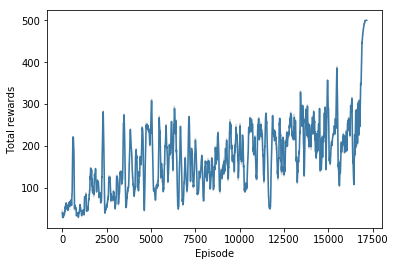

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

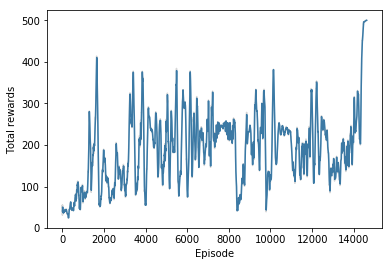

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

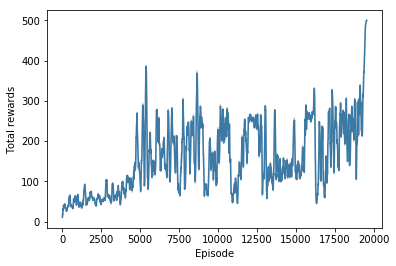

In [41]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

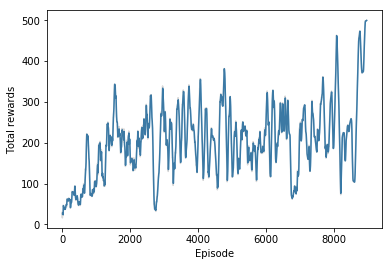

In [39]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

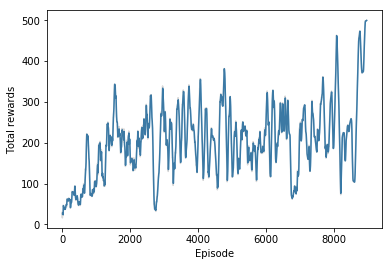

In [38]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

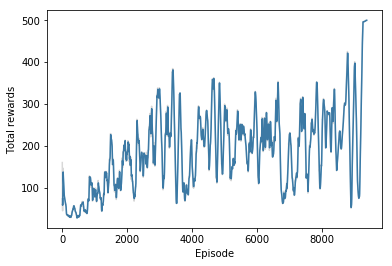

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

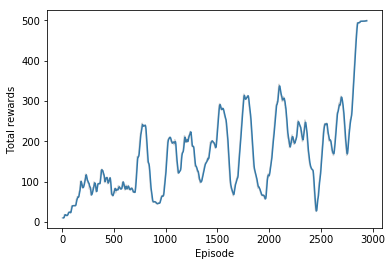

In [221]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

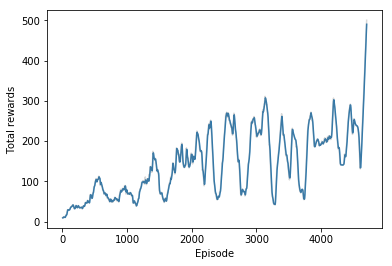

In [216]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

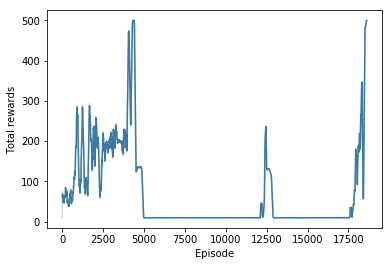

In [203]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

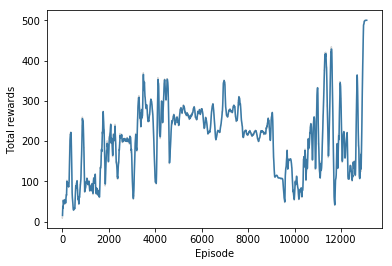

In [188]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

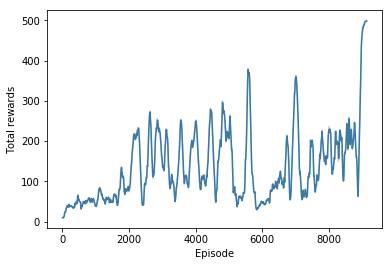

In [165]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

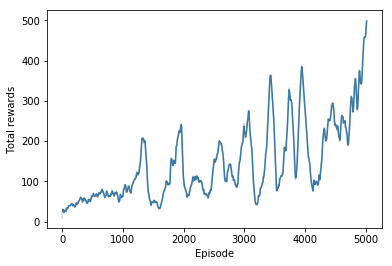

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

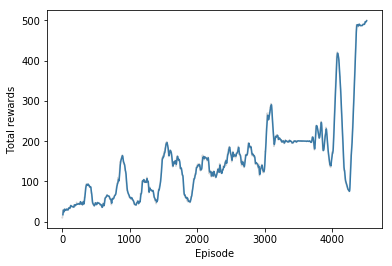

In [109]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

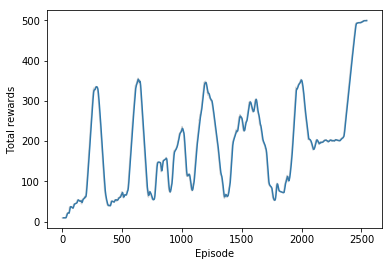

In [84]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

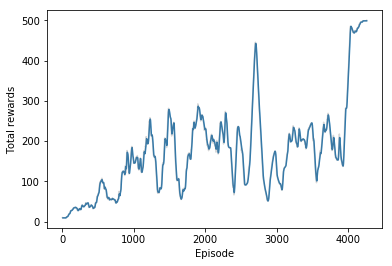

In [64]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

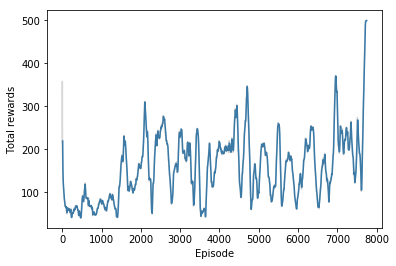

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

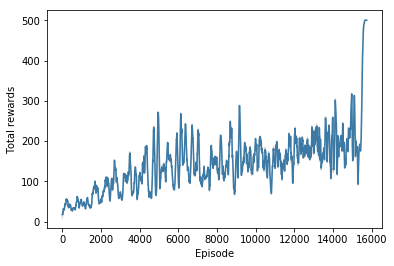

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

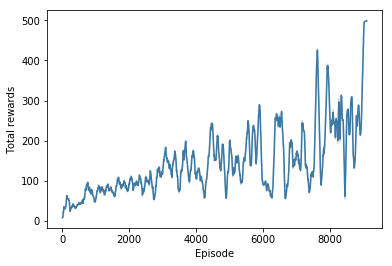

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

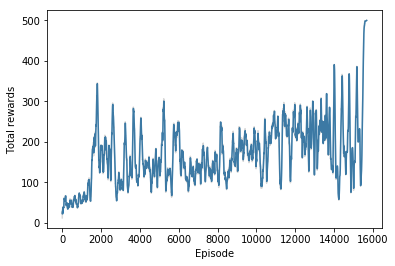

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

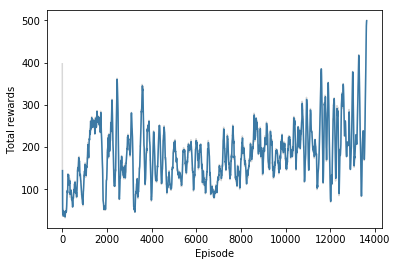

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

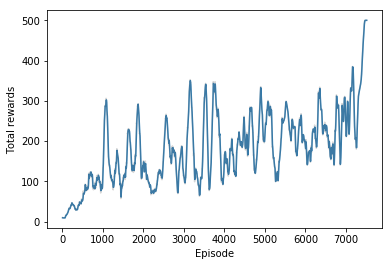

Text(0,0.5,'G losses')

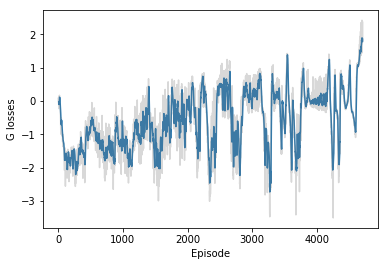

In [215]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

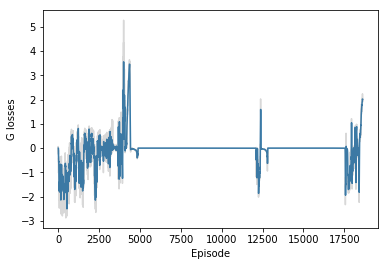

In [204]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

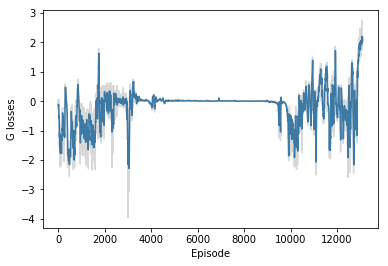

In [189]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

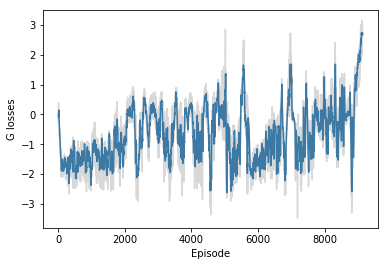

In [166]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

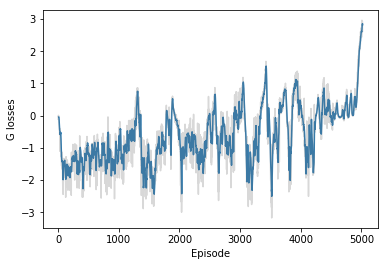

In [129]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

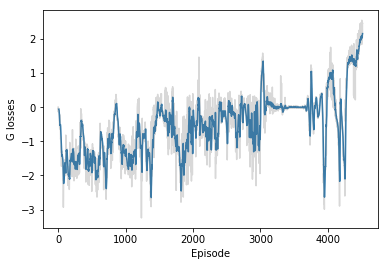

In [110]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

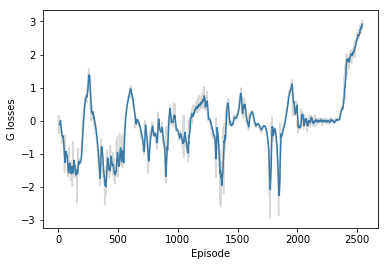

In [85]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

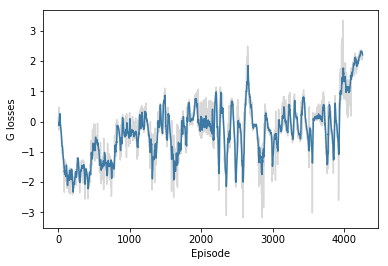

In [65]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

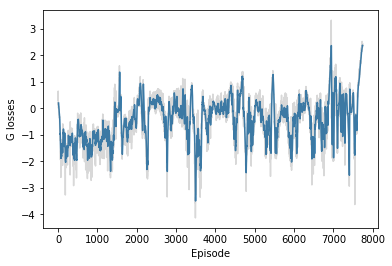

In [45]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

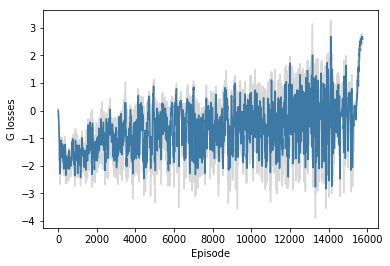

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

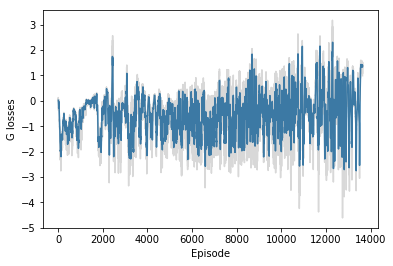

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

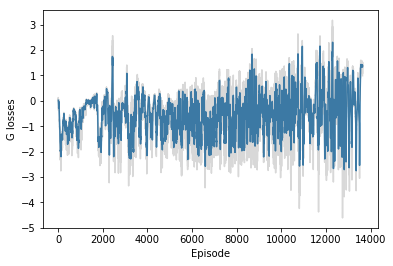

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

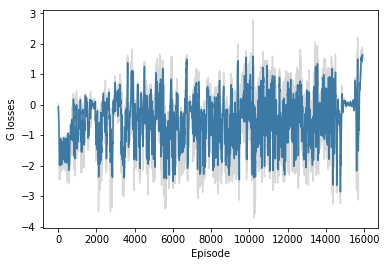
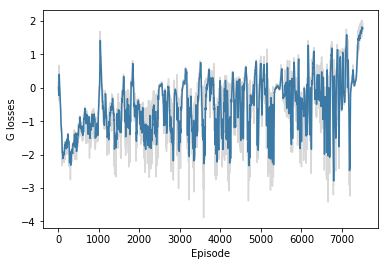

Text(0,0.5,'D losses')

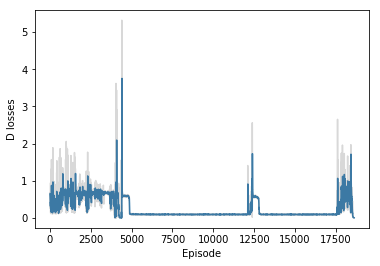

In [205]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

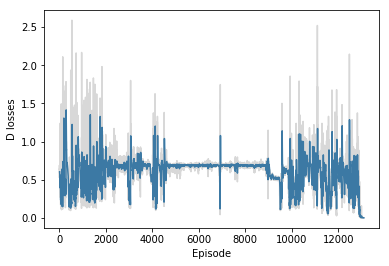

In [190]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

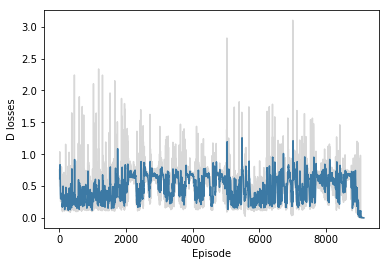

In [167]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

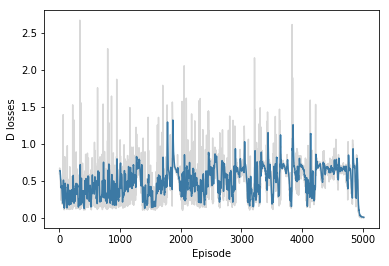

In [130]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

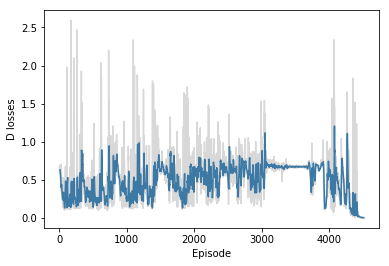

In [111]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

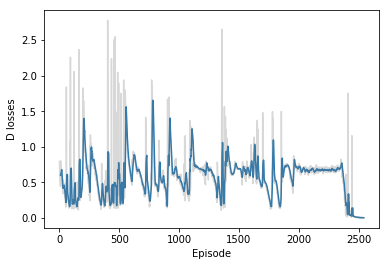

In [86]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

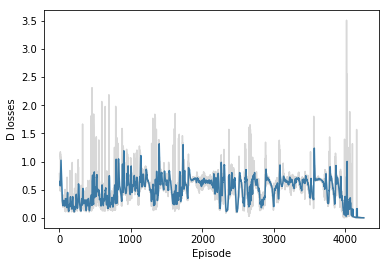

In [66]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

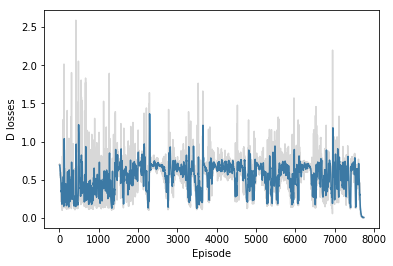

In [46]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

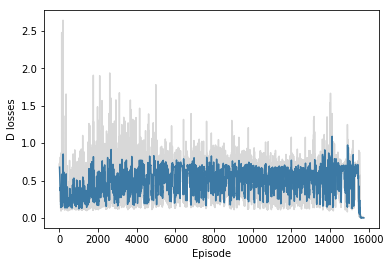

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

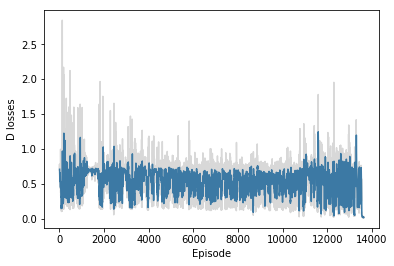

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

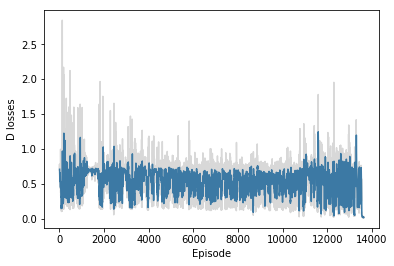

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

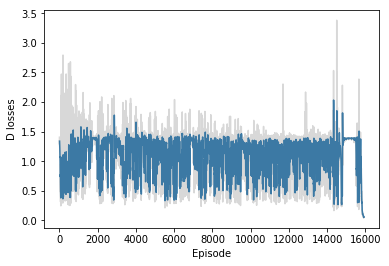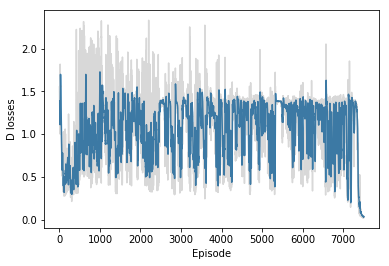

Text(0,0.5,'D losses R')

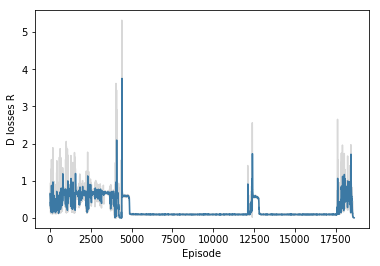

In [207]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

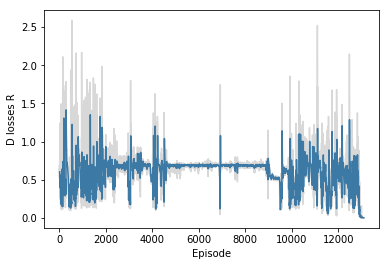

In [191]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

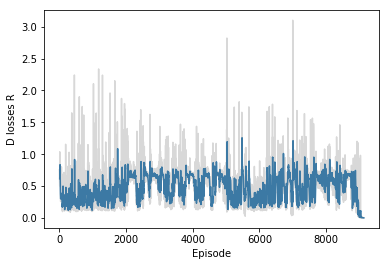

In [168]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

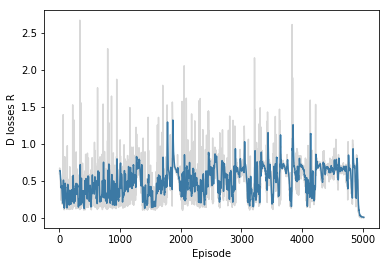

In [131]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

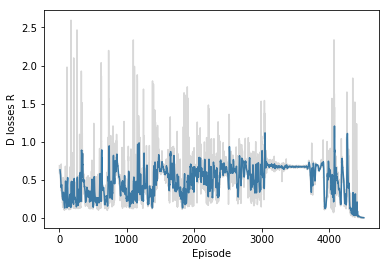

In [112]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

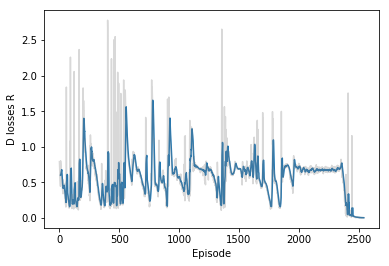

In [87]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

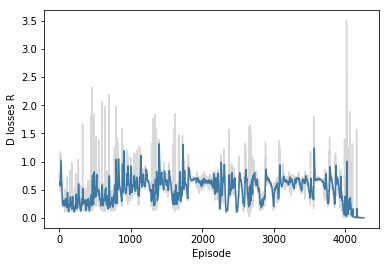

In [67]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

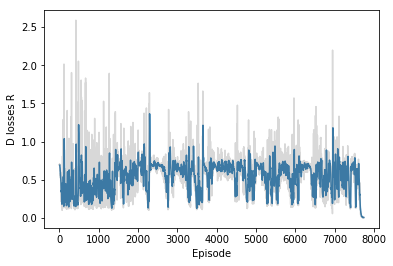

In [47]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

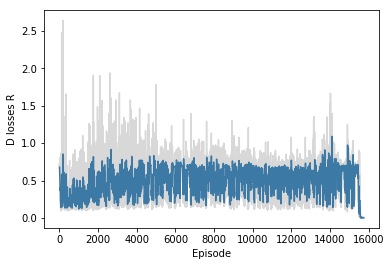

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

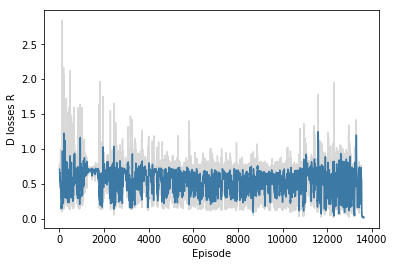

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

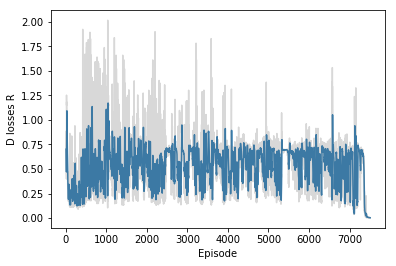

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

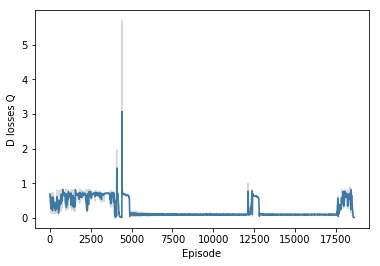

In [208]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

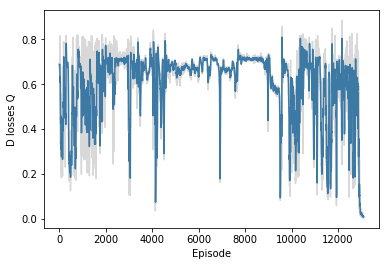

In [192]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

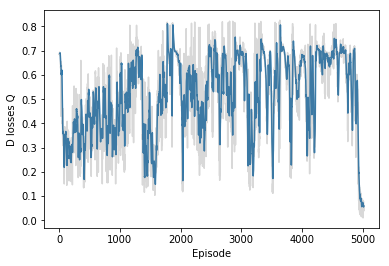

In [132]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

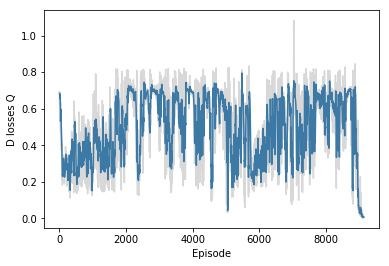

In [169]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

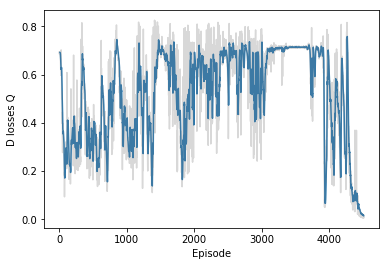

In [113]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

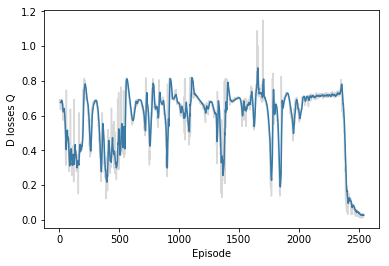

In [88]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

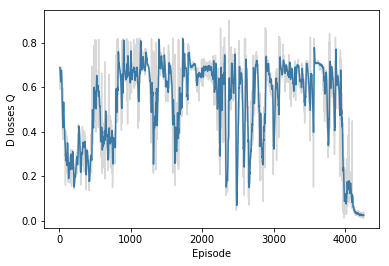

In [68]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

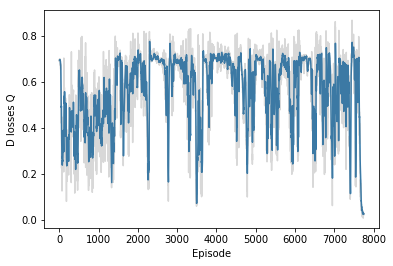

In [48]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

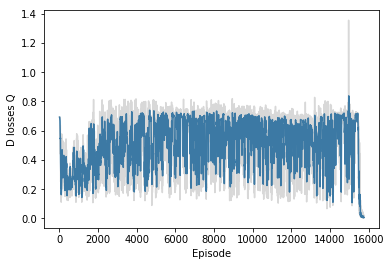

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

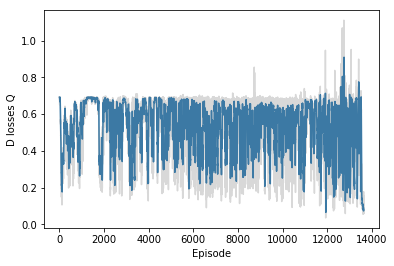

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

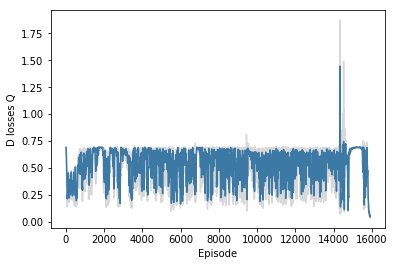

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

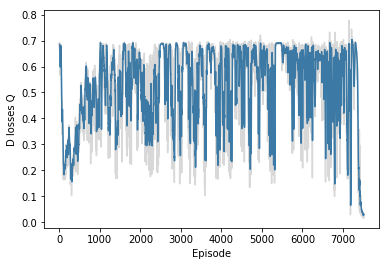

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.